# SMAScoliosis PredictX Notebook

## Load Packages, load data frame, clean data frame and merge


In [1]:
%load_ext autoreload
%autoreload 2

from pathlib import Path

import dtale
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

%config InlineBackend.figure_format = 'retina'

import importlib

import data_handling
import features
import ml_models
import plots
import utils

importlib.reload(utils)
importlib.reload(plots)
importlib.reload(data_handling)
importlib.reload(features)
importlib.reload(ml_models)

import pickle

import joblib
import missingno as msno
from matplotlib import cm
from matplotlib import colors as mcl
from matplotlib.backends.backend_pdf import PdfPages
from matplotlib.patches import Patch
# import shap
from pandas_summary import DataFrameSummary
from sklearn.model_selection import GroupKFold, StratifiedGroupKFold
from sklearn.preprocessing import StandardScaler

from data_handling import *
from features import *
from ml_models import *
from plots import *
from utils import *

In [2]:
# Load data set and set target directory for saving figures
PICKLES_DIR = 'pickles/'

# Set the target directory for saving figures
TARGET_DIR = 'figures/'
# Create directory, if missing
Path(TARGET_DIR).mkdir(parents=True, exist_ok=True)

path_to_file = 'dataset.csv'
df = data_handling.load_dataframe(path_to_file)

# LOAD DF_SPINE DATA FRAME 
path_to_file = 'dfspine.csv'

clean_path = Path(path_to_file)
df_spine = pd.read_csv(clean_path)

In [3]:
df = features.fix_encodings(df)
df = features.fix_fowardfill(df)

 69%|██████▉   | 40/58 [00:00<00:00, 195.95it/s]

Processing field: num_id
Processing field: birth_date
Processing field: gender
Processing field: birthplace
Processing field: residence
Processing field: date_genetic_test
Processing field: sma_test_type
Processing field: smn2_test_type
Processing field: smn1_mut_type
Processing field: smn1_pmut
Processing field: smn2_copies
Processing field: sma_type
Processing field: date_baseline_visit
Processing field: age_onset
Processing field: age_onset_months
Processing field: first_symptoms_other
Processing field: birth_history
Processing field: birth_weight
Processing field: screening_type
Processing field: siblings_num
Processing field: parents_consanguinous
Processing field: family_history
Processing field: aff_family_member
Processing field: family_history_2
Processing field: aff_family_member_2
Processing field: sit_wo_sup
Processing field: crawl_hands_knees
Processing field: stand_wo_sup
Processing field: walk_wo_sup
Processing field: climb_stairs
Processing field: sit_wo_sup_g
Processin

100%|██████████| 58/58 [00:00<00:00, 192.43it/s]

Processing field: baseline_date_start_gastric_t
Processing field: baseline_scoliosis_surgery
Processing field: baseline_surgery_date
Processing field: baseline_surgery_type
Processing field: baseline_illness
Processing field: baseline_illness_numb
Processing field: baseline_illness_type_test
Processing field: baseline_illness_type_test_2
Processing field: baseline_illness_type_test_3
Processing field: baseline_illness_type_test_4
Processing field: baseline_illness_type_test_5
Processing field: baseline_illness_type_test_6
Processing field: baseline_sma_meds
Processing field: baseline_sma_meds_other


In [4]:
### DATA CLEANING ###
# Engineered features

# FIX Age of onset
df = features.fix_age_onset(df)
df = features.fix2_age_onset(df)

# FIX First symptoms
df = features.clean_first_symptoms(df)

# FIX Motor milestones
df = features.feat_motormiles(df)

# FIX Baseline Ventilation 
df = features.feat_baseline_ventilation(df)      

##########

# FIX ULF MOTOR SCORES 
df = features.fix_ulf_scores(df)

# FIX Orthoses
df = features.feat_orthoses(df)

# FIX Medication
df = features.clean_medfields(df, 'medication')
df = features.clean_medfields(df, 'medication_2')
df = features.clean_medfields(df, 'medication_3')
df = features.clean_medfields(df, 'medication_4')
df = features.clean_medfields(df, 'medication_5')

# FIX Assistive devices
df = features.feat_devices(df)

# FIX Contractures
df = features.feat_contractures(df)

# FIX Interventions
df = features.feat_interventions(df)

# FIX Ventilation 
df = features.feat_ventilation(df) 

# CLEAN growth data fields
df = features.clean_growthFields(df, 'weight')
df = features.clean_growthFields(df, 'height')
df = features.clean_growthFields(df, 'head_circumference')
df = features.fix_growth_percentiles(df)

# Remove non-relevant columns 
df = dropCols(df, data_handling.to_drop_def)
df.shape

100%|██████████| 2/2 [00:00<00:00, 177.04it/s]


Processing field: first_symptoms
Processing field: first_symptoms_other
Processing:  ulf_sum


/Users/tlvh/Dev/github/smascoliosis_prediction/features.py:595: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

/Users/tlvh/Dev/github/smascoliosis_prediction/features.py:599: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

/Users/tlvh/Dev/github/smascoliosis_prediction/features.py:2174: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, u

(1230, 288)

In [5]:
# BREAK OUT DATA FRAMES 

# Remove rows by selecting all rows with first_visit_arm_1 and visit_arm_1
df_visits = data_handling.df_slice_visits(df)

# # First-line data 
df_first = data_handling.df_slice_firstline(df)

# Slicing Therapies
df_therapy =  data_handling.df_slice_therapy(df)

# Last-line data from df_visits
df_last =  data_handling.df_slice_lastline(df)

# for debugging
# fields = ['date_start_nus', 'date_start_ona', 'date_start_ris', 'age_start_therapy', 'age_ona', 'age_ris', 'date_nus', 'date_ona', 'therapy_arr', 'therapy_score']

print("=======================")
print("Visits:", df_visits.shape)
print("First:", df_first.shape)
print("Therapy:", df_therapy.shape)
print("Last:", df_last.shape)
print("=======================")

########################### GROUPED DATA FRAMES ###########################

# Prepare SMA Therapy data frames
# Breaks out a data frame that contains different therapy stats
# (1)
df_therapy = fix_TherapyDates(df_therapy)
# (2)
df_therapy_by_patient = data_handling.get_df_therapy_by_patient(df_therapy)
# (3) 
df_therapy_by_patient = data_handling.fix_TherapyAge(df_therapy_by_patient)

df_therapy_first = data_handling.df_slice_firstline(df_therapy_by_patient) 
df_therapy_last = data_handling.get_df_therapy_last(df_therapy_by_patient)

print("=======================")
print("Therapy grouped by patient:", df_therapy_by_patient.shape)
print("First Therapy grouped by patient:", df_therapy_first.shape)
print("Last Therapy grouped by patient:", df_therapy_last.shape)
print("=======================")

100%|██████████| 10/10 [00:00<00:00, 417.33it/s]


Processing field: date_start_nus
Processing field: age_start_therapy
Processing field: nus_presymp
Processing field: date_nus
Processing field: datediff_nus
Processing field: nus_dosetype
Processing field: nus_regular
Processing field: nus_appl
Processing field: nus_complications
Processing field: therapy_alt


100%|██████████| 14/14 [00:00<00:00, 558.01it/s]


Processing field: date_start_ona
Processing field: date_ona
Processing field: age_ona
Processing field: ona_repeat_yn
Processing field: ona_presymp
Processing field: ona_aav9ab
Processing field: ona_weight
Processing field: ona_dose
Processing field: ona_route
Processing field: prednisolon_prophyl
Processing field: prednisolon_prolong
Processing field: adverse_ona
Processing field: ona_complications
Processing field: ona_complications_2


100%|██████████| 5/5 [00:00<00:00, 826.56it/s]


Processing field: date_start_ris
Processing field: ris_time
Processing field: ris_regular
Processing field: ris_complications
Processing field: age_ris
Visits: (758, 288)
First: (86, 287)
Therapy: (472, 290)
Last: (86, 287)
Therapy grouped by patient: (472, 292)
First Therapy grouped by patient: (86, 291)
Last Therapy grouped by patient: (86, 292)


In [6]:
"""
Merge df_visits with df_spine data and merge it with the main data frame df_visits

Note: 
df_spine['scoliosis_yn'].unique() contains values [-1, 1, 0] 
-1 values are eliminated by the merging process, because merging on 'date_xspine' only merges values where a value for scoliosis_yn is available 
df_merged_by_patient['scoliosis_yn'].unique() only contains values [nan, 1, 0]

TO DO: check if merging -1 data (unknown) makes sense, if date_xspine is filled with 1900-01-01 for example 
"""
# Check if df_spine loaded correctly
print(df_spine.shape)

# Merge df_visits with df_spine data and merge it with the main data frame df_visits
df_merged_by_patient = data_handling.get_df_merged_by_patient(df_visits, df_spine, 'date_assessment', 'date_xspine', 'record_id')
print(df_merged_by_patient.info())

(186, 28)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 695 entries, 0 to 694
Columns: 316 entries, index to xspine_kyph
dtypes: Int64(1), datetime64[ns](22), float64(238), int64(8), object(47)
memory usage: 1.7+ MB
None


In [7]:
## Merge df_therapy into the main df 

# choose relevant columns from df_therapy_by_patient to merge 
df_therapy_by_patient = df_therapy_by_patient[df_therapy_by_patient['therapy_dates'].notnull()]
df_therapy_to_merge = df_therapy_by_patient[['record_id', 'therapy_dates', 'therapy_arr', 'therapy_score', 'therapy_age']]

# merge with main data frame
df_main = data_handling.get_df_merged_by_patient_2(df_merged_by_patient, df_therapy_to_merge, 'date_assessment', 'therapy_dates', 'record_id')

"""
Clean up features after merging 
"""
df_main = utils.clean_nan_fields(df_main, 'age_of_onset')
df_main = utils.clean_nan_fields(df_main, 'age_of_onset_months')
df_main = utils.clean_nan_fields(df_main, 'airway_clearance')
df_main = utils.fill_nan_TherapyField(df_main, 'therapy_score')
df_main = feat_airwayclear(df_main)

In [8]:
# TRAIN ON THESE FEATURES

"""
select and display the features (columns) that will be used for training: 

# main_cols = ['record_id'] + relevant_cols 
# dtale.show(df_main[main_cols])

# len(np.unique(df_train['record_id'].values)) # = 59
# len(df_train[label]) #.unique() # size of the data set = 332 

"""

selected_features = ['age_assess', 
                     'ventilation_term', 
                     'orthoses_score', 
                     'contractures_score', 
                     #'height',  'height_percs_fixed', 'head_circumference', 
                     #'headc_percs_fixed', 
                     #'motormiles_score', 
                     'hfmse_motor_score', 
                     'chop_motor_score', #'cx_neurology', 
                     # 'therapy_score', # 'therapy_age'
                    ]

data_filtered = df_main[selected_features] 

# Analysis of missingness and data imputation


             age_assess ventilation_term orthoses_score contractures_score   
counts              695              694            695                695  \
uniques             554                8             31                 40   
missing               0                1              0                  0   
missing_perc         0%            0.14%             0%                 0%   
types           numeric          numeric        numeric            numeric   

             hfmse_motor_score chop_motor_score  
counts                     246              283  
uniques                     56               54  
missing                    449              412  
missing_perc            64.60%           59.28%  
types                  numeric          numeric  


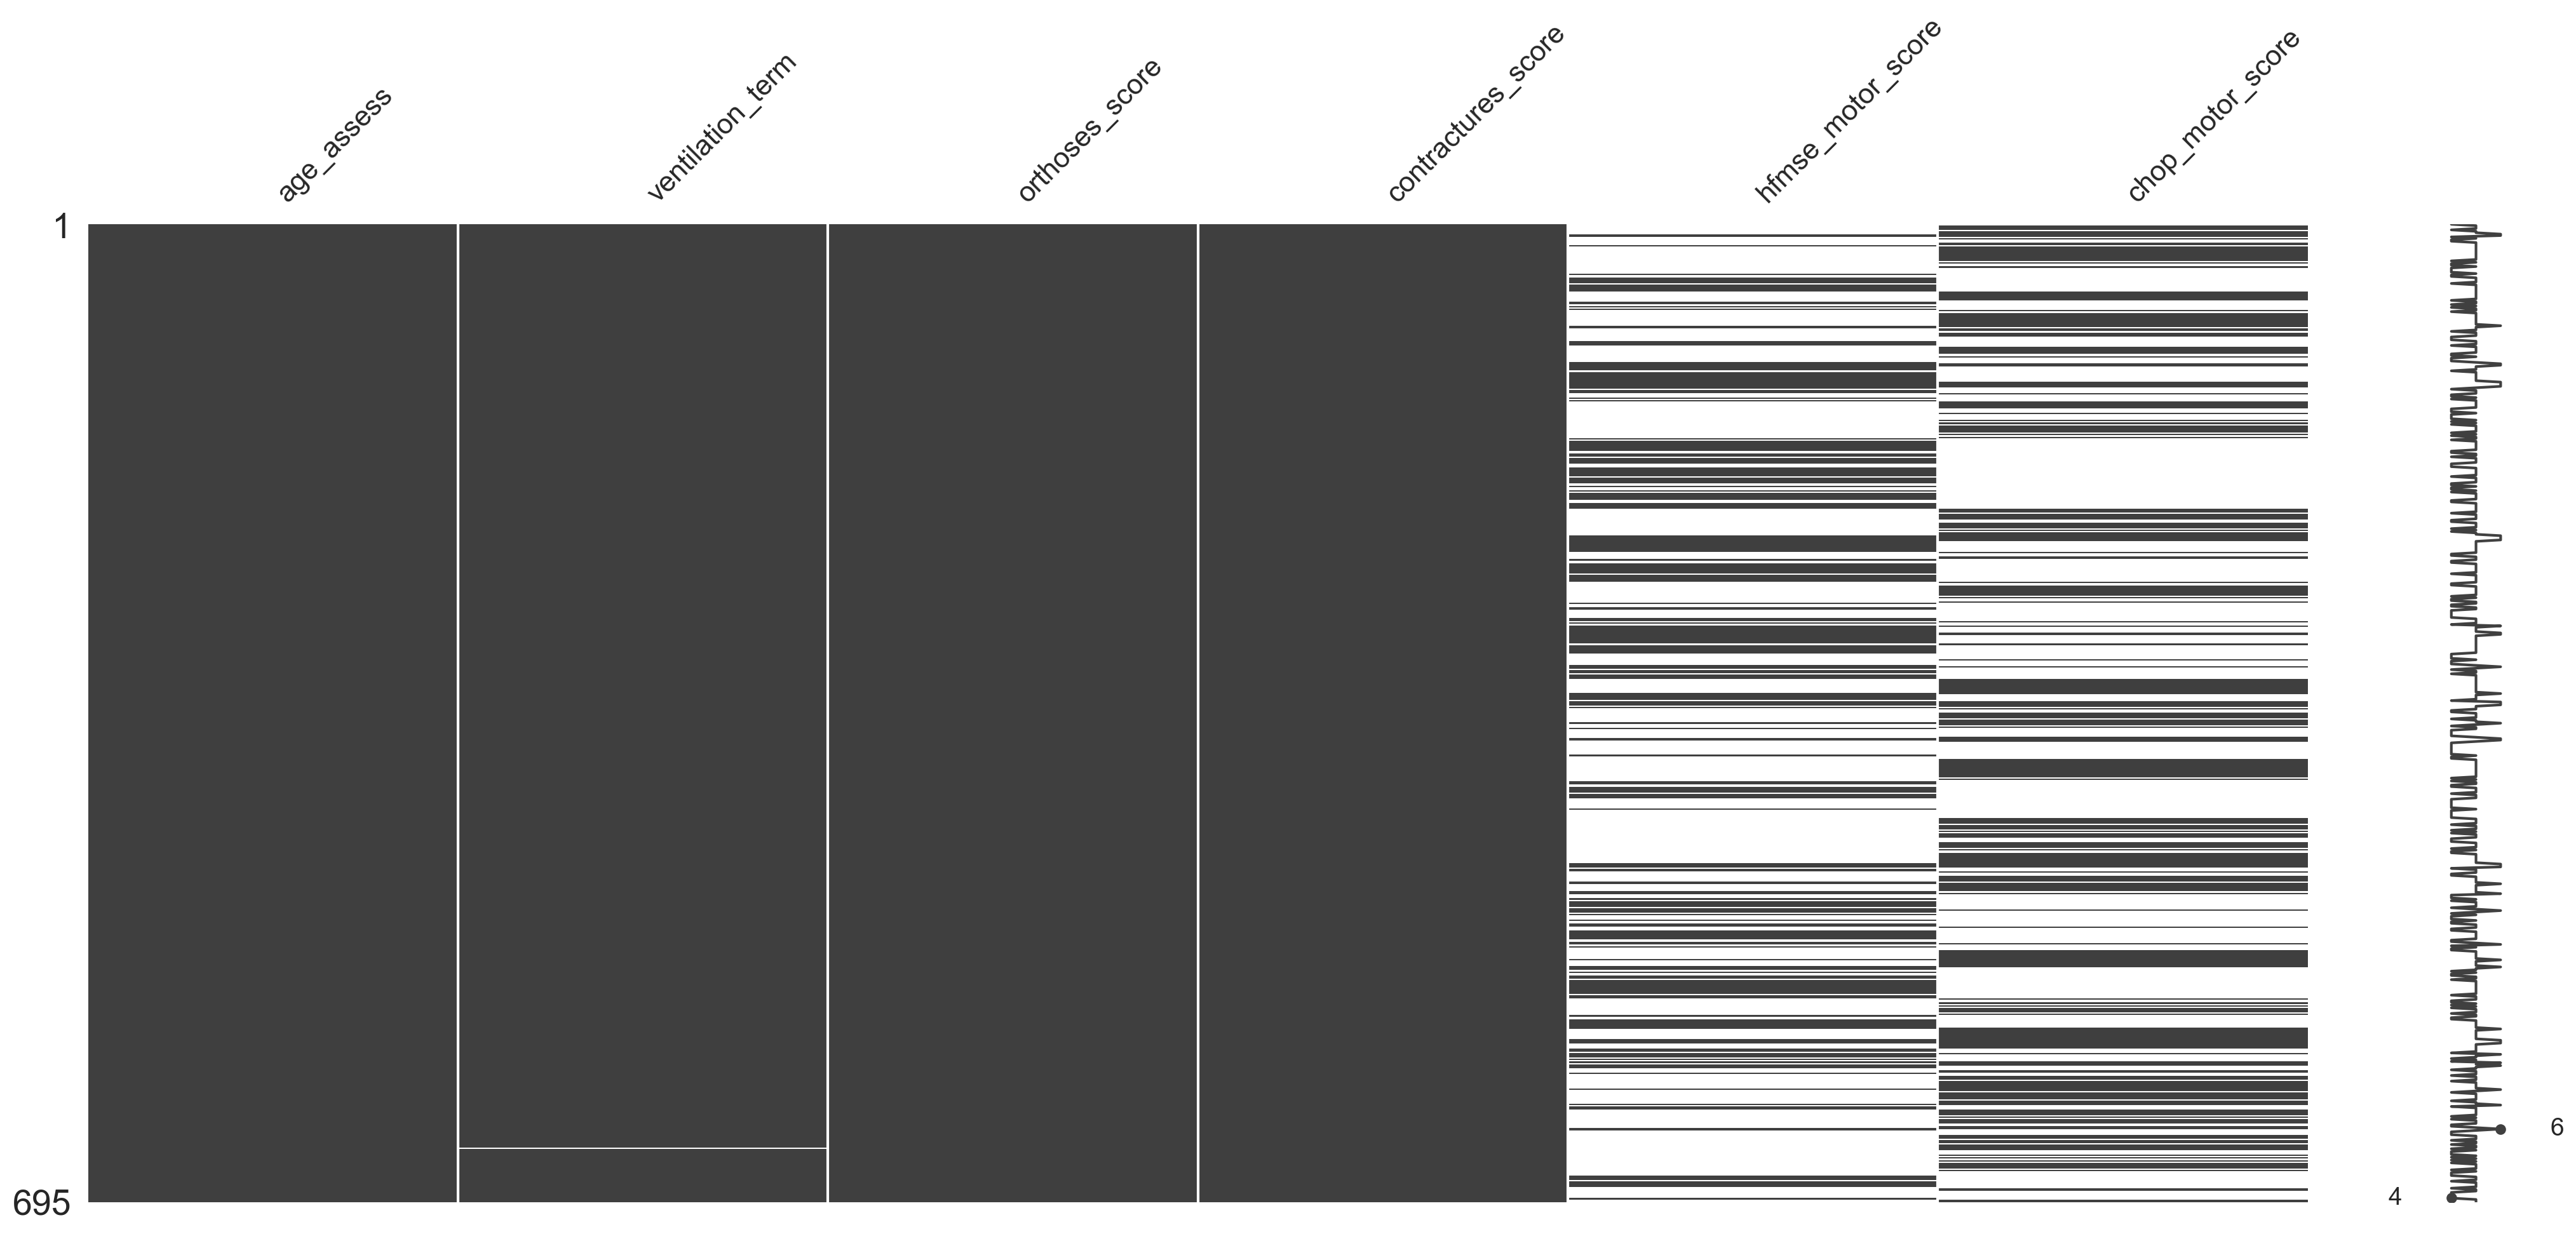

In [9]:
# plot missing data BEFORE imputation 
training_data = df_main[selected_features]

dfs_training_data = DataFrameSummary(training_data[selected_features])

print(dfs_training_data.columns_stats)

msno.matrix(training_data)
plt.savefig(TARGET_DIR + "MSNO Matrix_before_imp", dpi=DPI, bbox_inches = "tight")

             age_assess ventilation_term orthoses_score contractures_score   
counts              695              694            695                695  \
uniques             554                8             31                 40   
missing               0                1              0                  0   
missing_perc         0%            0.14%             0%                 0%   
types           numeric          numeric        numeric            numeric   

             hfmse_motor_score chop_motor_score  
counts                     375              459  
uniques                     96              105  
missing                    320              236  
missing_perc            46.04%           33.96%  
types                  numeric          numeric  


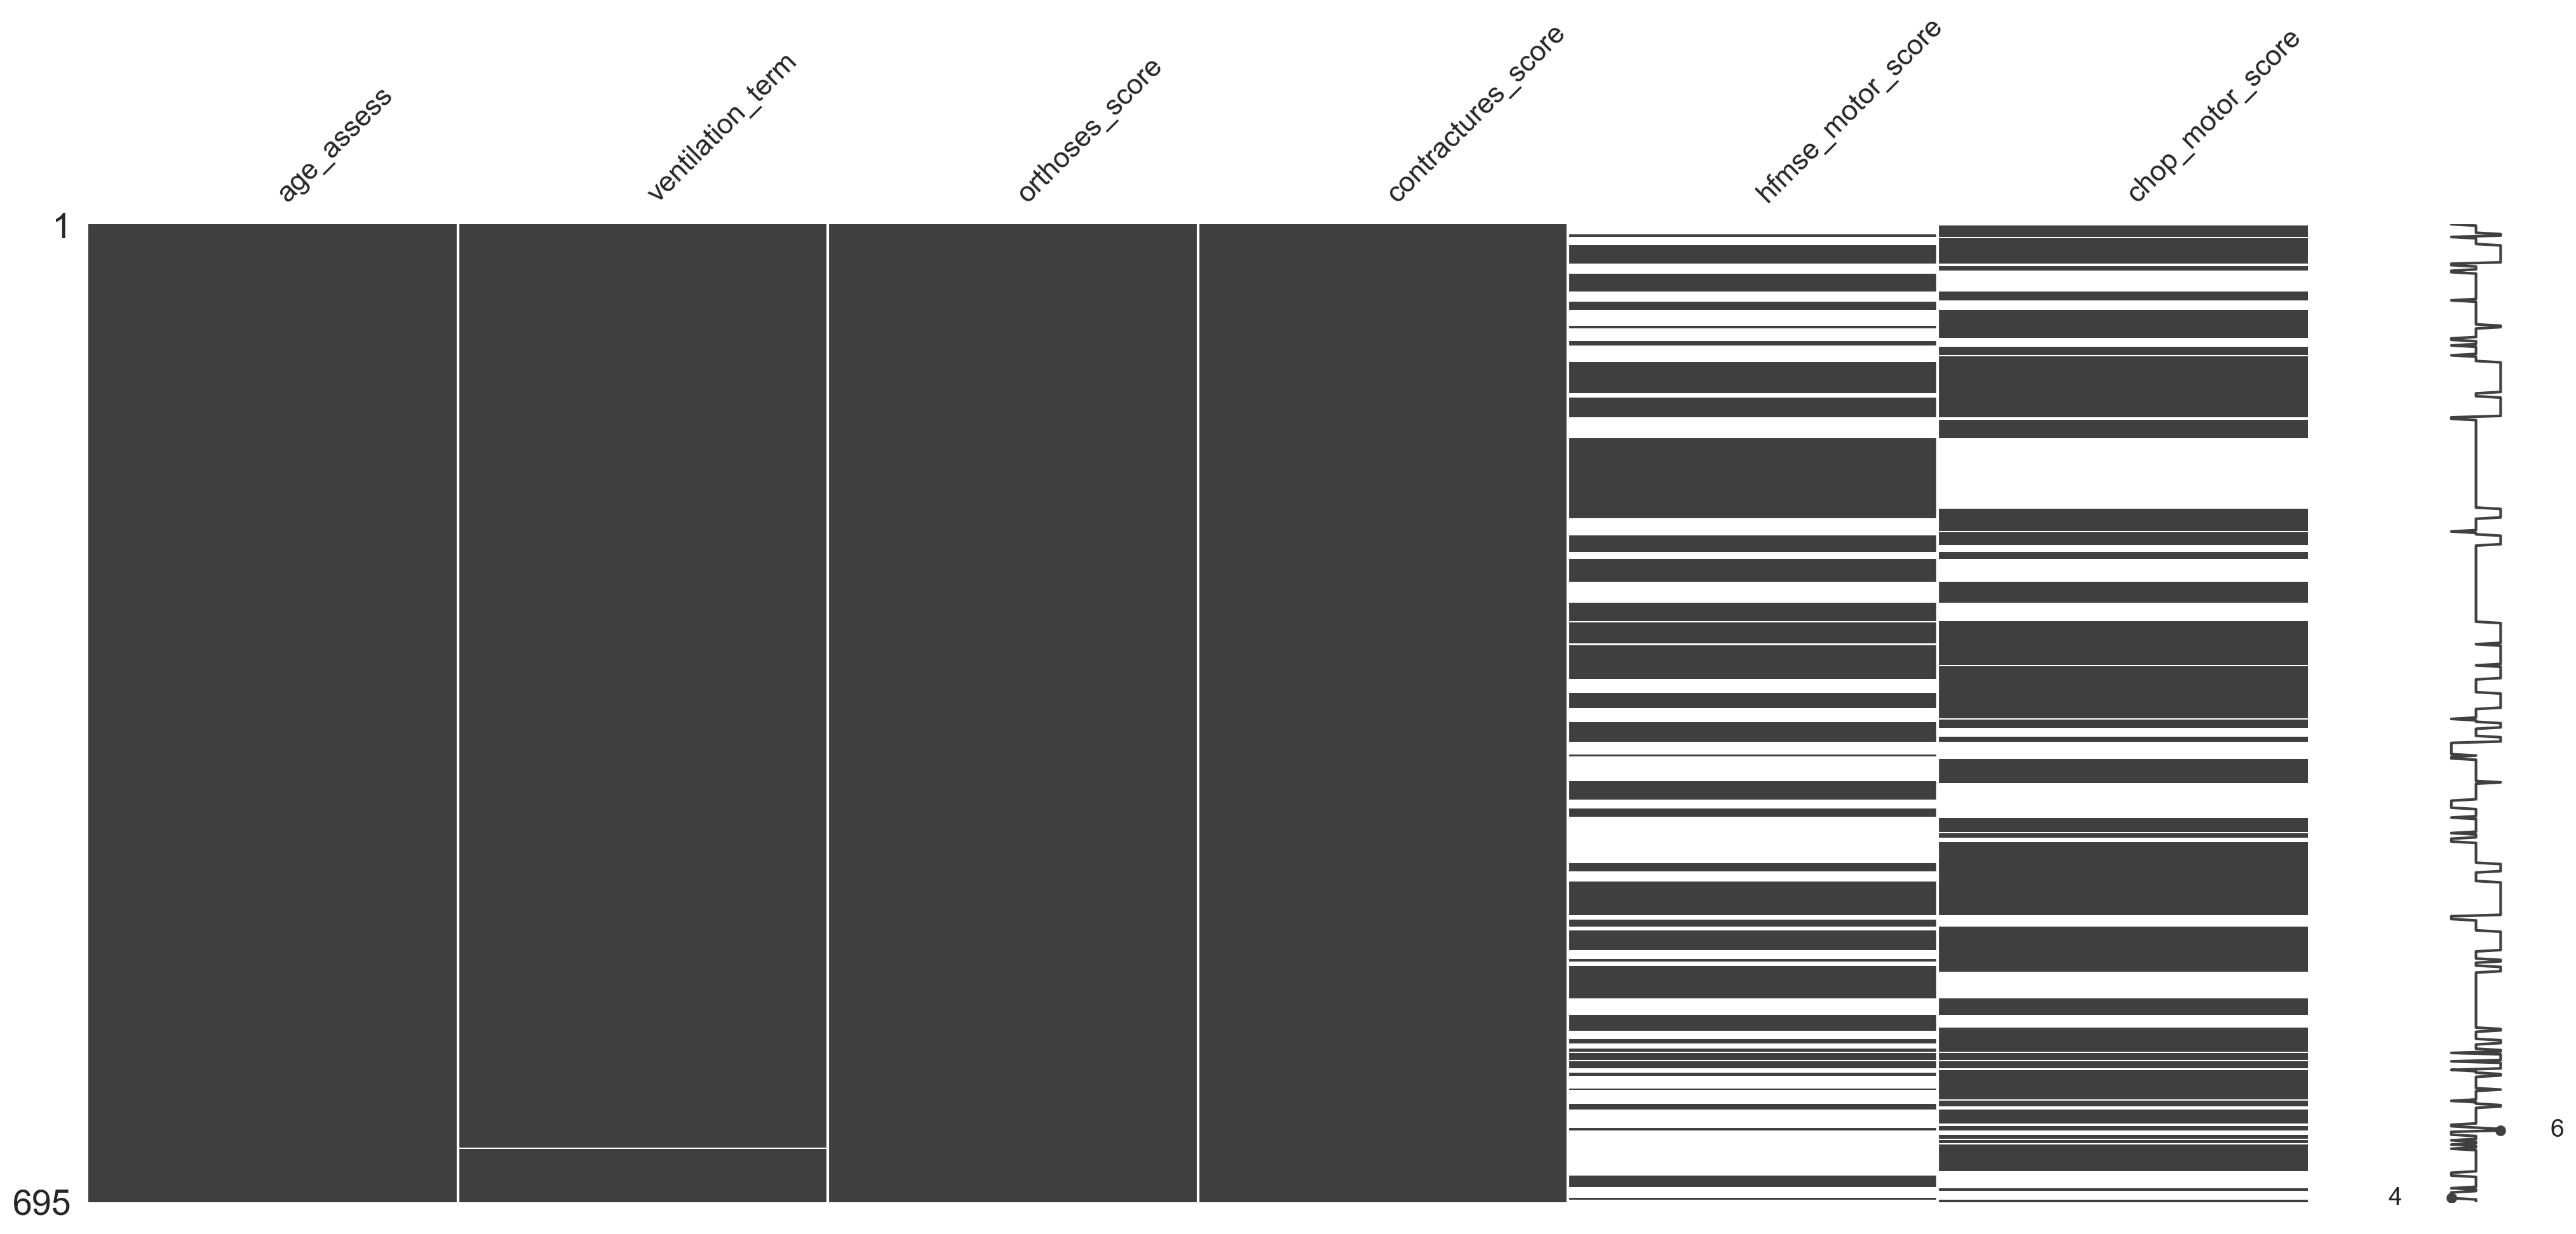

In [10]:
"""
impute missing data for time series using interpolate
"""
df_main['hfmse_motor_score'] = df_main.groupby('record_id')['hfmse_motor_score'].apply(lambda x: x.interpolate()).reset_index(drop=True)
df_main['chop_motor_score'] = df_main.groupby('record_id')['chop_motor_score'].apply(lambda x: x.interpolate()).reset_index(drop=True)
df_main['head_circumference'] = df_main.groupby('record_id')['head_circumference'].apply(lambda x: x.interpolate()).reset_index(drop=True)
df_main['height'] = df_main.groupby('record_id')['height'].apply(lambda x: x.interpolate()).reset_index(drop=True)
df_main['weight'] = df_main.groupby('record_id')['weight'].apply(lambda x: x.interpolate()).reset_index(drop=True)

""" 
Plot missing data AFTER imputation and get statistics on missing data
"""
training_data = df_main[selected_features]

## perform missing analysis after imputation 
dfs_training_data = DataFrameSummary(training_data[selected_features])

print(dfs_training_data.columns_stats)

msno.matrix(training_data)
plt.savefig(TARGET_DIR + "MSNO Matrix_after_imp", dpi=DPI, bbox_inches = "tight")

# Univariate Feature Analysis: PPS & Correlation Analyses


### Plot PPS Matrix


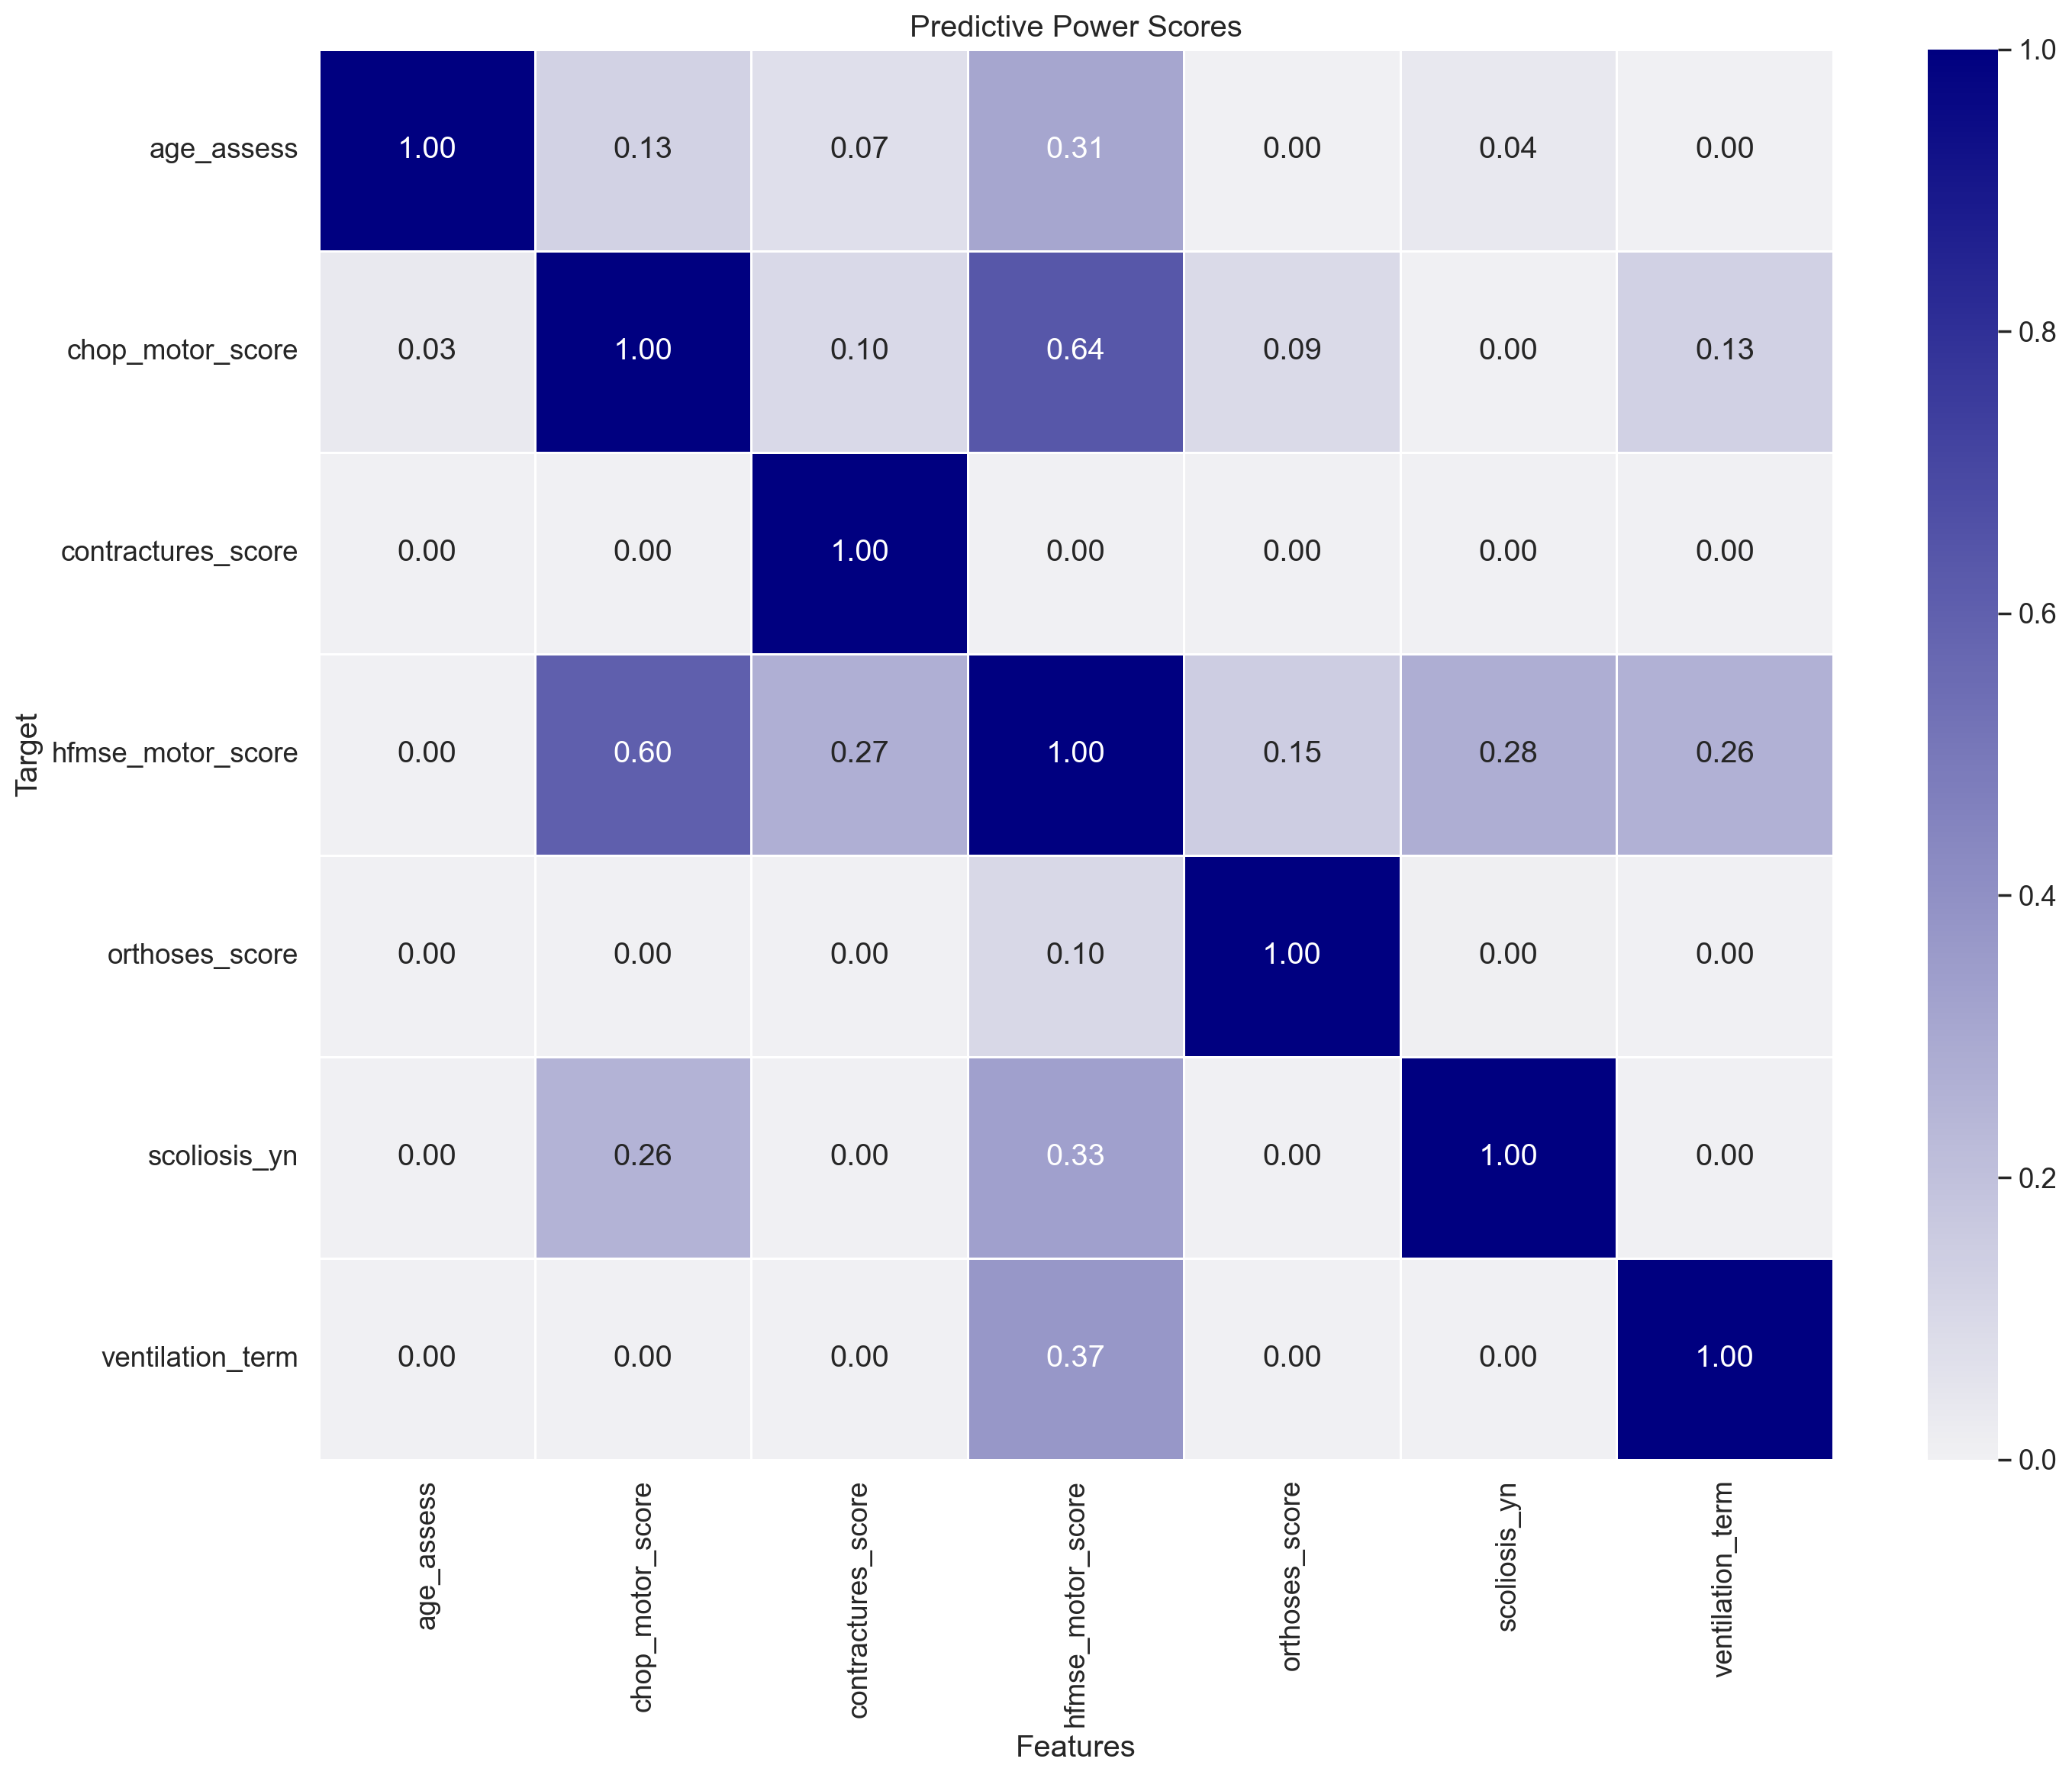

In [11]:
matrix_features = ['age_assess', 
                     'ventilation_term', 
                     'orthoses_score', 
                     'contractures_score', 
                     'hfmse_motor_score', 
                     'chop_motor_score', 
                     'scoliosis_yn'
                    ]

matrix_data = df_main[matrix_features] 

generatePPS(matrix_data, "Predictive Power Scores", fn=TARGET_DIR+"/pps_matrix.pdf")

## Plot correlation matrix of the features


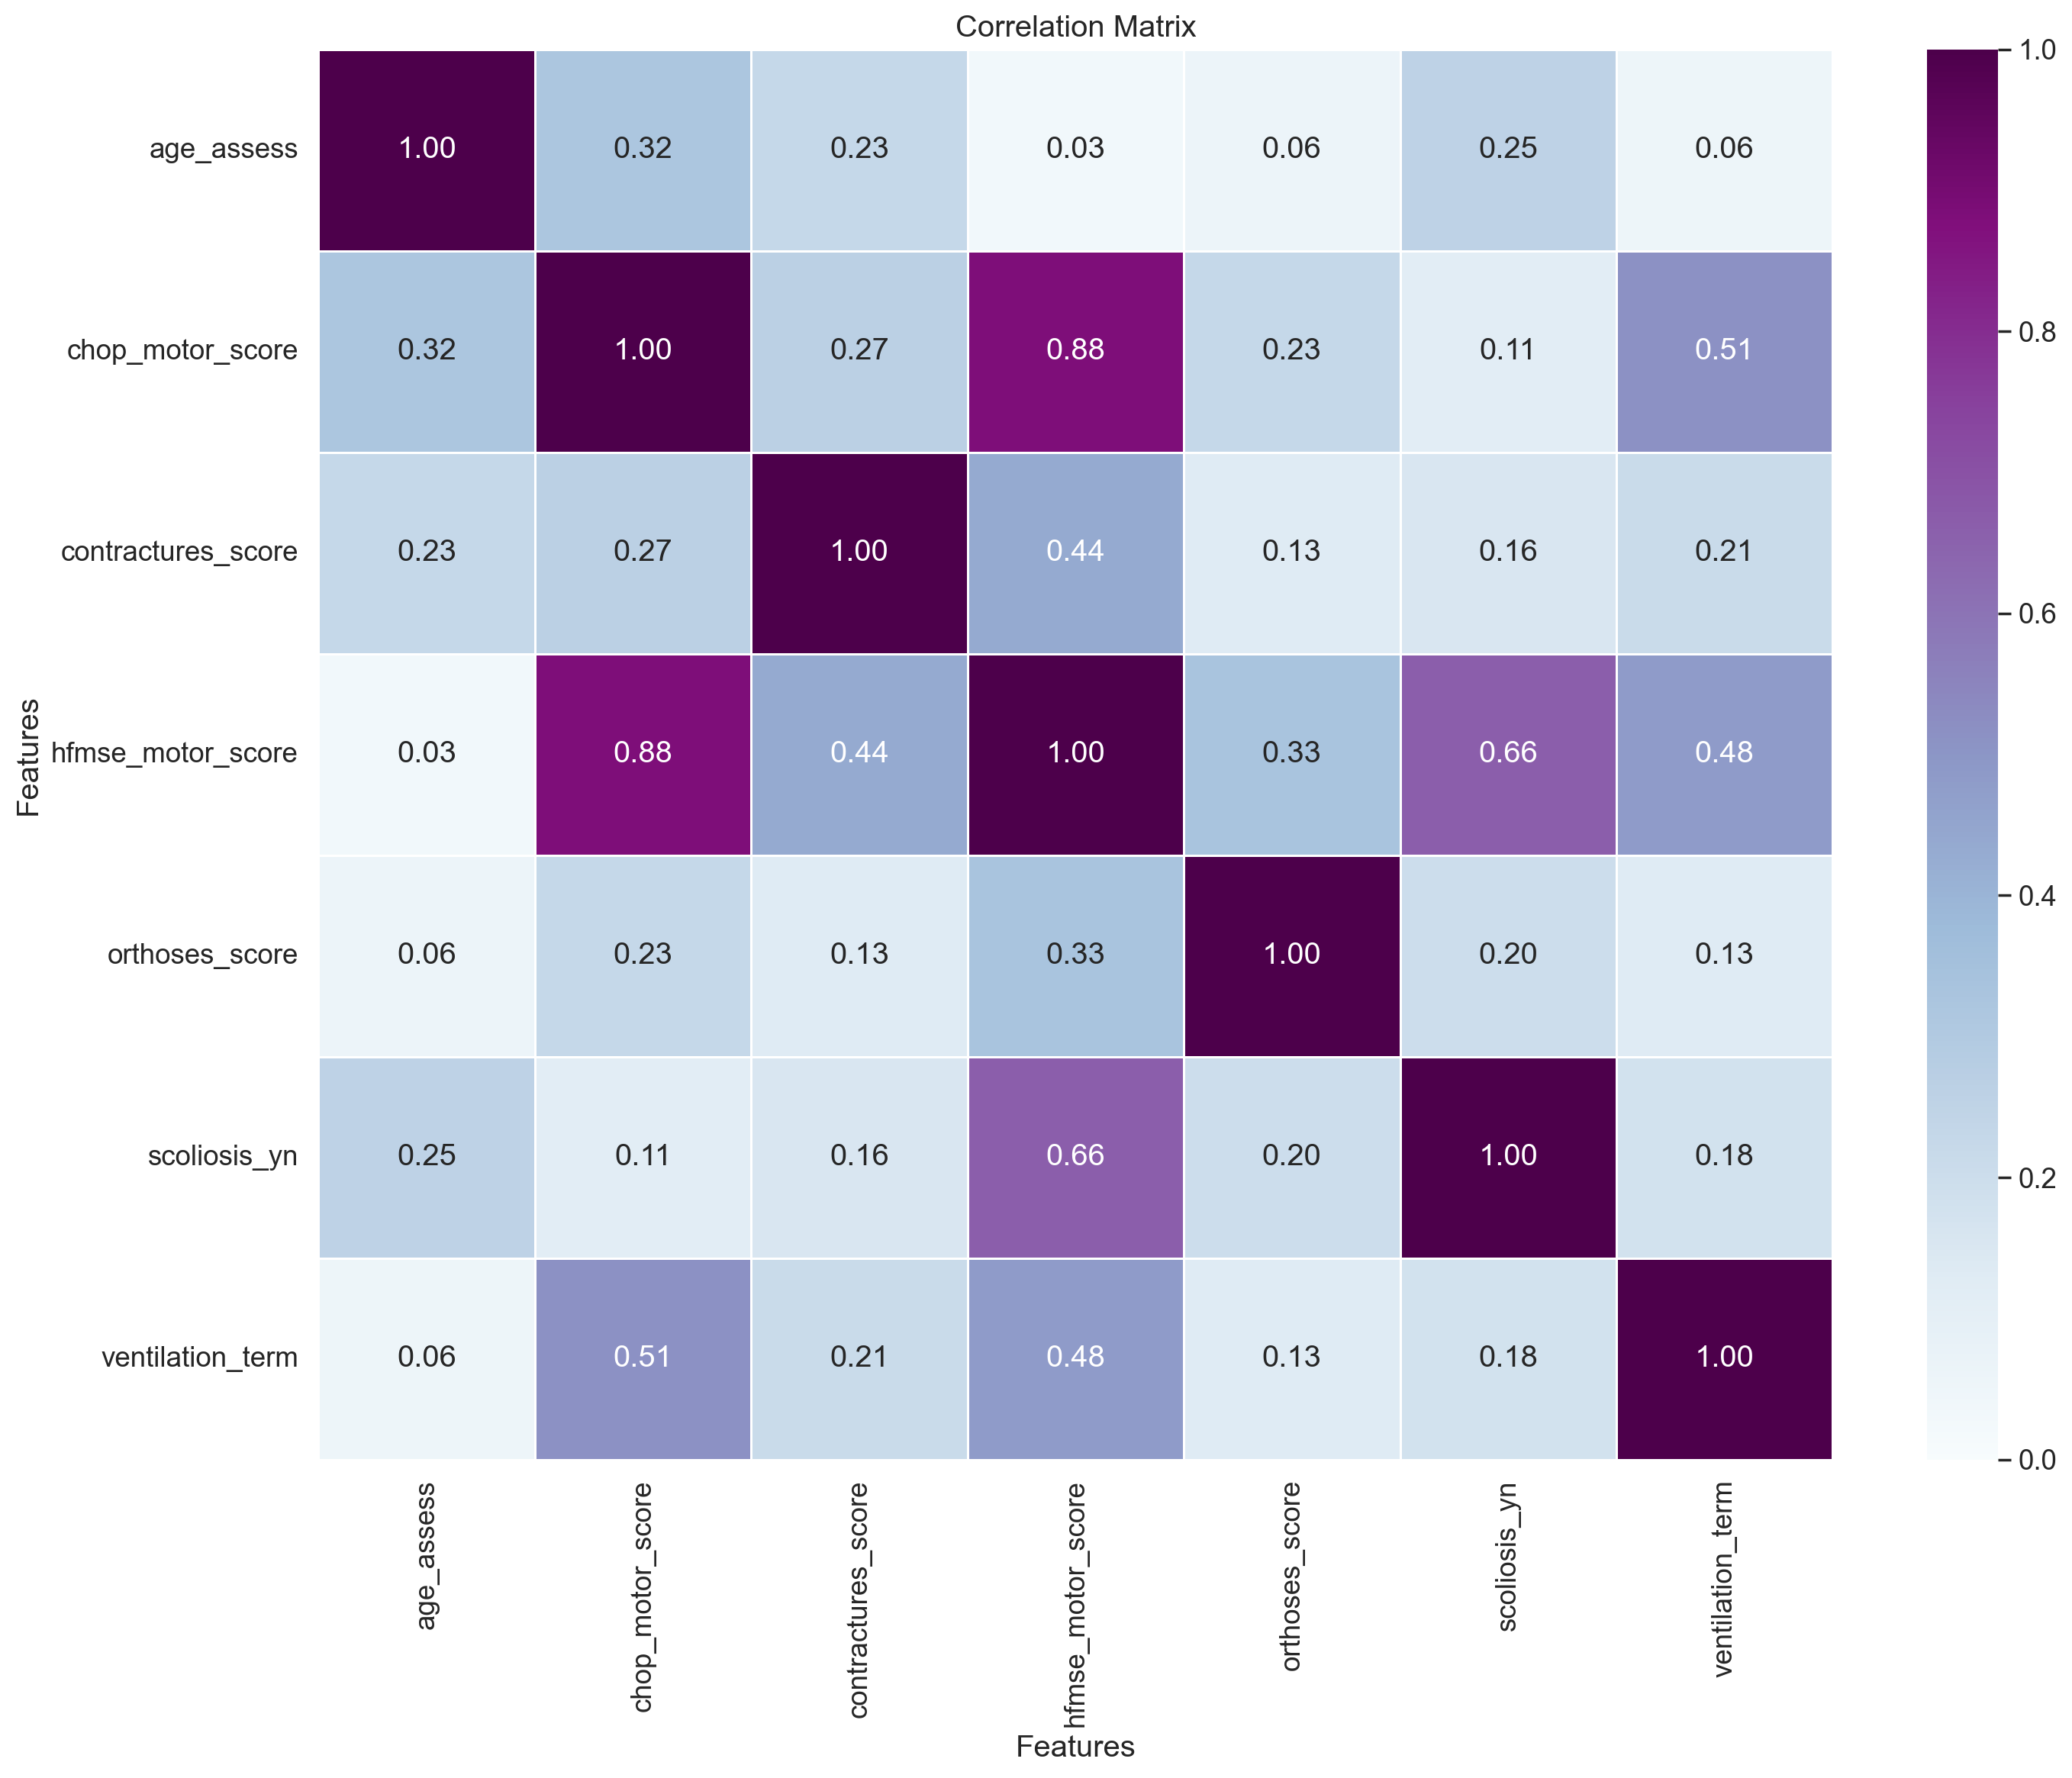

In [12]:
plotCorrelation(matrix_data, "Correlation Matrix", threshold=None, fn=TARGET_DIR+"/corr_matrix.pdf")

# ML Model: Train Random Forest Classifier


In [13]:
"""
define training data and labels
""" 
traincols = selected_features
label = "scoliosis_yn"

df_train = df_main[df_main[label].notnull()] # selects only records with available label data 

"""
save non-label data under true_valid ids using pickle for the true validation set
"""
# true_valid = df_main[df_main[label].isnull()]

# Create directory, if missing
Path(PICKLES_DIR).mkdir(parents=True, exist_ok=True)

with open(f'{PICKLES_DIR}selected_features.pickle', 'wb') as f: 
    pickle.dump(selected_features, f)

print("============'Selected Features for training:=============")
traincols

============'Selected Features for training:=============


['age_assess',
 'ventilation_term',
 'orthoses_score',
 'contractures_score',
 'hfmse_motor_score',
 'chop_motor_score']

## Train RFC and plot 10 train folds


In [14]:
"""
Train model using groupKfold cross-validation 
"""
X, y, train_folds, test_folds, groups, feature_names, n_splits = random_groupKfold_model(df_train, traincols, label, random_state=RANDOM_STATE, stratified=True)

In [15]:
sc = StandardScaler()
sc.fit(X)
X = sc.transform(X)
print(sc)

joblib.dump(sc, filename=TARGET_DIR + 'std_scaler.bin', compress=True)

scores, X_train_list, y_train_list, y_pred_list, y_test_list, y_pred_proba_list, models, X_test_list = train_rfc_models_k_fold(X, y, df_train, train_folds, test_folds, groups)

StandardScaler()


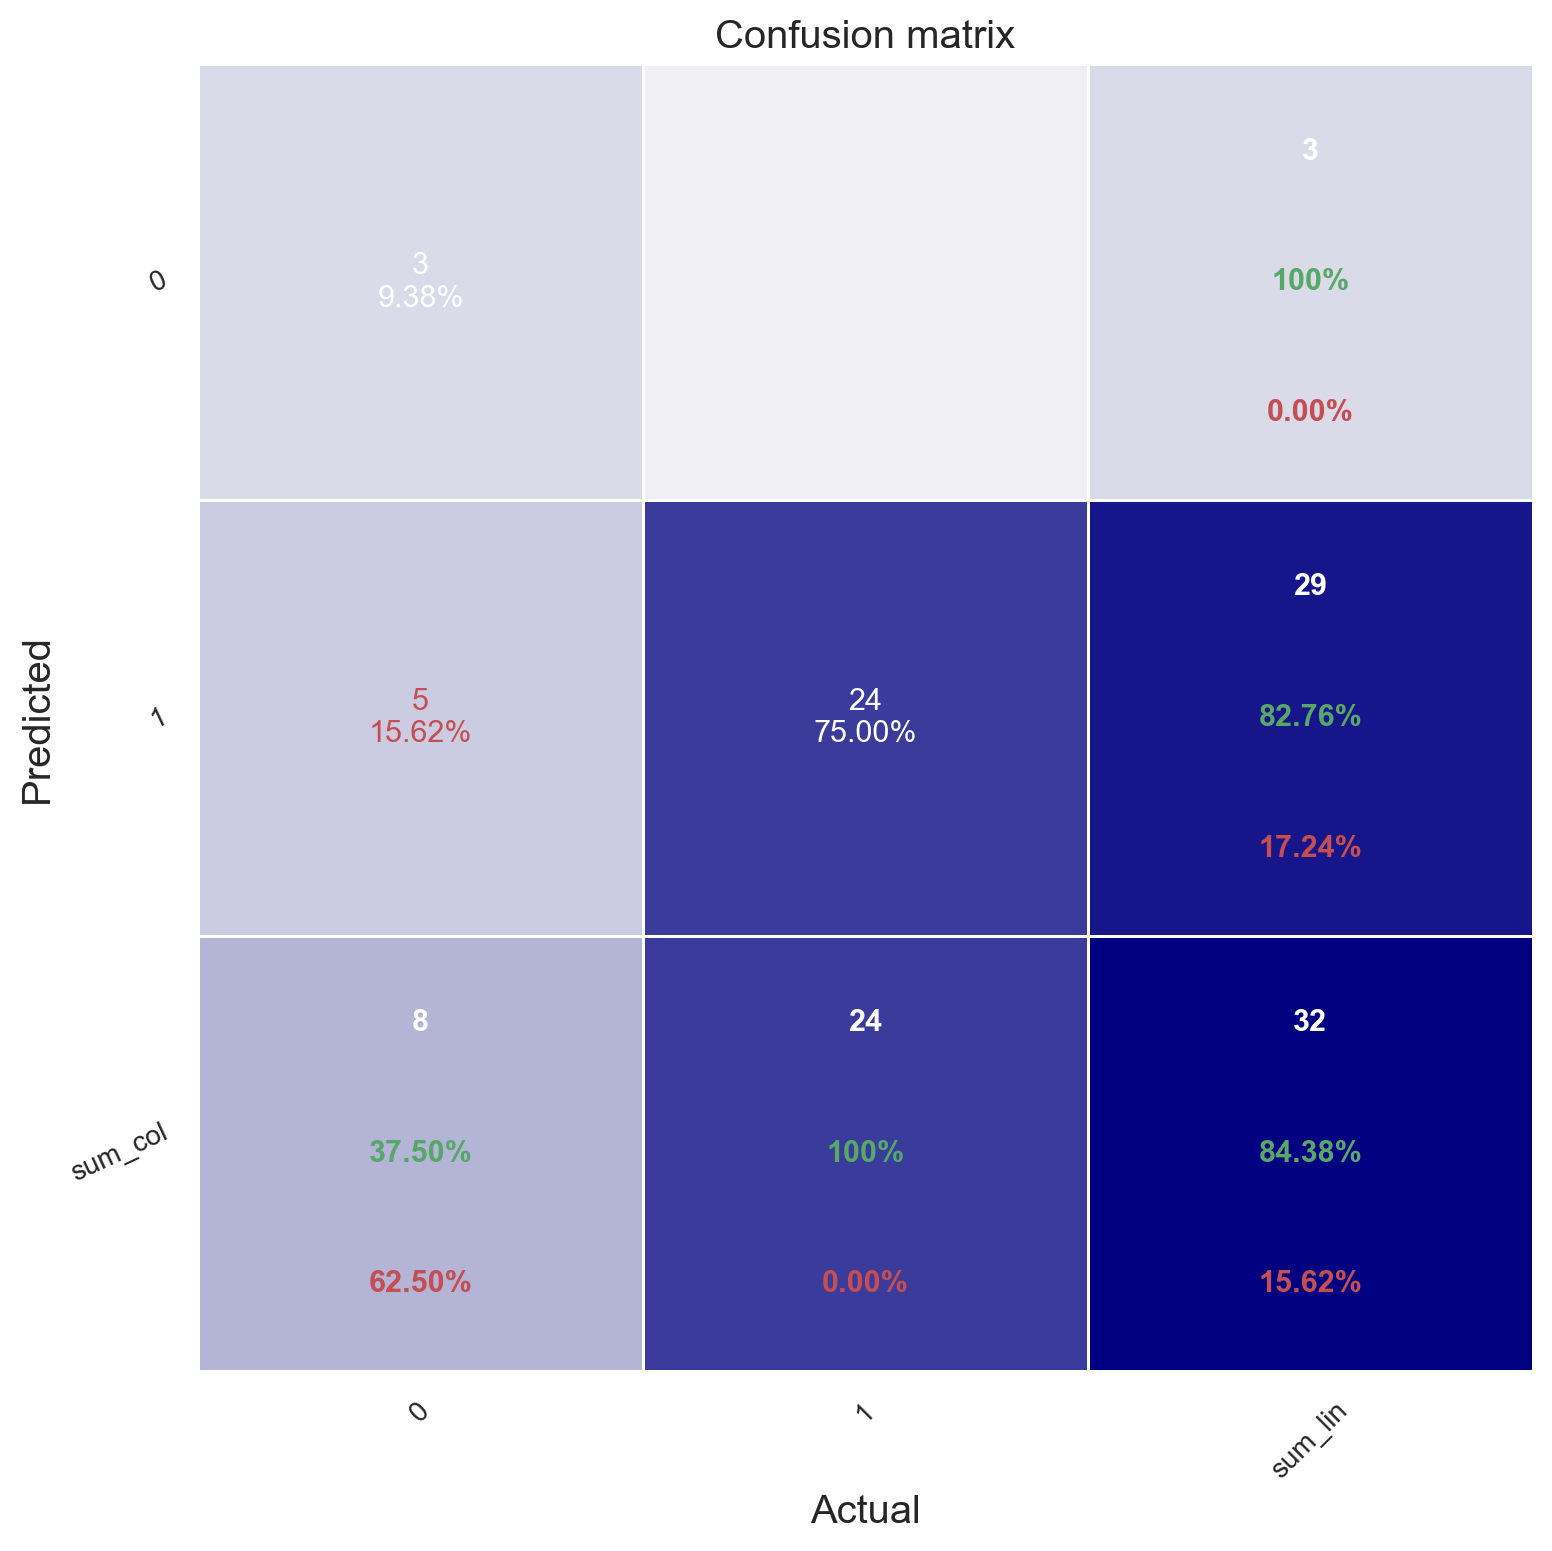

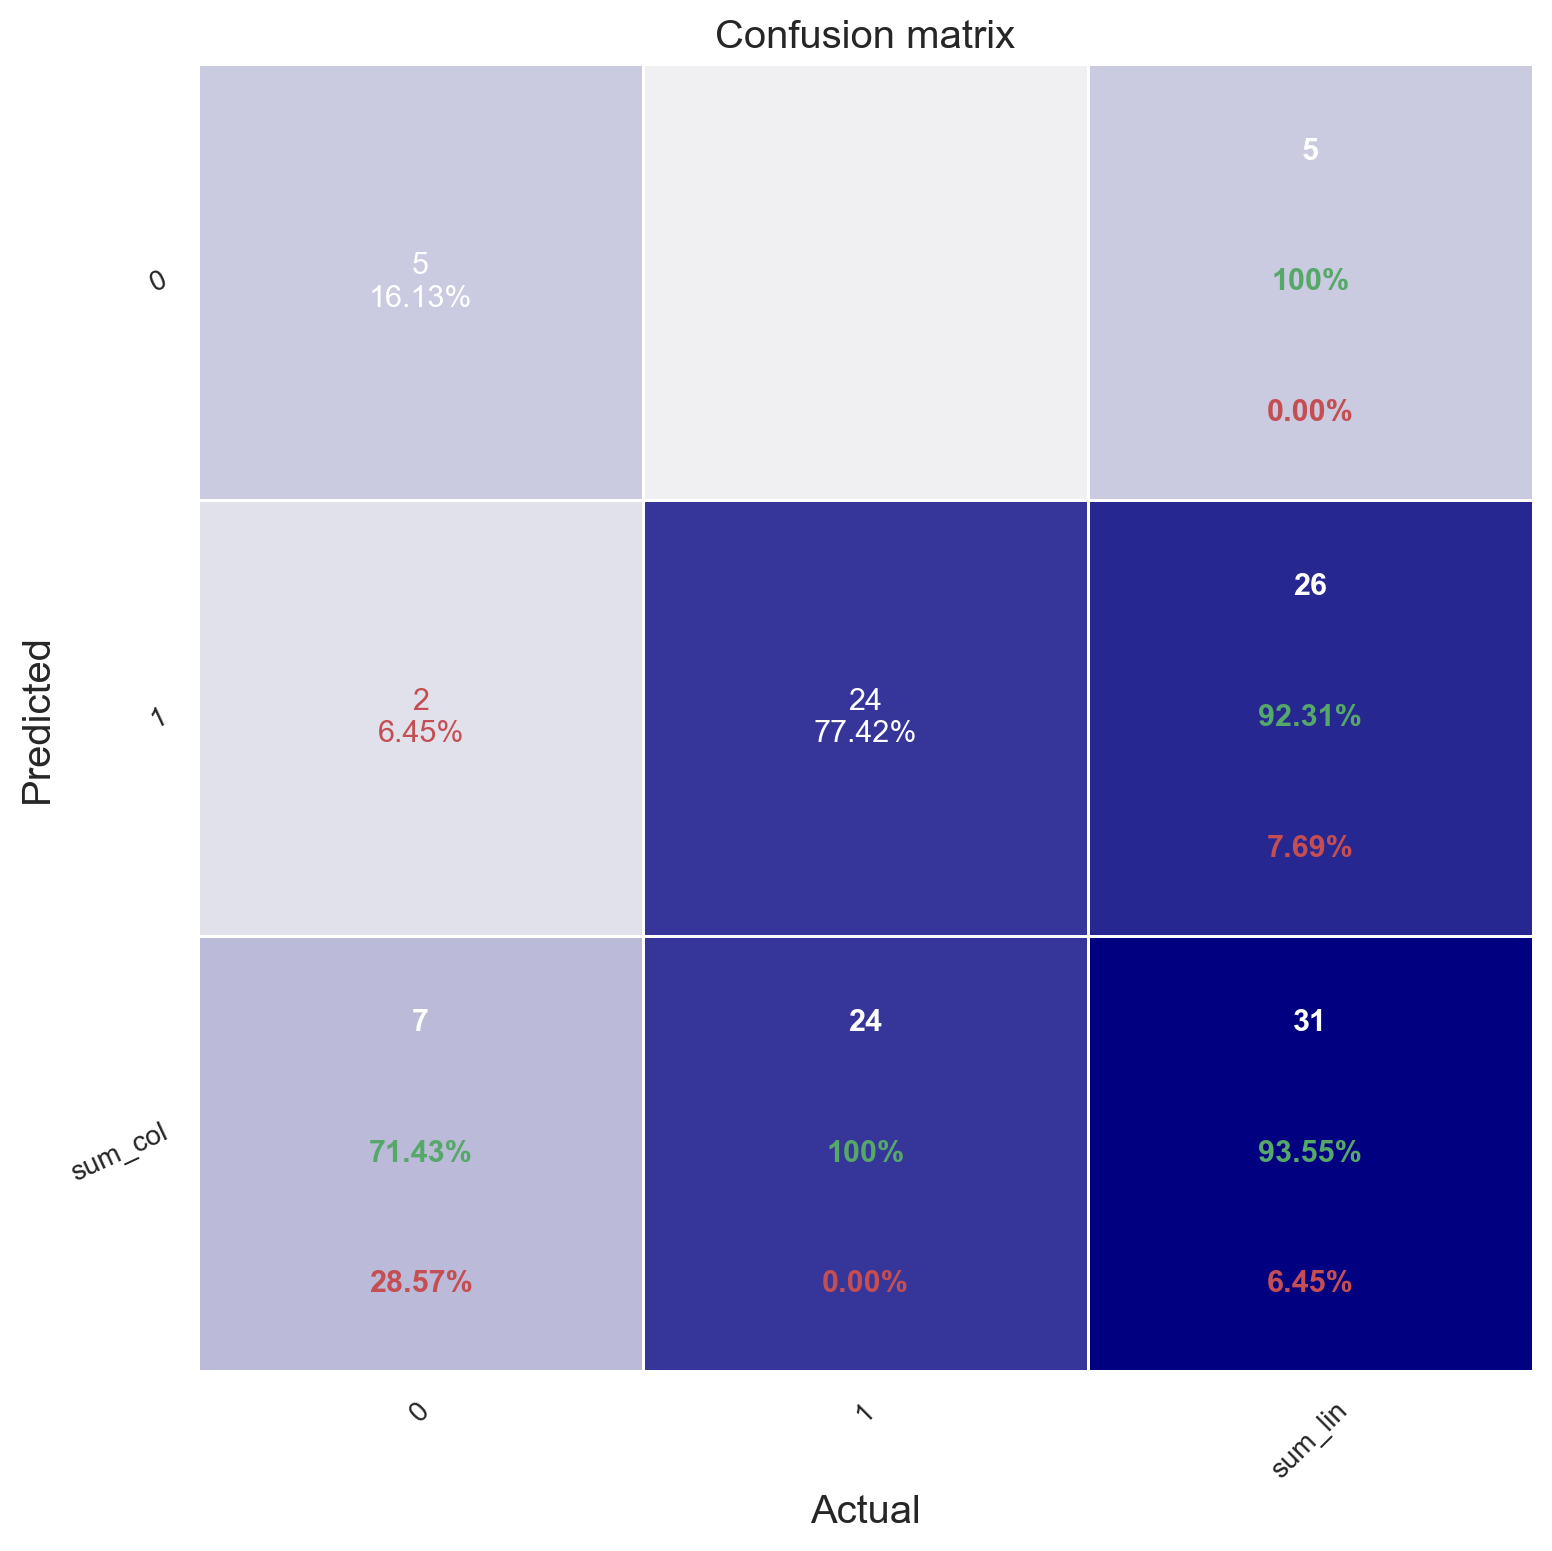

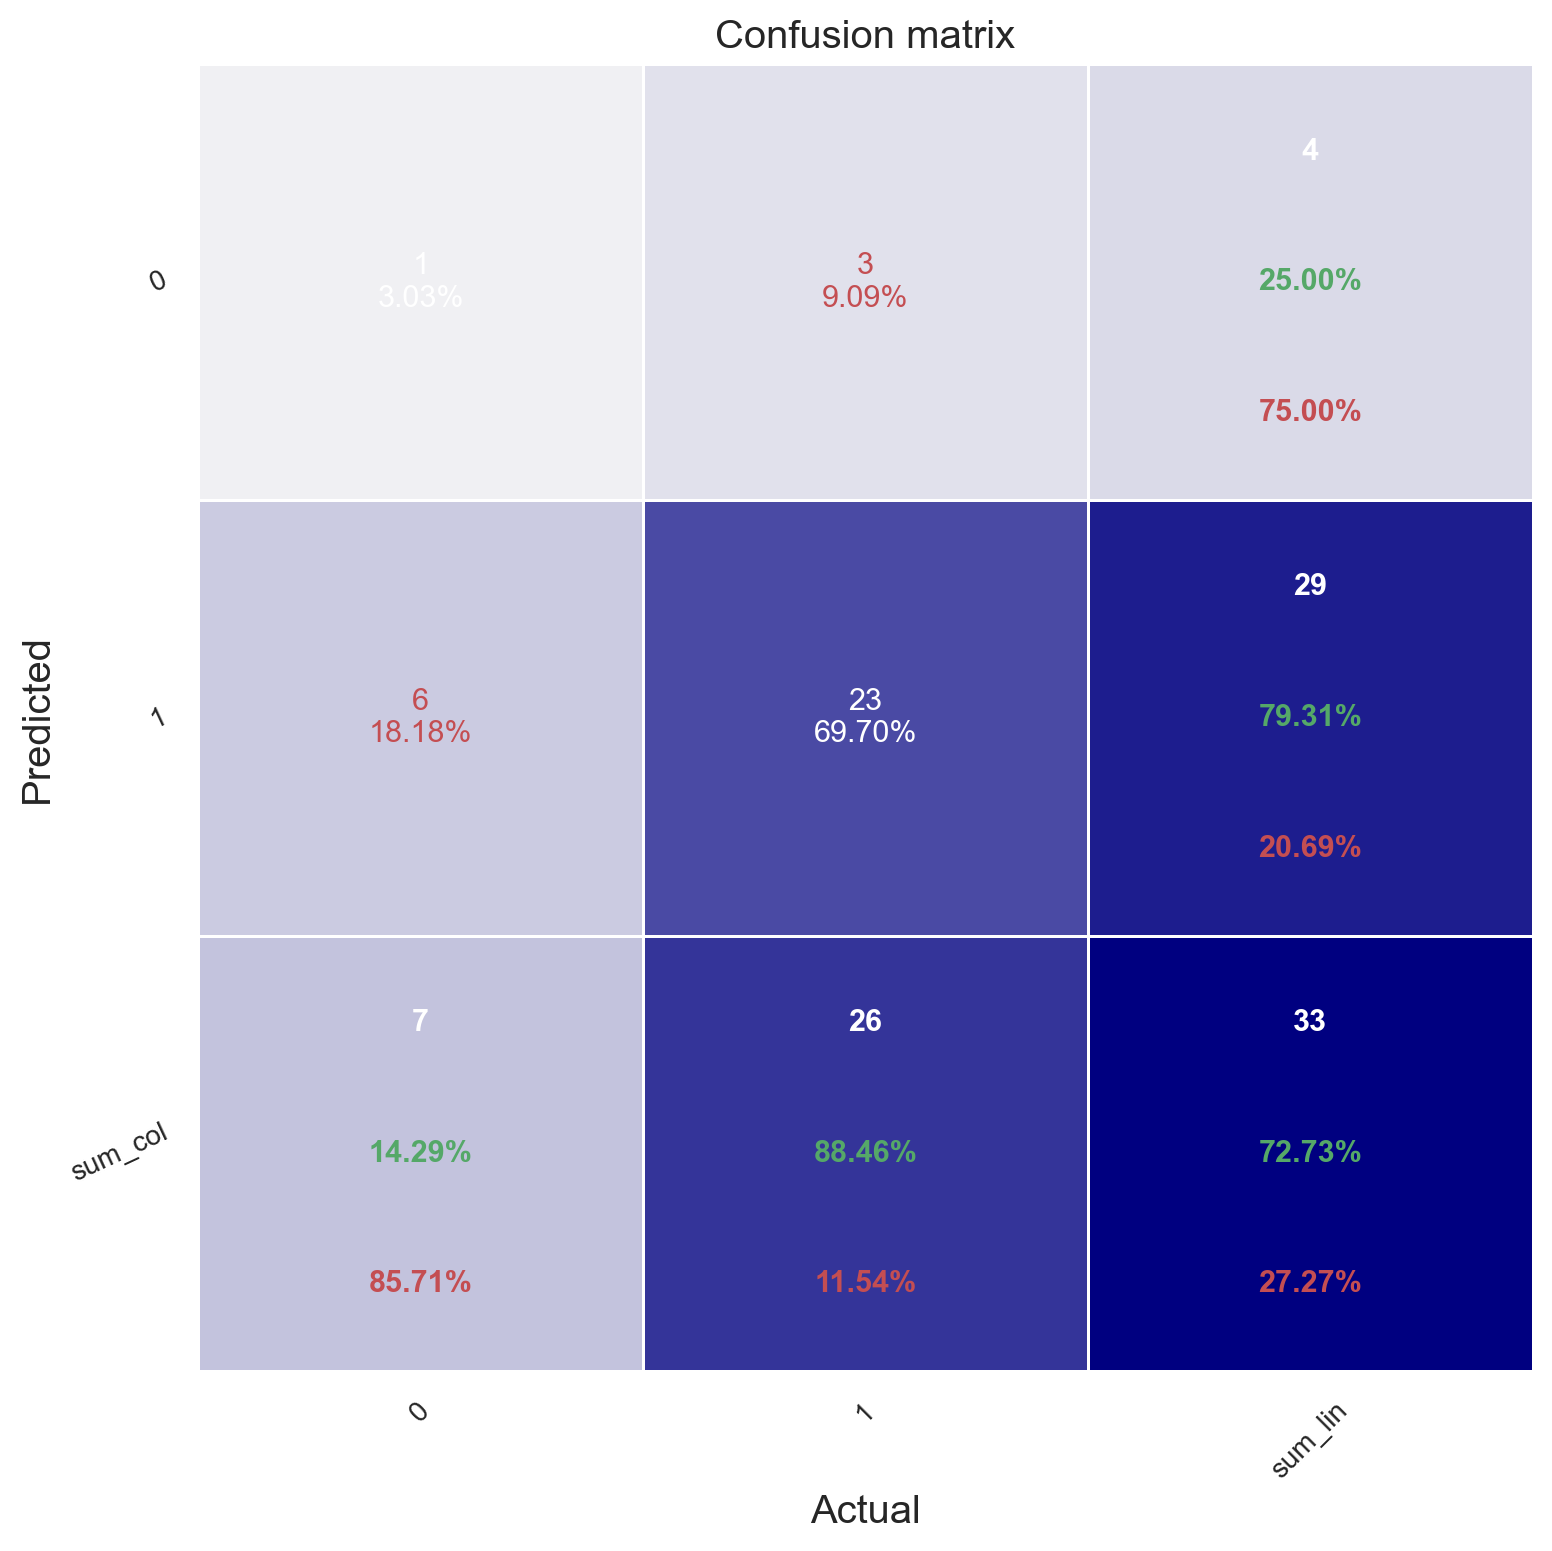

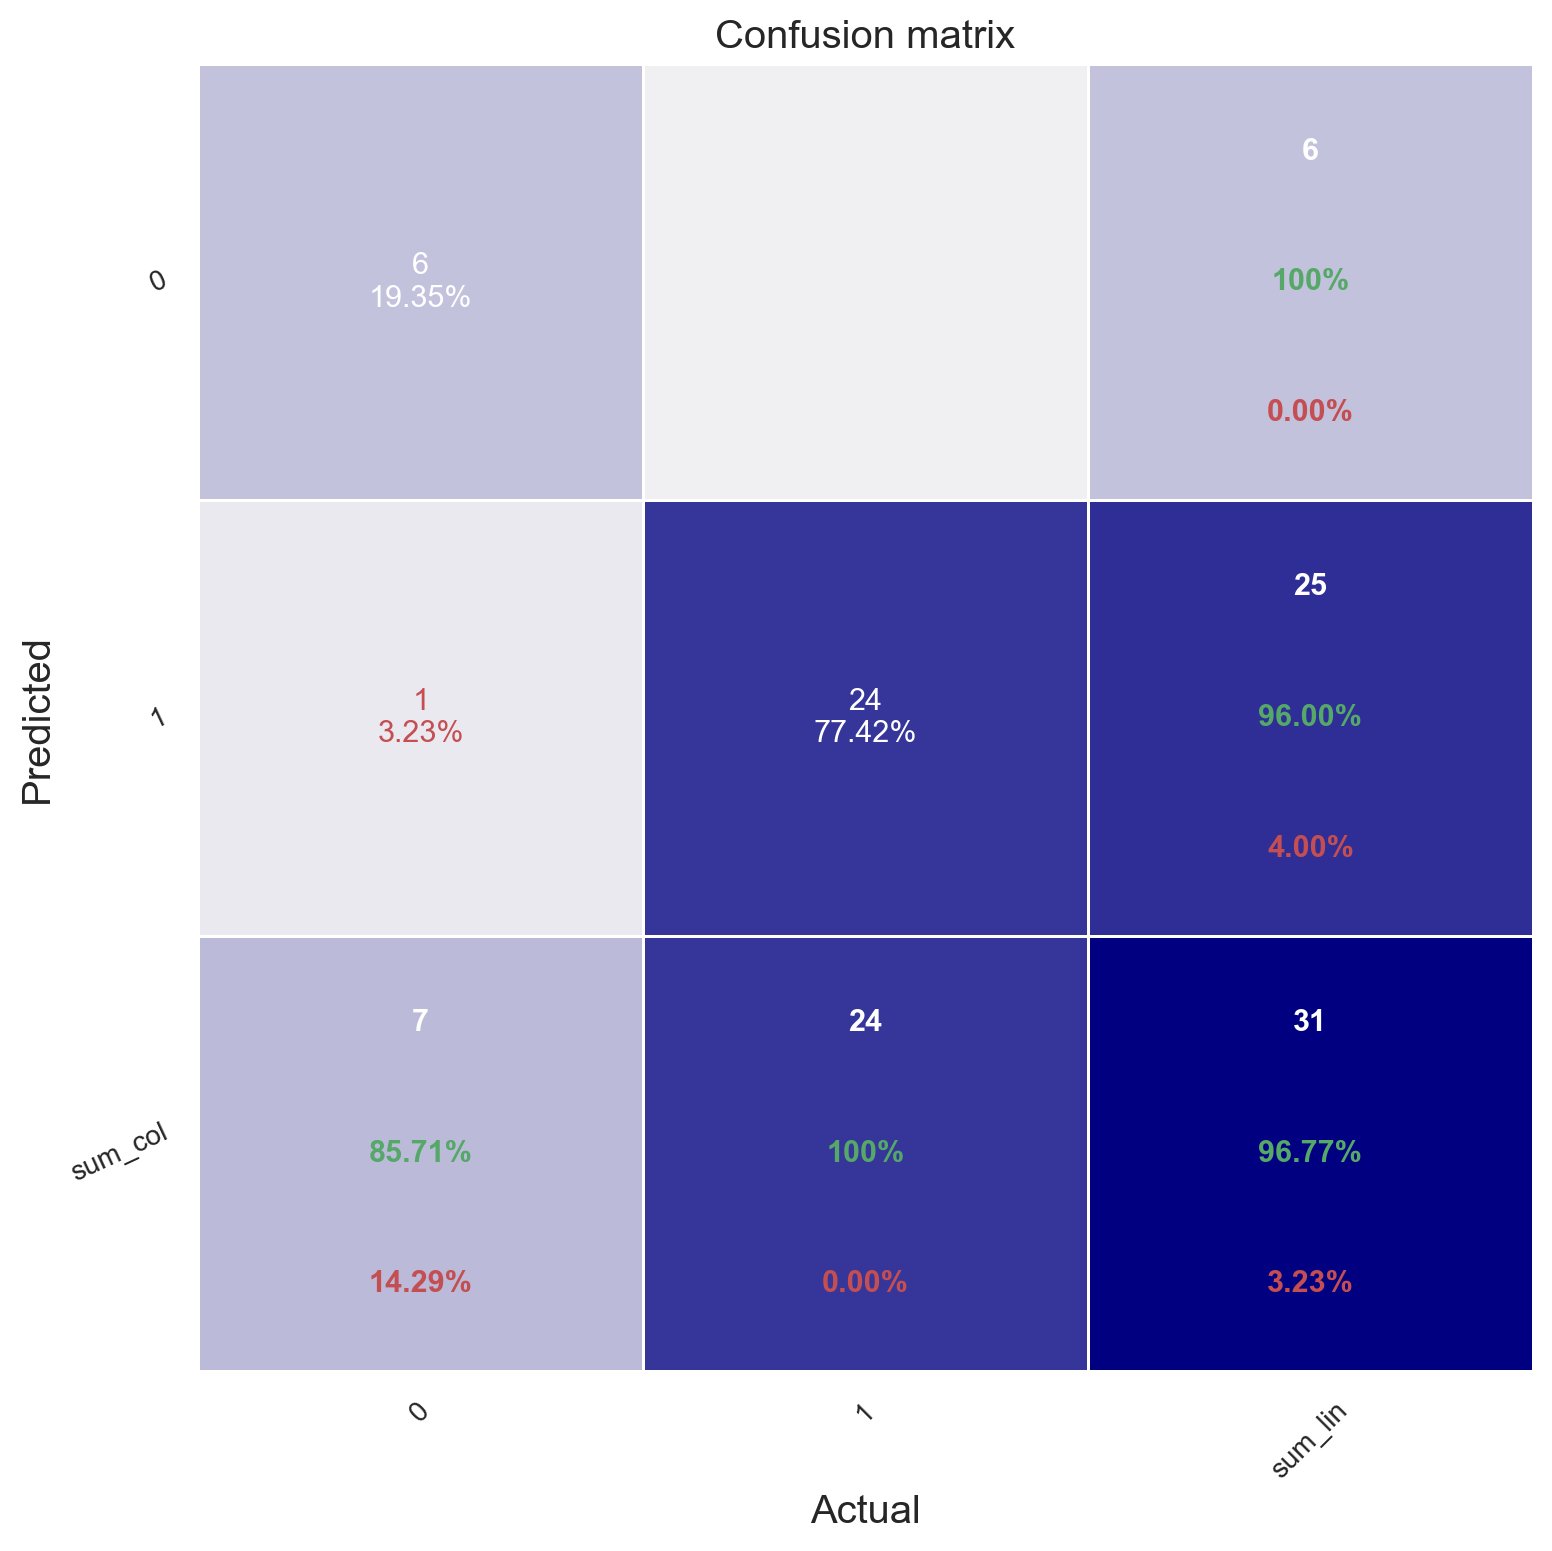

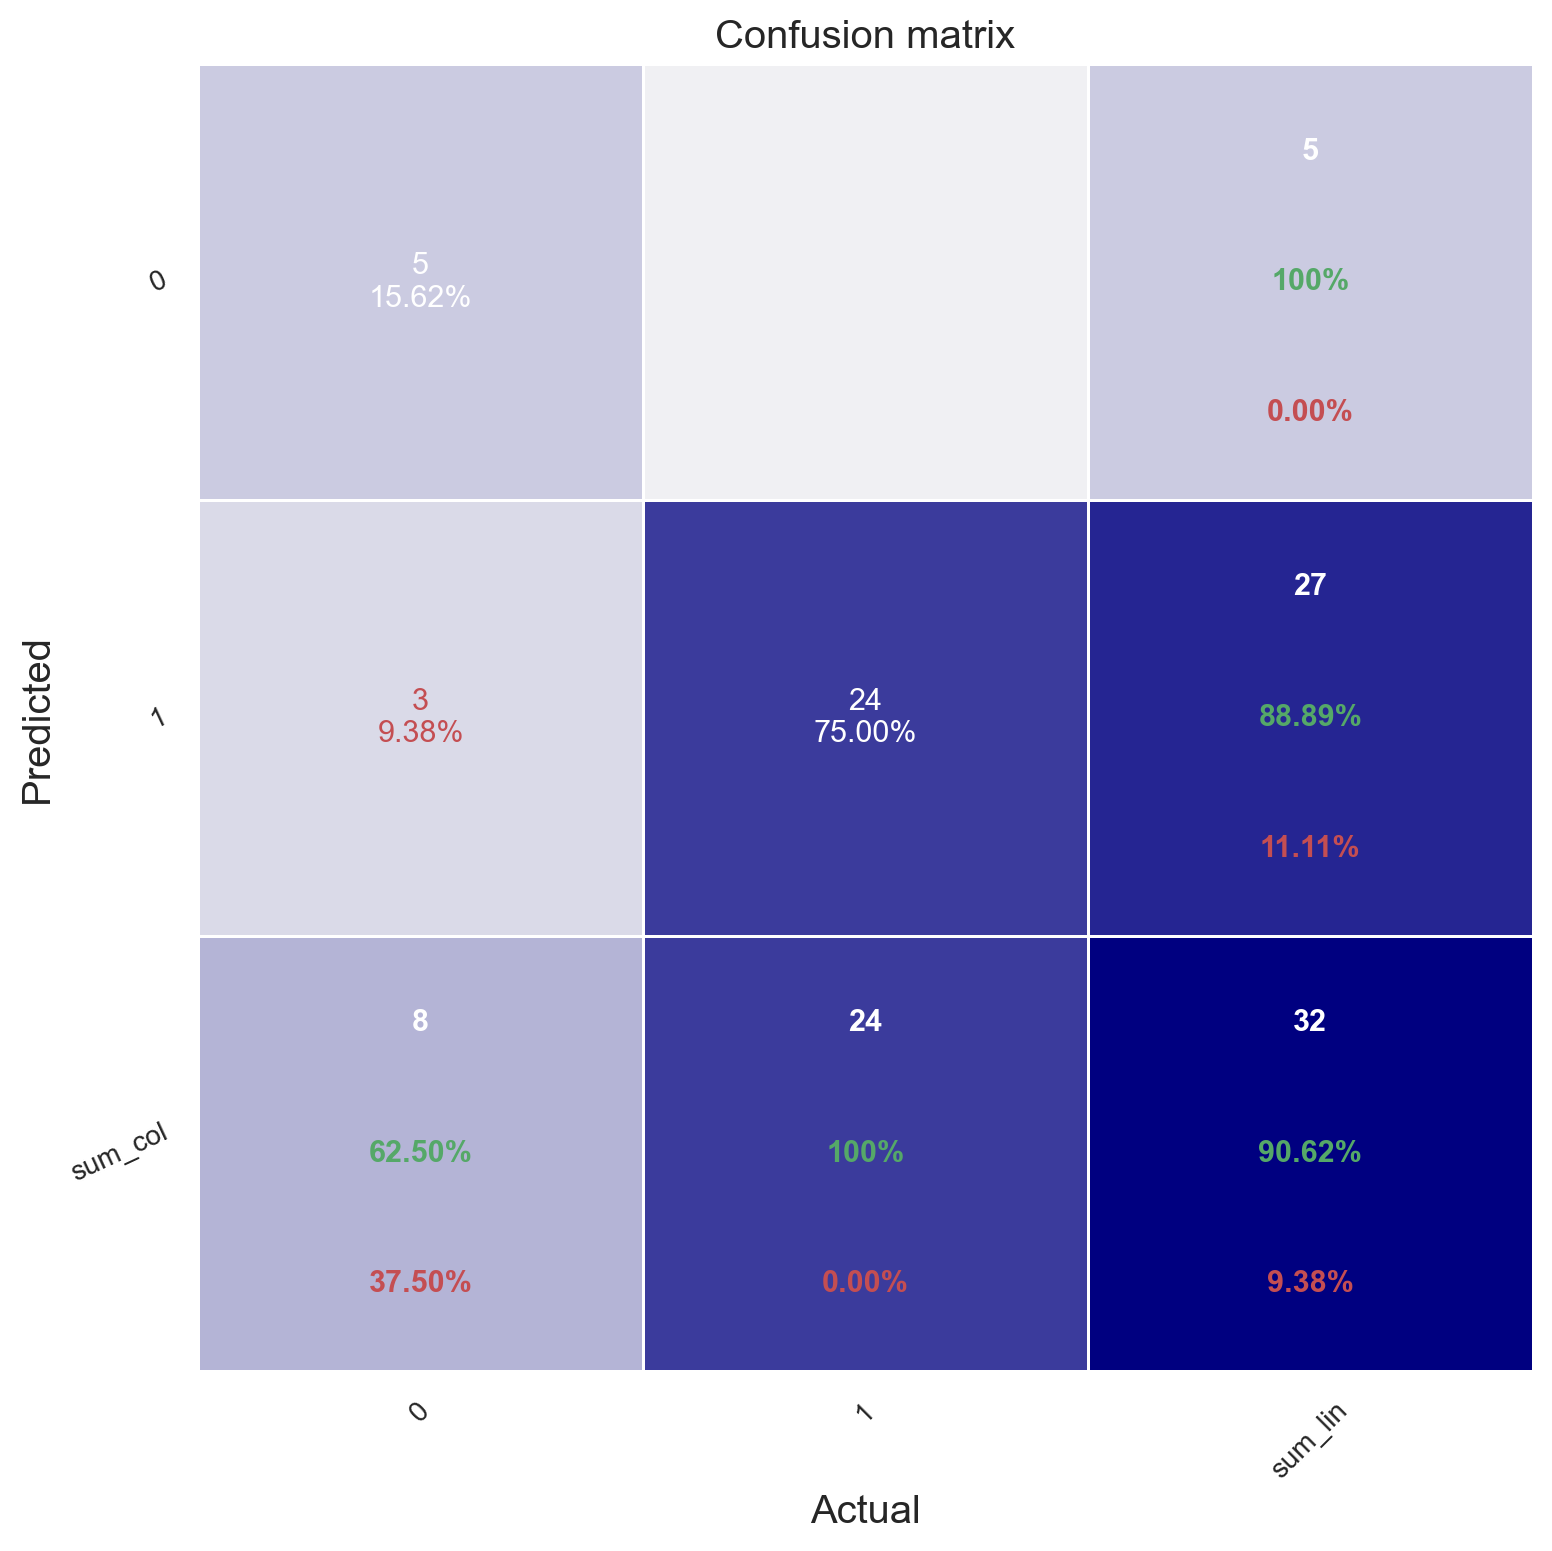

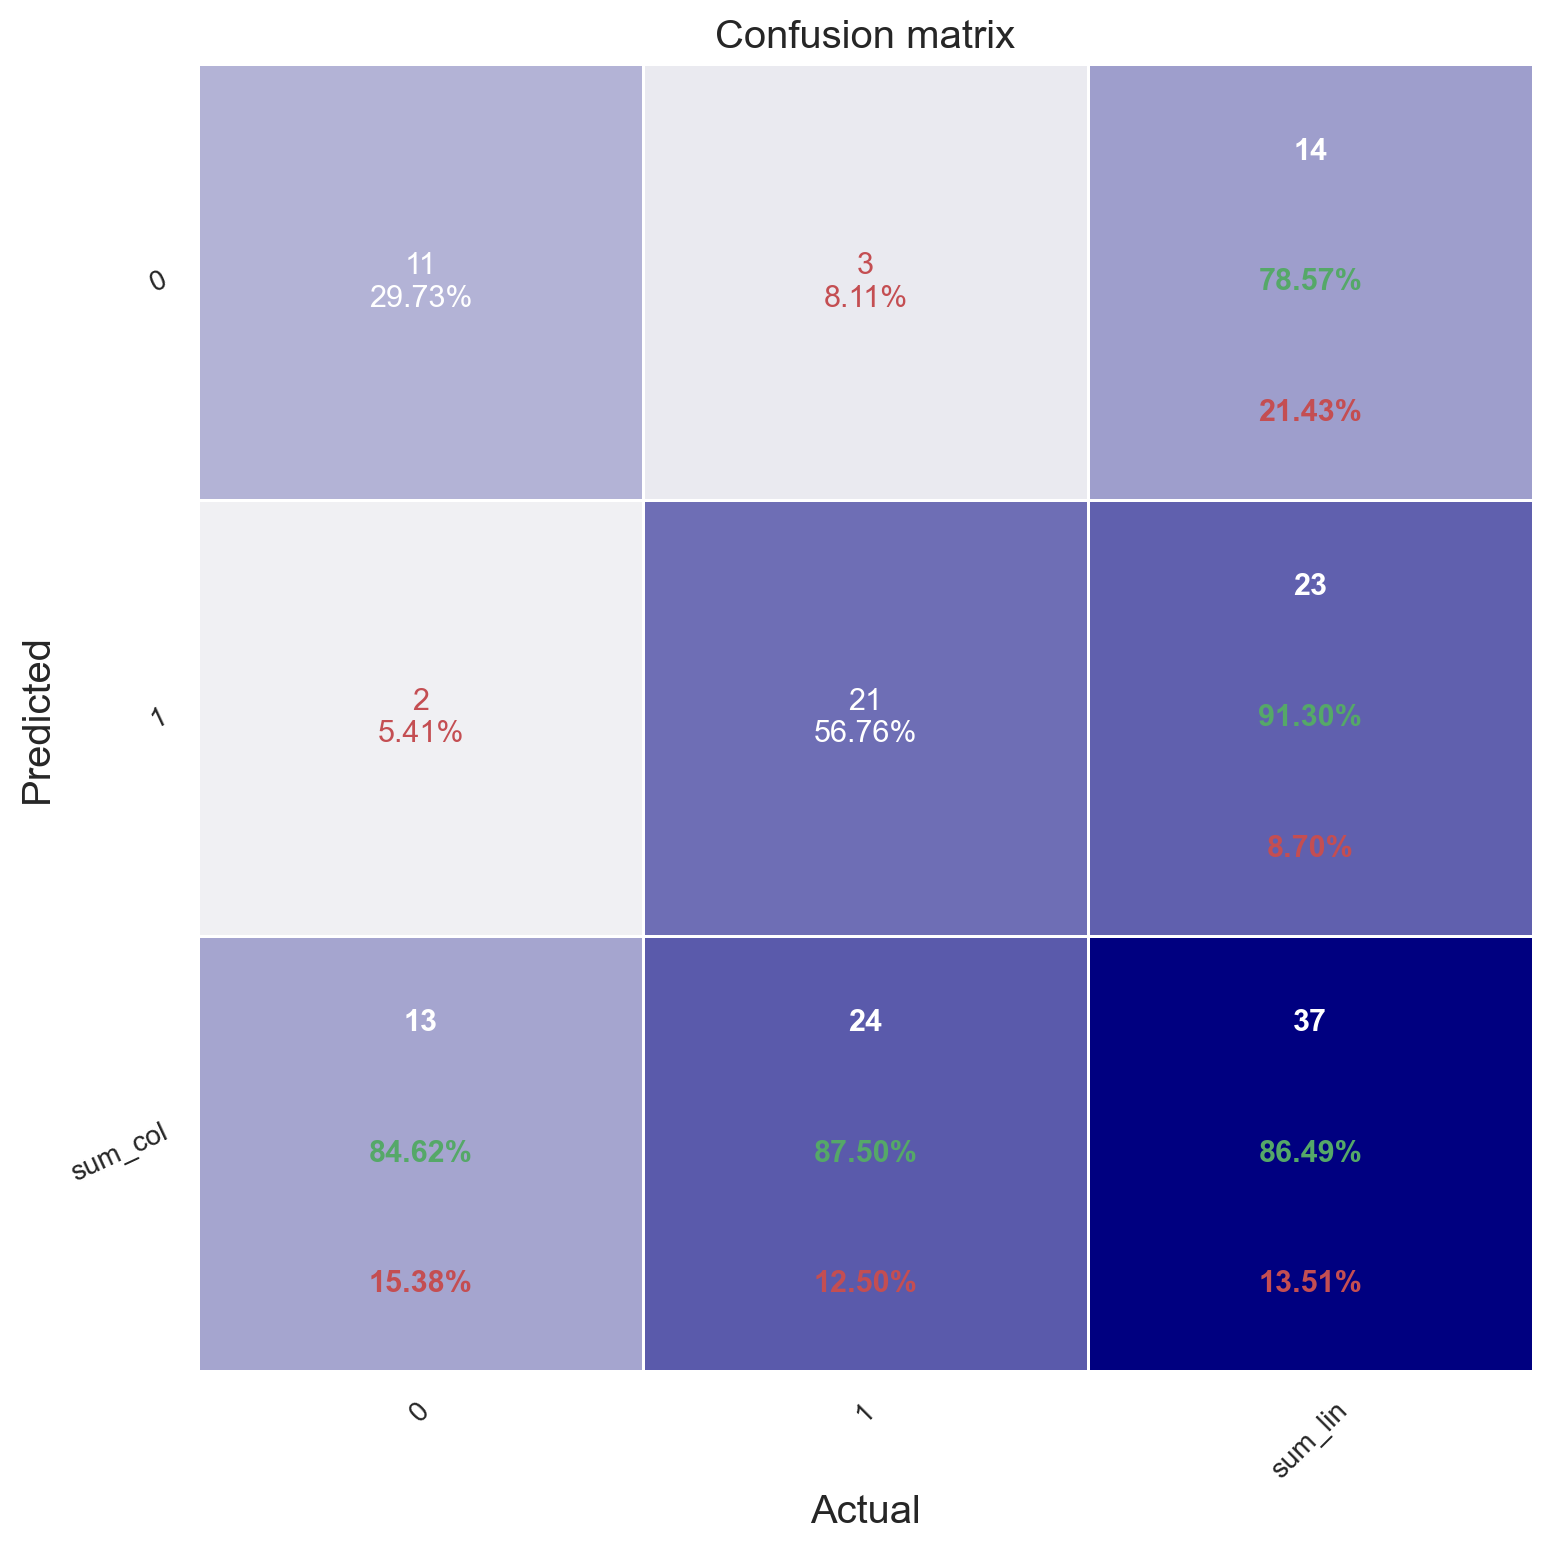

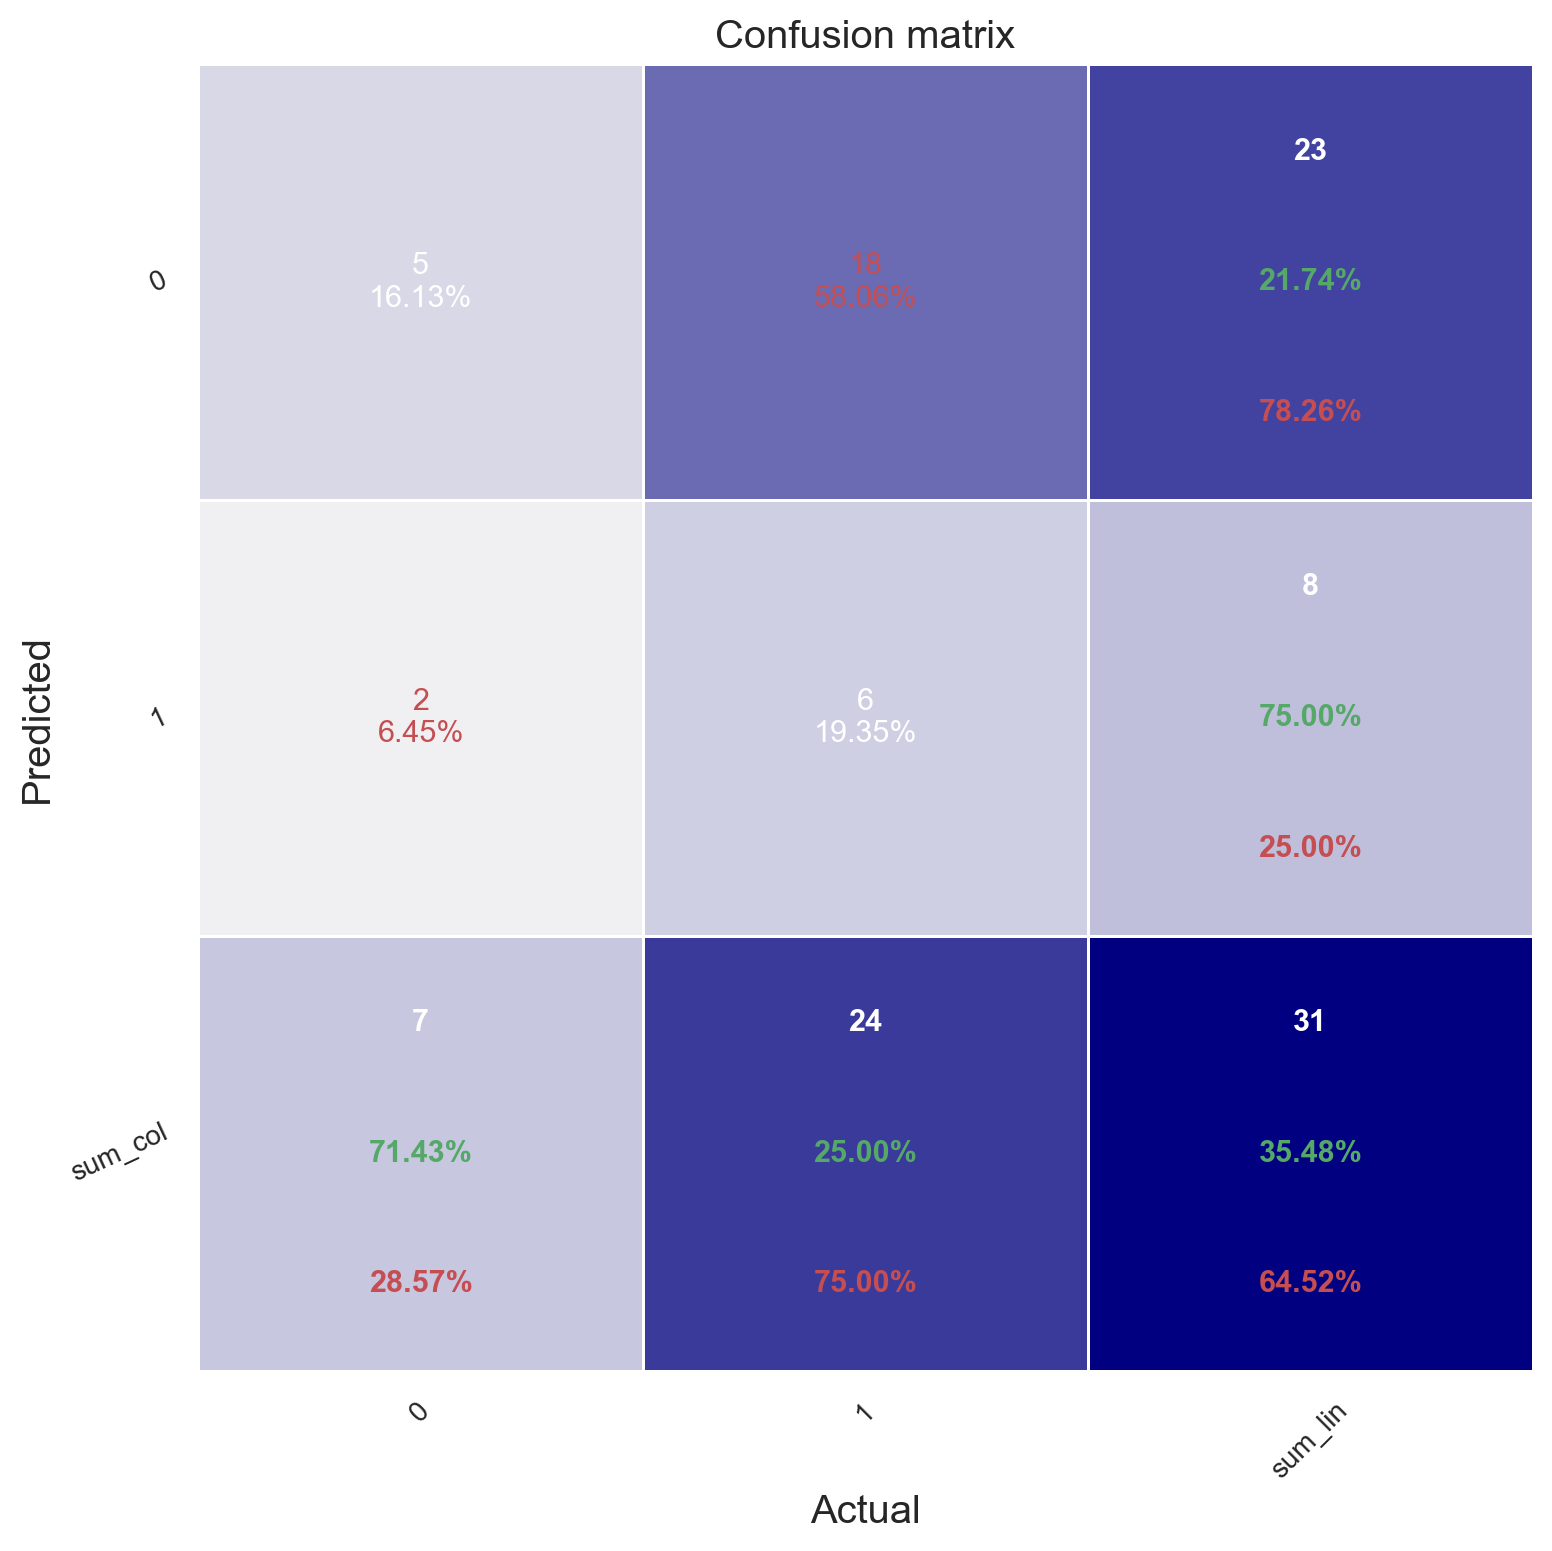

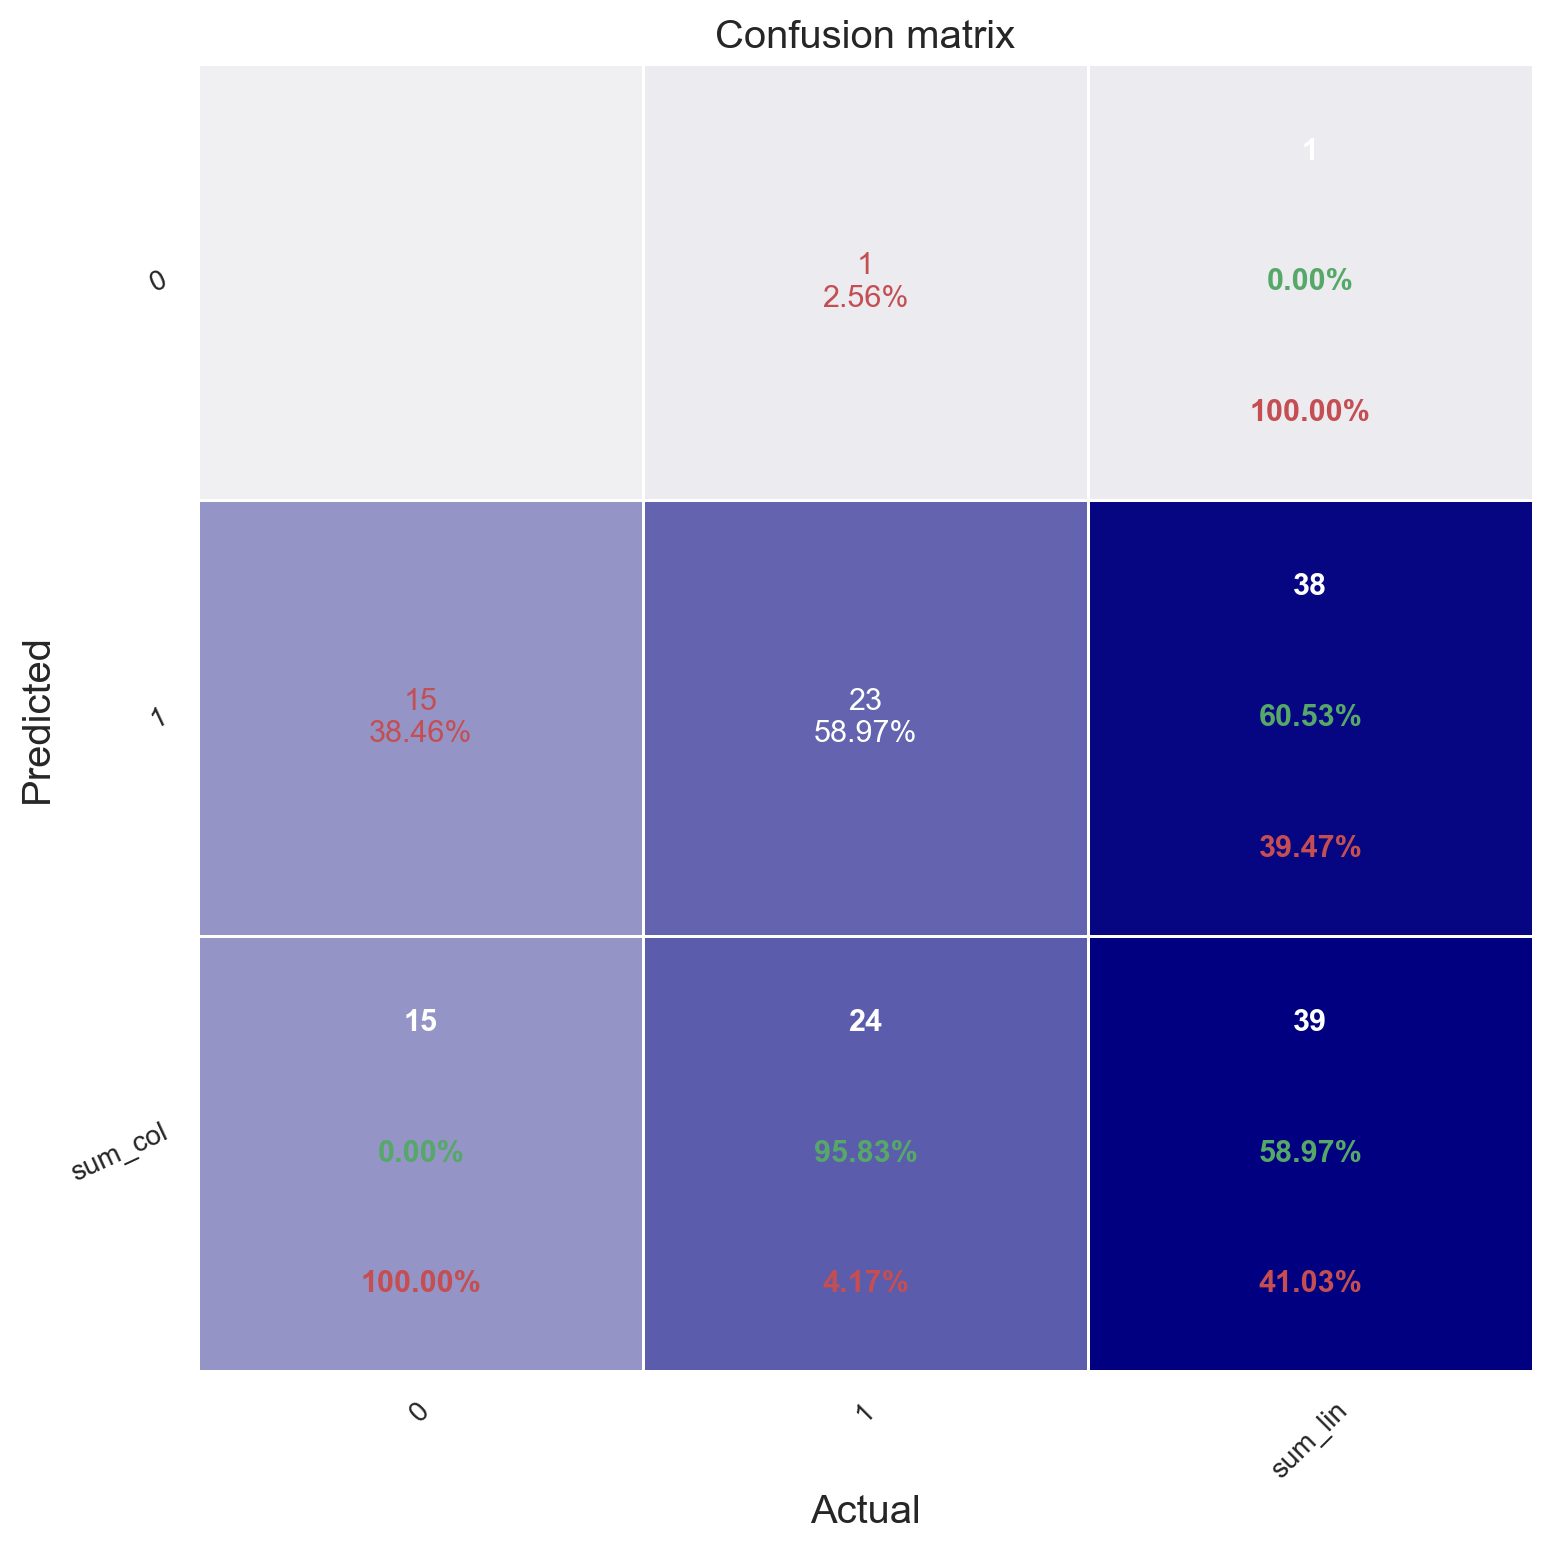

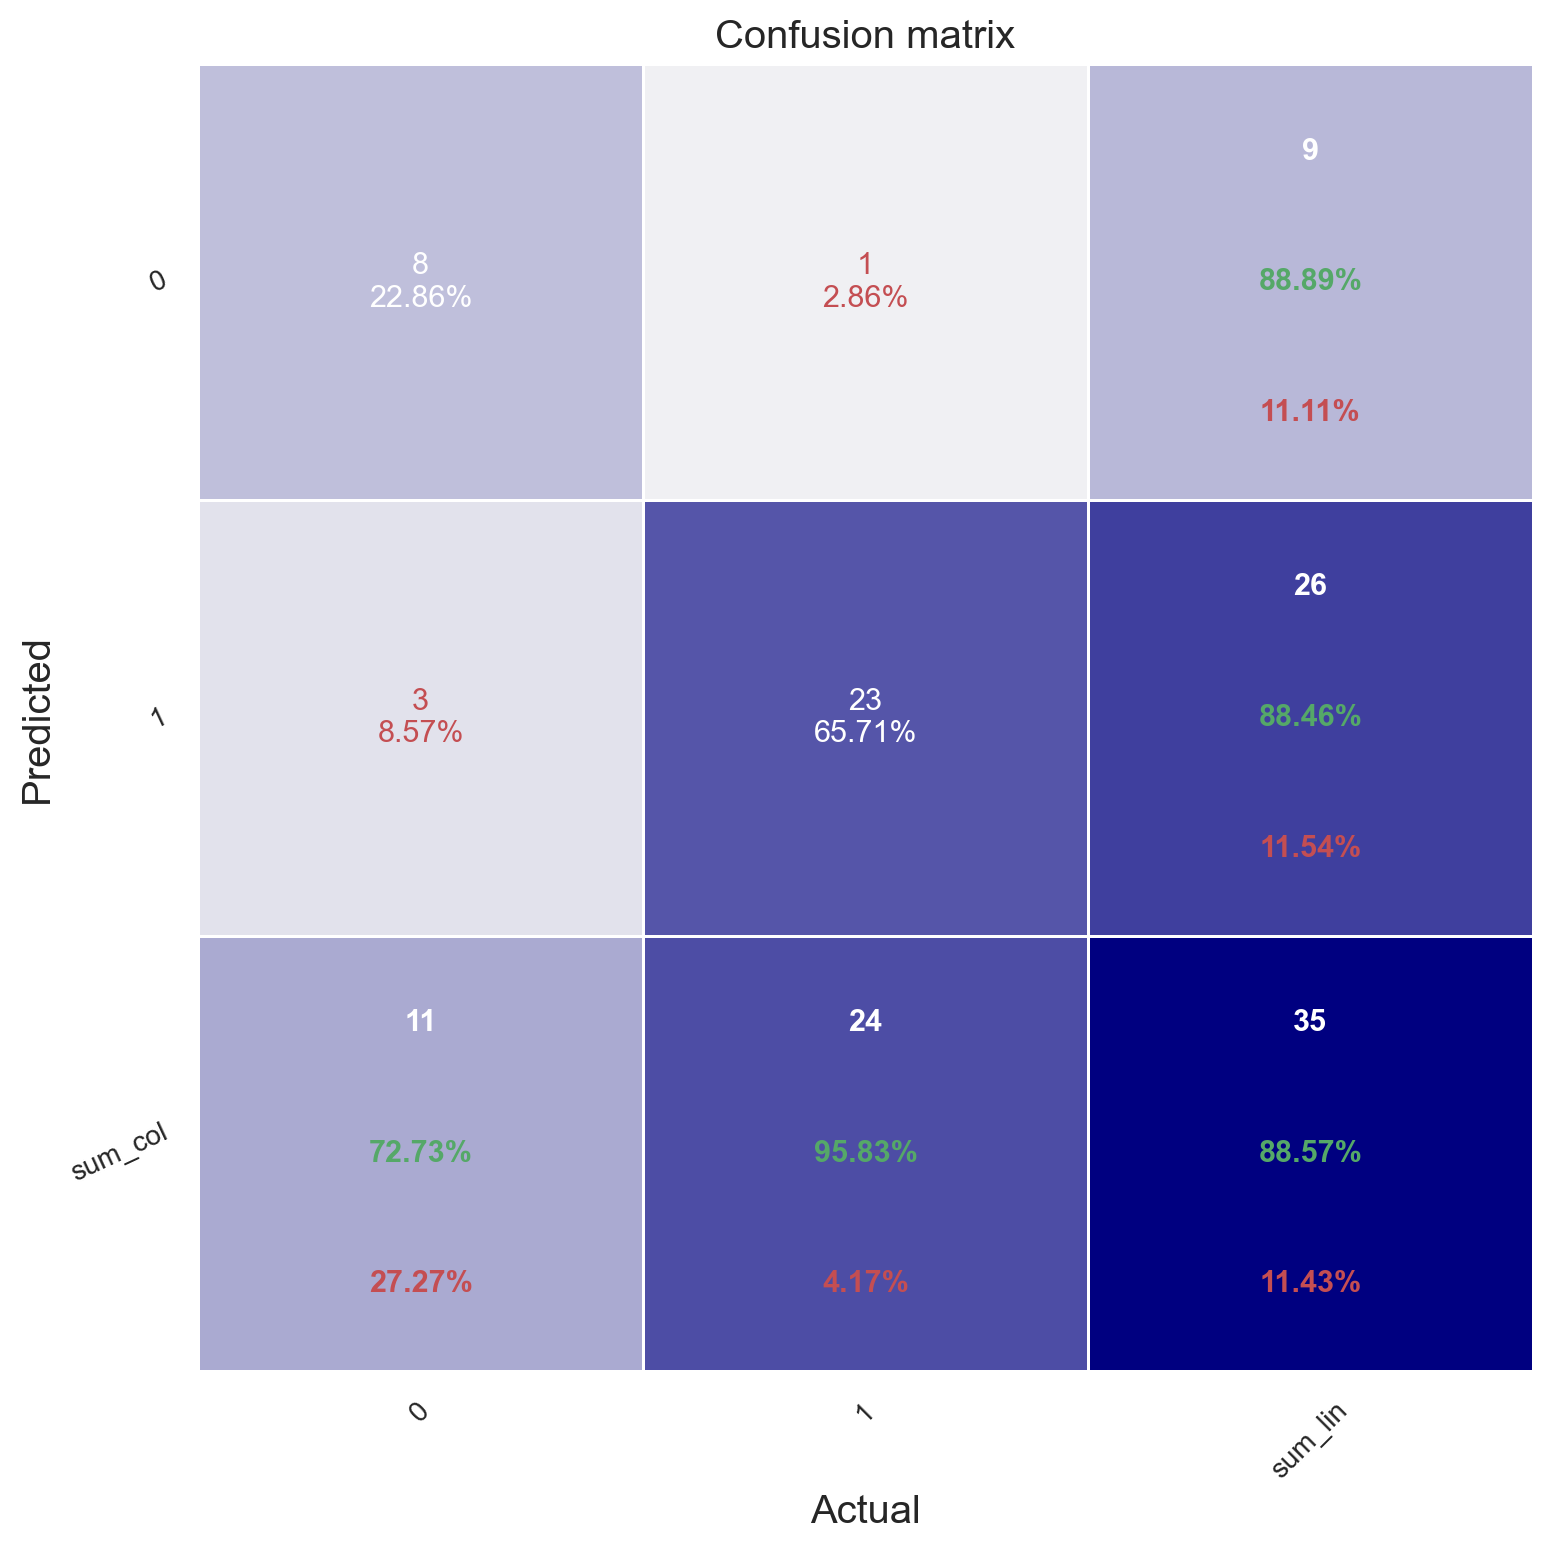

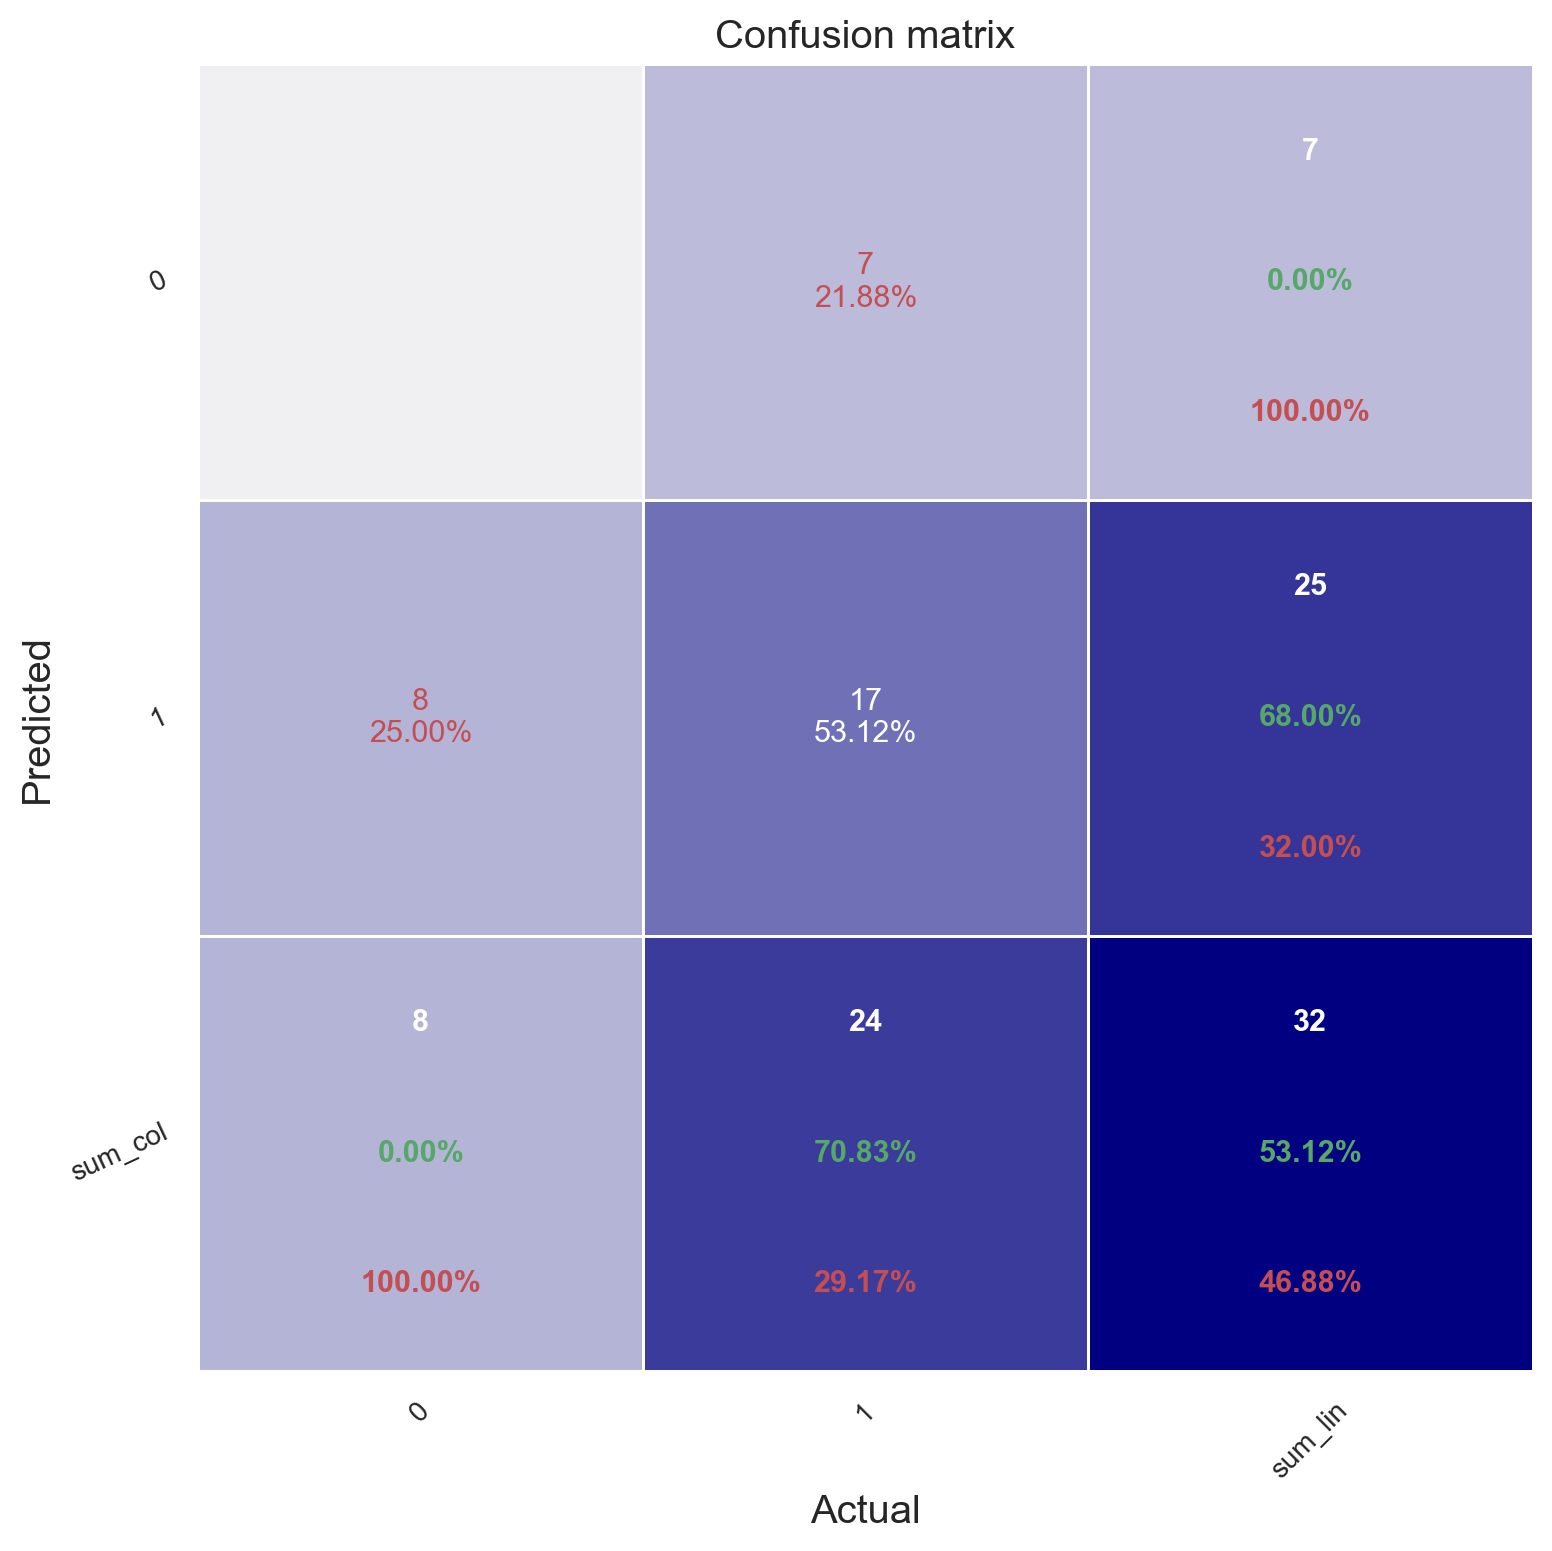

In [16]:
# ten-fold model metrics for evaluation 

f1_scores_0 = []
f1_scores_1 = []
mcc_scores_0 = []
mcc_scores_1 = []

multiple_model_metrics(models, y_test_list, y_pred_list, f1_scores_0, f1_scores_1, mcc_scores_0, mcc_scores_1)

# Create a dataframe with fold number as column and f1-score and mcc score for class 0 and 1  as columns and export to .csv file
df_metrics = pd.DataFrame({'f1_scores_0': f1_scores_0, 'f1_scores_1': f1_scores_1, 'mcc_scores_0': mcc_scores_0, 'mcc_scores_1': mcc_scores_1})
# Add fold number as column
df_metrics['fold'] = df_metrics.index

# Round all columns to two decimals
df_metrics = df_metrics.round(2)

df_metrics.to_csv(TARGET_DIR + 'mcc_f1_metrics.csv', index=False)

(0.807040737040737,
 array([0.  , 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1 ,
        0.11, 0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2 , 0.21,
        0.22, 0.23, 0.24, 0.25, 0.26, 0.27, 0.28, 0.29, 0.3 , 0.31, 0.32,
        0.33, 0.34, 0.35, 0.36, 0.37, 0.38, 0.39, 0.4 , 0.41, 0.42, 0.43,
        0.44, 0.45, 0.46, 0.47, 0.48, 0.49, 0.5 , 0.51, 0.52, 0.53, 0.54,
        0.55, 0.56, 0.57, 0.58, 0.59, 0.6 , 0.61, 0.62, 0.63, 0.64, 0.65,
        0.66, 0.67, 0.68, 0.69, 0.7 , 0.71, 0.72, 0.73, 0.74, 0.75, 0.76,
        0.77, 0.78, 0.79, 0.8 , 0.81, 0.82, 0.83, 0.84, 0.85, 0.86, 0.87,
        0.88, 0.89, 0.9 , 0.91, 0.92, 0.93, 0.94, 0.95, 0.96, 0.97, 0.98,
        0.99, 1.  ]),
 array([0.        , 0.61987179, 0.61987179, 0.61987179, 0.61987179,
        0.61987179, 0.61987179, 0.61987179, 0.61987179, 0.61987179,
        0.61987179, 0.61987179, 0.61987179, 0.68237179, 0.68237179,
        0.69455128, 0.70288462, 0.70288462, 0.70288462, 0.70288462,
        0.70288462, 

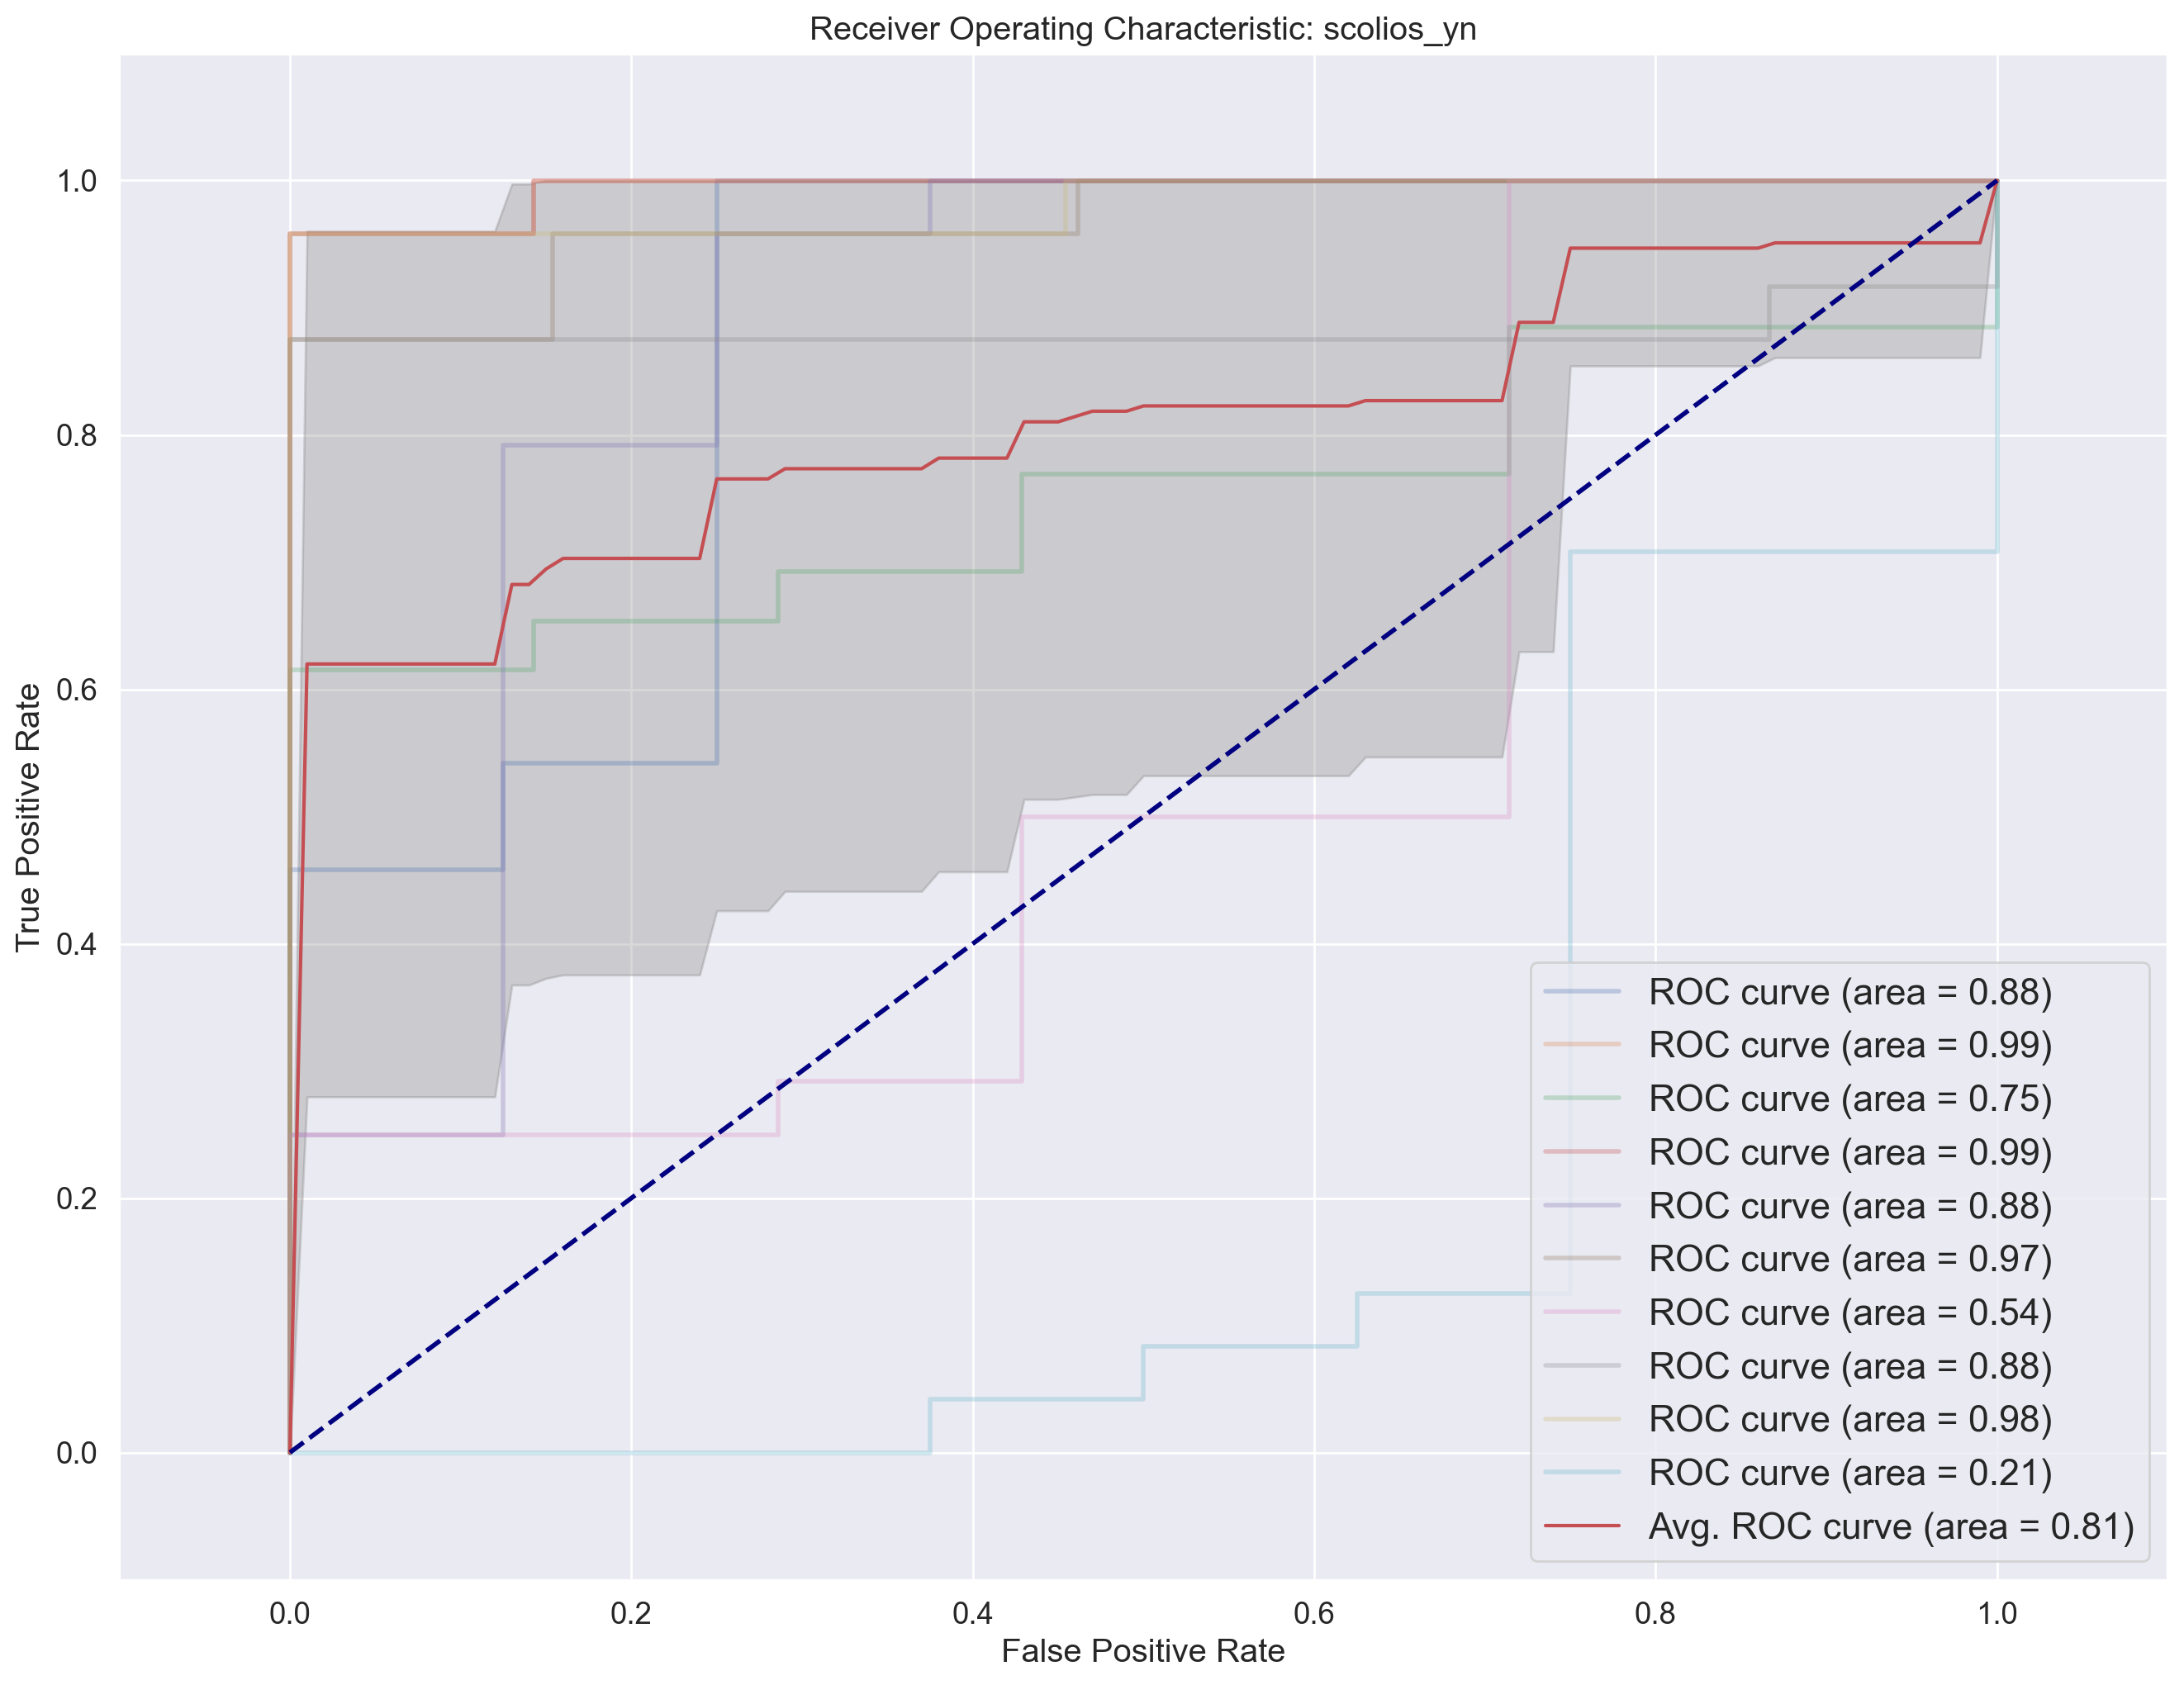

In [17]:
# Plot ROC curves for each fold 
plots.plot_rfc_roc_curve(y_test_list, [el[:, 1] for el in y_pred_proba_list], fn=TARGET_DIR + "Model_pred_proba_roc.pdf", field="scolios_yn")

# Data set statistics for PredictX Paper


In [18]:
""" 
Get statistics on the actual training data 
"""
# Perform missing analysis in the df_train 
from pandas_summary import DataFrameSummary

dfs_train = DataFrameSummary(df_train[selected_features])

dfs_train.columns_stats#[selected_features]

age_assess ventilation_term orthoses_score contractures_score   
counts              333              332            333                333  \
uniques             312                8             24                 39   
missing               0                1              0                  0   
missing_perc         0%            0.30%             0%                 0%   
types           numeric          numeric        numeric            numeric   

             hfmse_motor_score chop_motor_score  
counts                     217              206  
uniques                     77               75  
missing                    116              127  
missing_perc            34.83%           38.14%  
types                  numeric          numeric

In [19]:
# Number of patients who have the LABEL SCOLIOSIS in the whole data set 
counts = df_train['scoliosis_yn'].value_counts(dropna=False)
percs = df_train['scoliosis_yn'].value_counts(normalize=True, dropna=False).mul(100).round(1).astype(str) + '%'

stats = pd.concat([counts,percs], axis=1, keys=['count', 'percentage'])
stats

count percentage
scoliosis_yn                  
1.0             242      72.7%
0.0              91      27.3%

In [20]:
df_train[['sma_type', 'scoliosis_yn']].groupby('sma_type', dropna=False).describe()

scoliosis_yn                                             
                count      mean       std  min  25%  50%  75%  max
sma_type                                                          
1.0             104.0  0.615385  0.488860  0.0  0.0  1.0  1.0  1.0
2.0             147.0  0.891156  0.312508  0.0  1.0  1.0  1.0  1.0
3.0              82.0  0.573171  0.497661  0.0  0.0  1.0  1.0  1.0

In [21]:
# Statistics on df_therapy_first 
# RUN to show relevant columns: dtale.show(df_first[['record_id', 'sma_type', 'therapy_arr', 'therapy_score']])

counts = df_train['therapy_score'].value_counts()
percs = df_train['therapy_score'].value_counts(normalize=True).mul(100).round(1).astype(str) + '%'

quickstat = pd.concat([counts,percs], axis=1, keys=['count', 'percentage'])

quickstat.describe()
# Data Dictionary: {"1" : "NUS", "2" : "RIS", "3": "NUS + RIS", "4" : "ONA", "5" : "NUS + ONA", "6" : "ONA + RIS", "-1" : "Unknown"}

count
count    7.000000
mean    47.571429
std     69.584139
min      5.000000
25%     10.000000
50%     27.000000
75%     39.500000
max    202.000000

In [22]:
# Statistics on df_therapy_last

counts = df_train['therapy_score'].value_counts()
percs = df_train['therapy_score'].value_counts(normalize=True).mul(100).round(1).astype(str) + '%'
quickstat = pd.concat([counts,percs], axis=1, keys=['count', 'percentage'])
quickstat 
# Data Dictionary: {"1" : "NUS", "2" : "RIS", "3": "NUS + RIS", "4" : "ONA", "5" : "NUS + ONA", "6" : "ONA + RIS", "-1" : "Unknown"}

count percentage
therapy_score                  
1                202      60.7%
5                 42      12.6%
3                 37      11.1%
4                 27       8.1%
0                 11       3.3%
6                  9       2.7%
2                  5       1.5%

# Train Model and plot multiple train folds


In [23]:
# Load data and define groups 

# Features
X = df_train[traincols].fillna(value=-1) # This is the feature_names for feature importance
feature_names = X.columns
# Target 
y = df_train[label].values 
# Groups
groups = df_train['record_id'].values

sc = StandardScaler()
sc.fit(X)
X = sc.transform(X)
print(sc)

StandardScaler()


For Random State 20.000000 | avg ROC score 0.811281
For Random State 21.000000 | avg ROC score 0.823695
For Random State 22.000000 | avg ROC score 0.810980
For Random State 23.000000 | avg ROC score 0.807041
For Random State 24.000000 | avg ROC score 0.813738
For Random State 25.000000 | avg ROC score 0.827723
For Random State 26.000000 | avg ROC score 0.818410
For Random State 27.000000 | avg ROC score 0.811067
For Random State 28.000000 | avg ROC score 0.833071
For Random State 29.000000 | avg ROC score 0.798005
Average AUC score: 0.815501


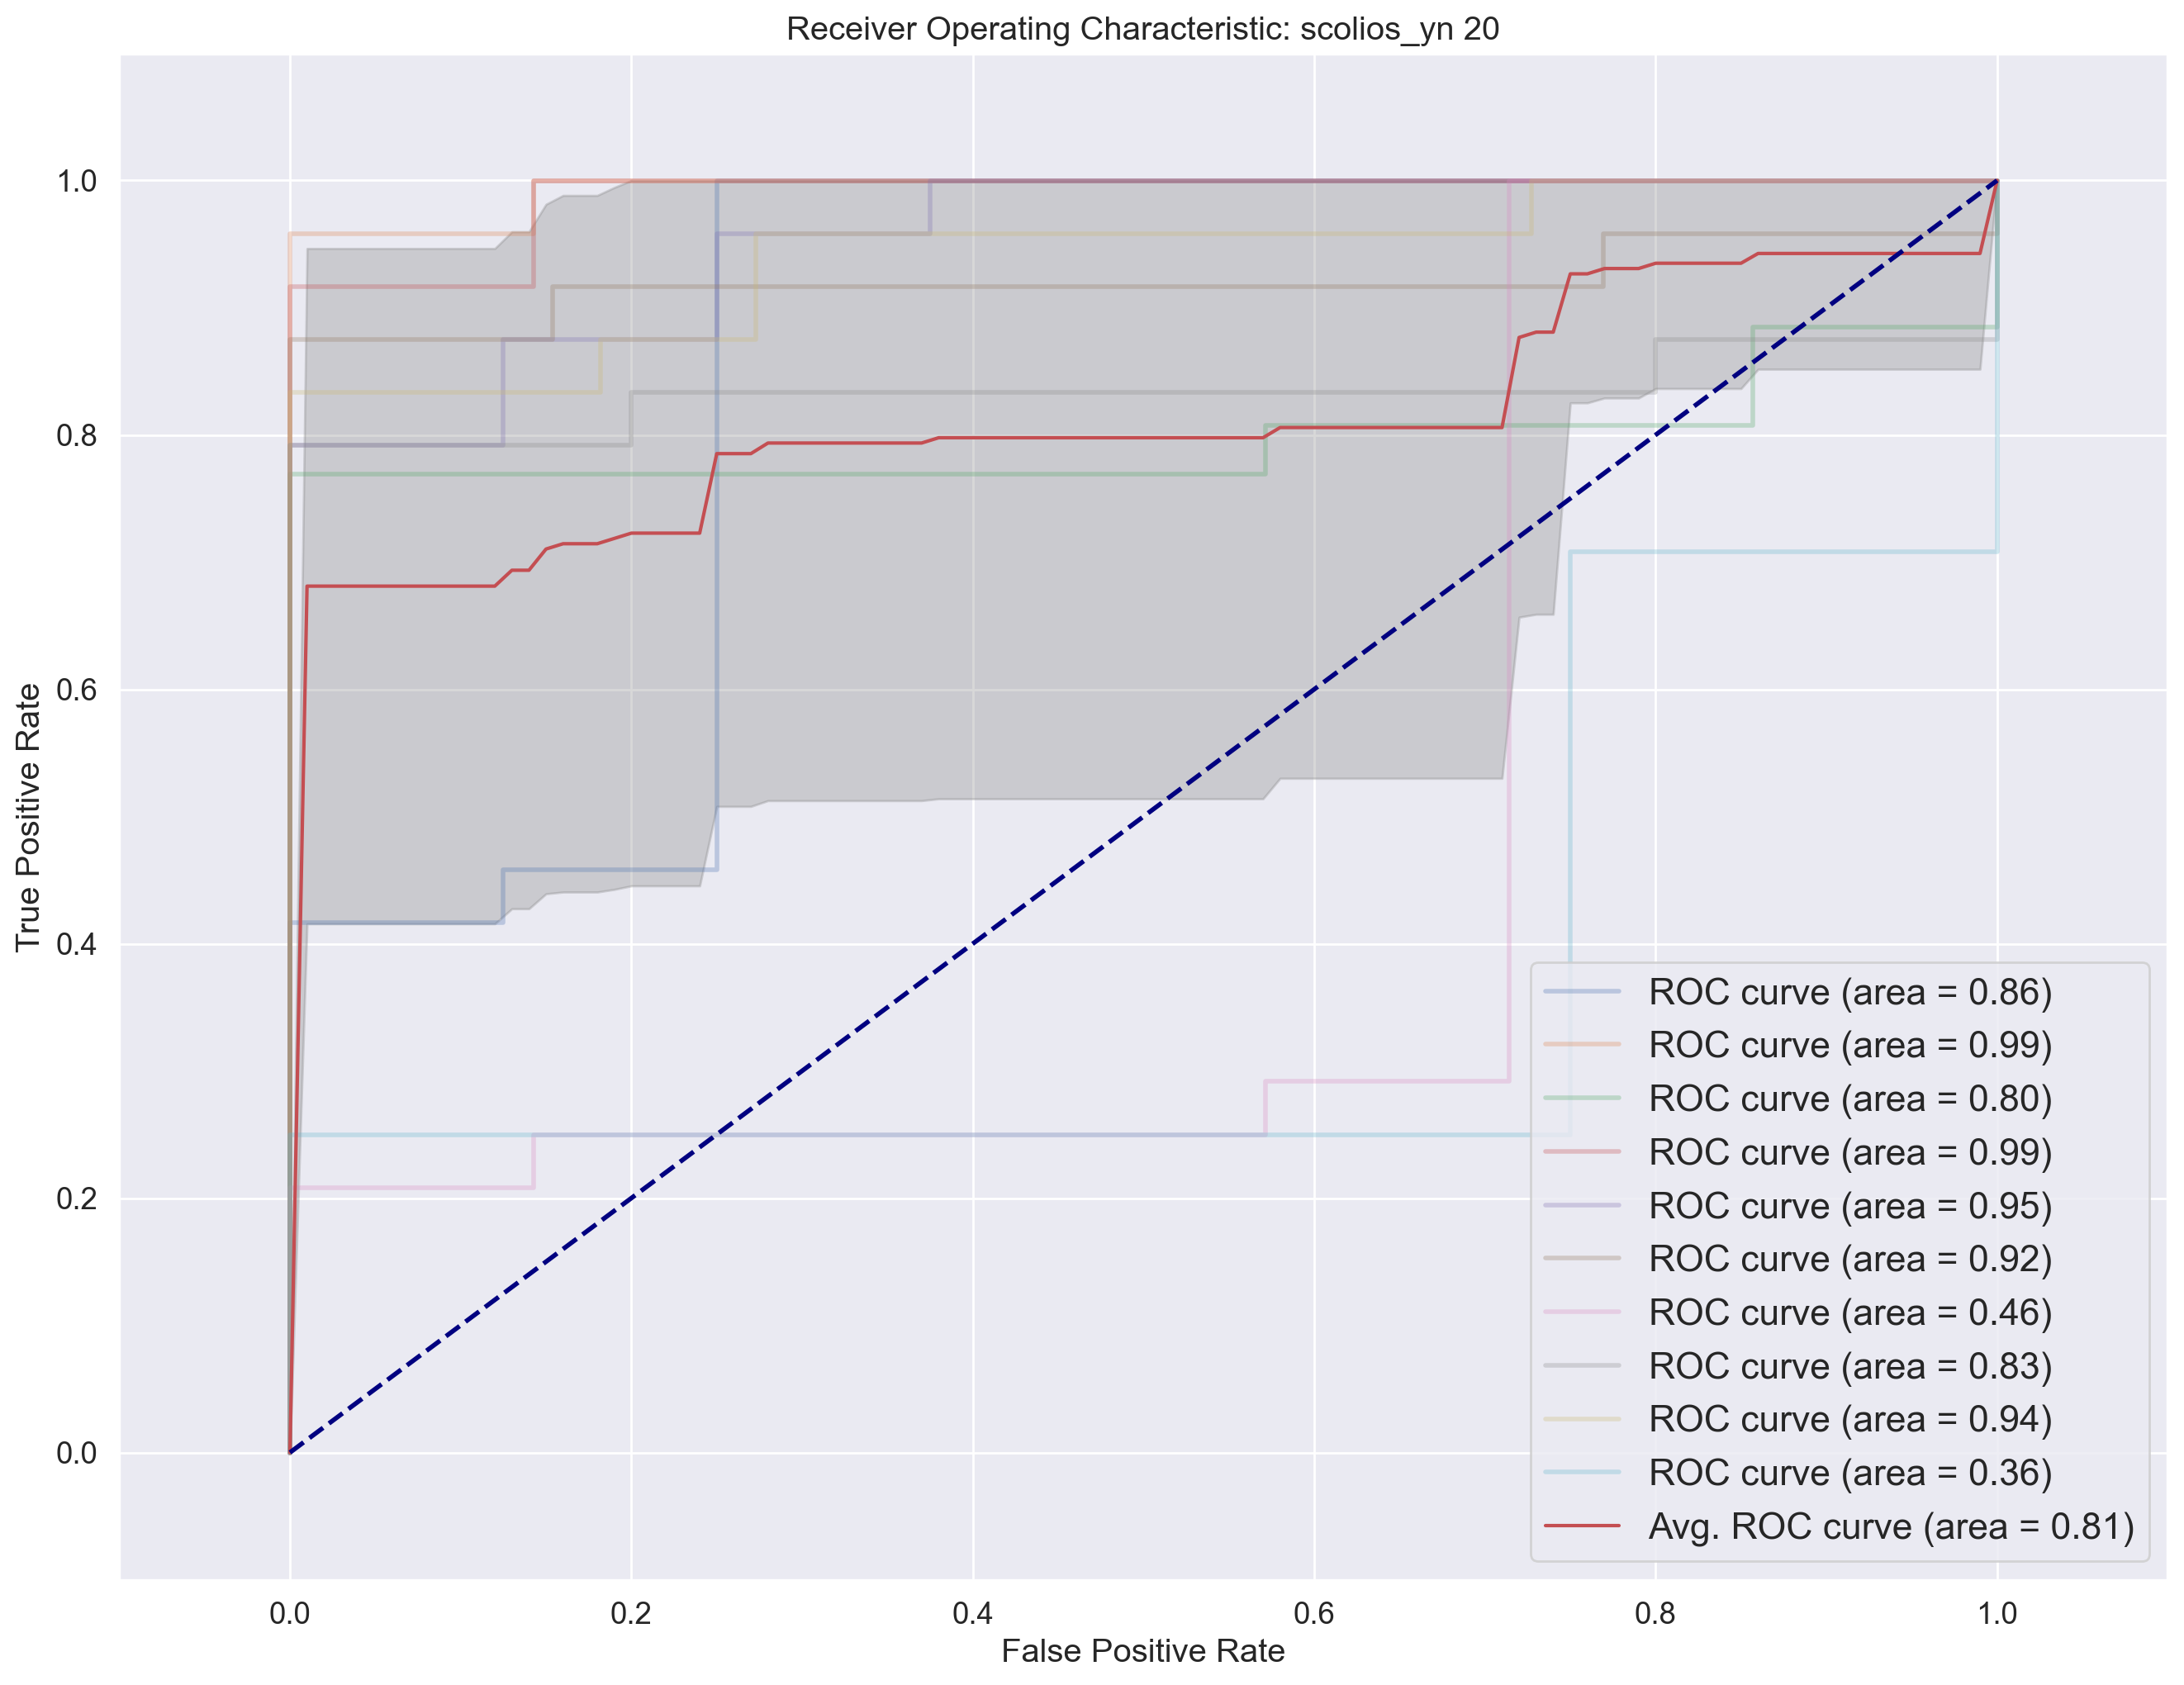

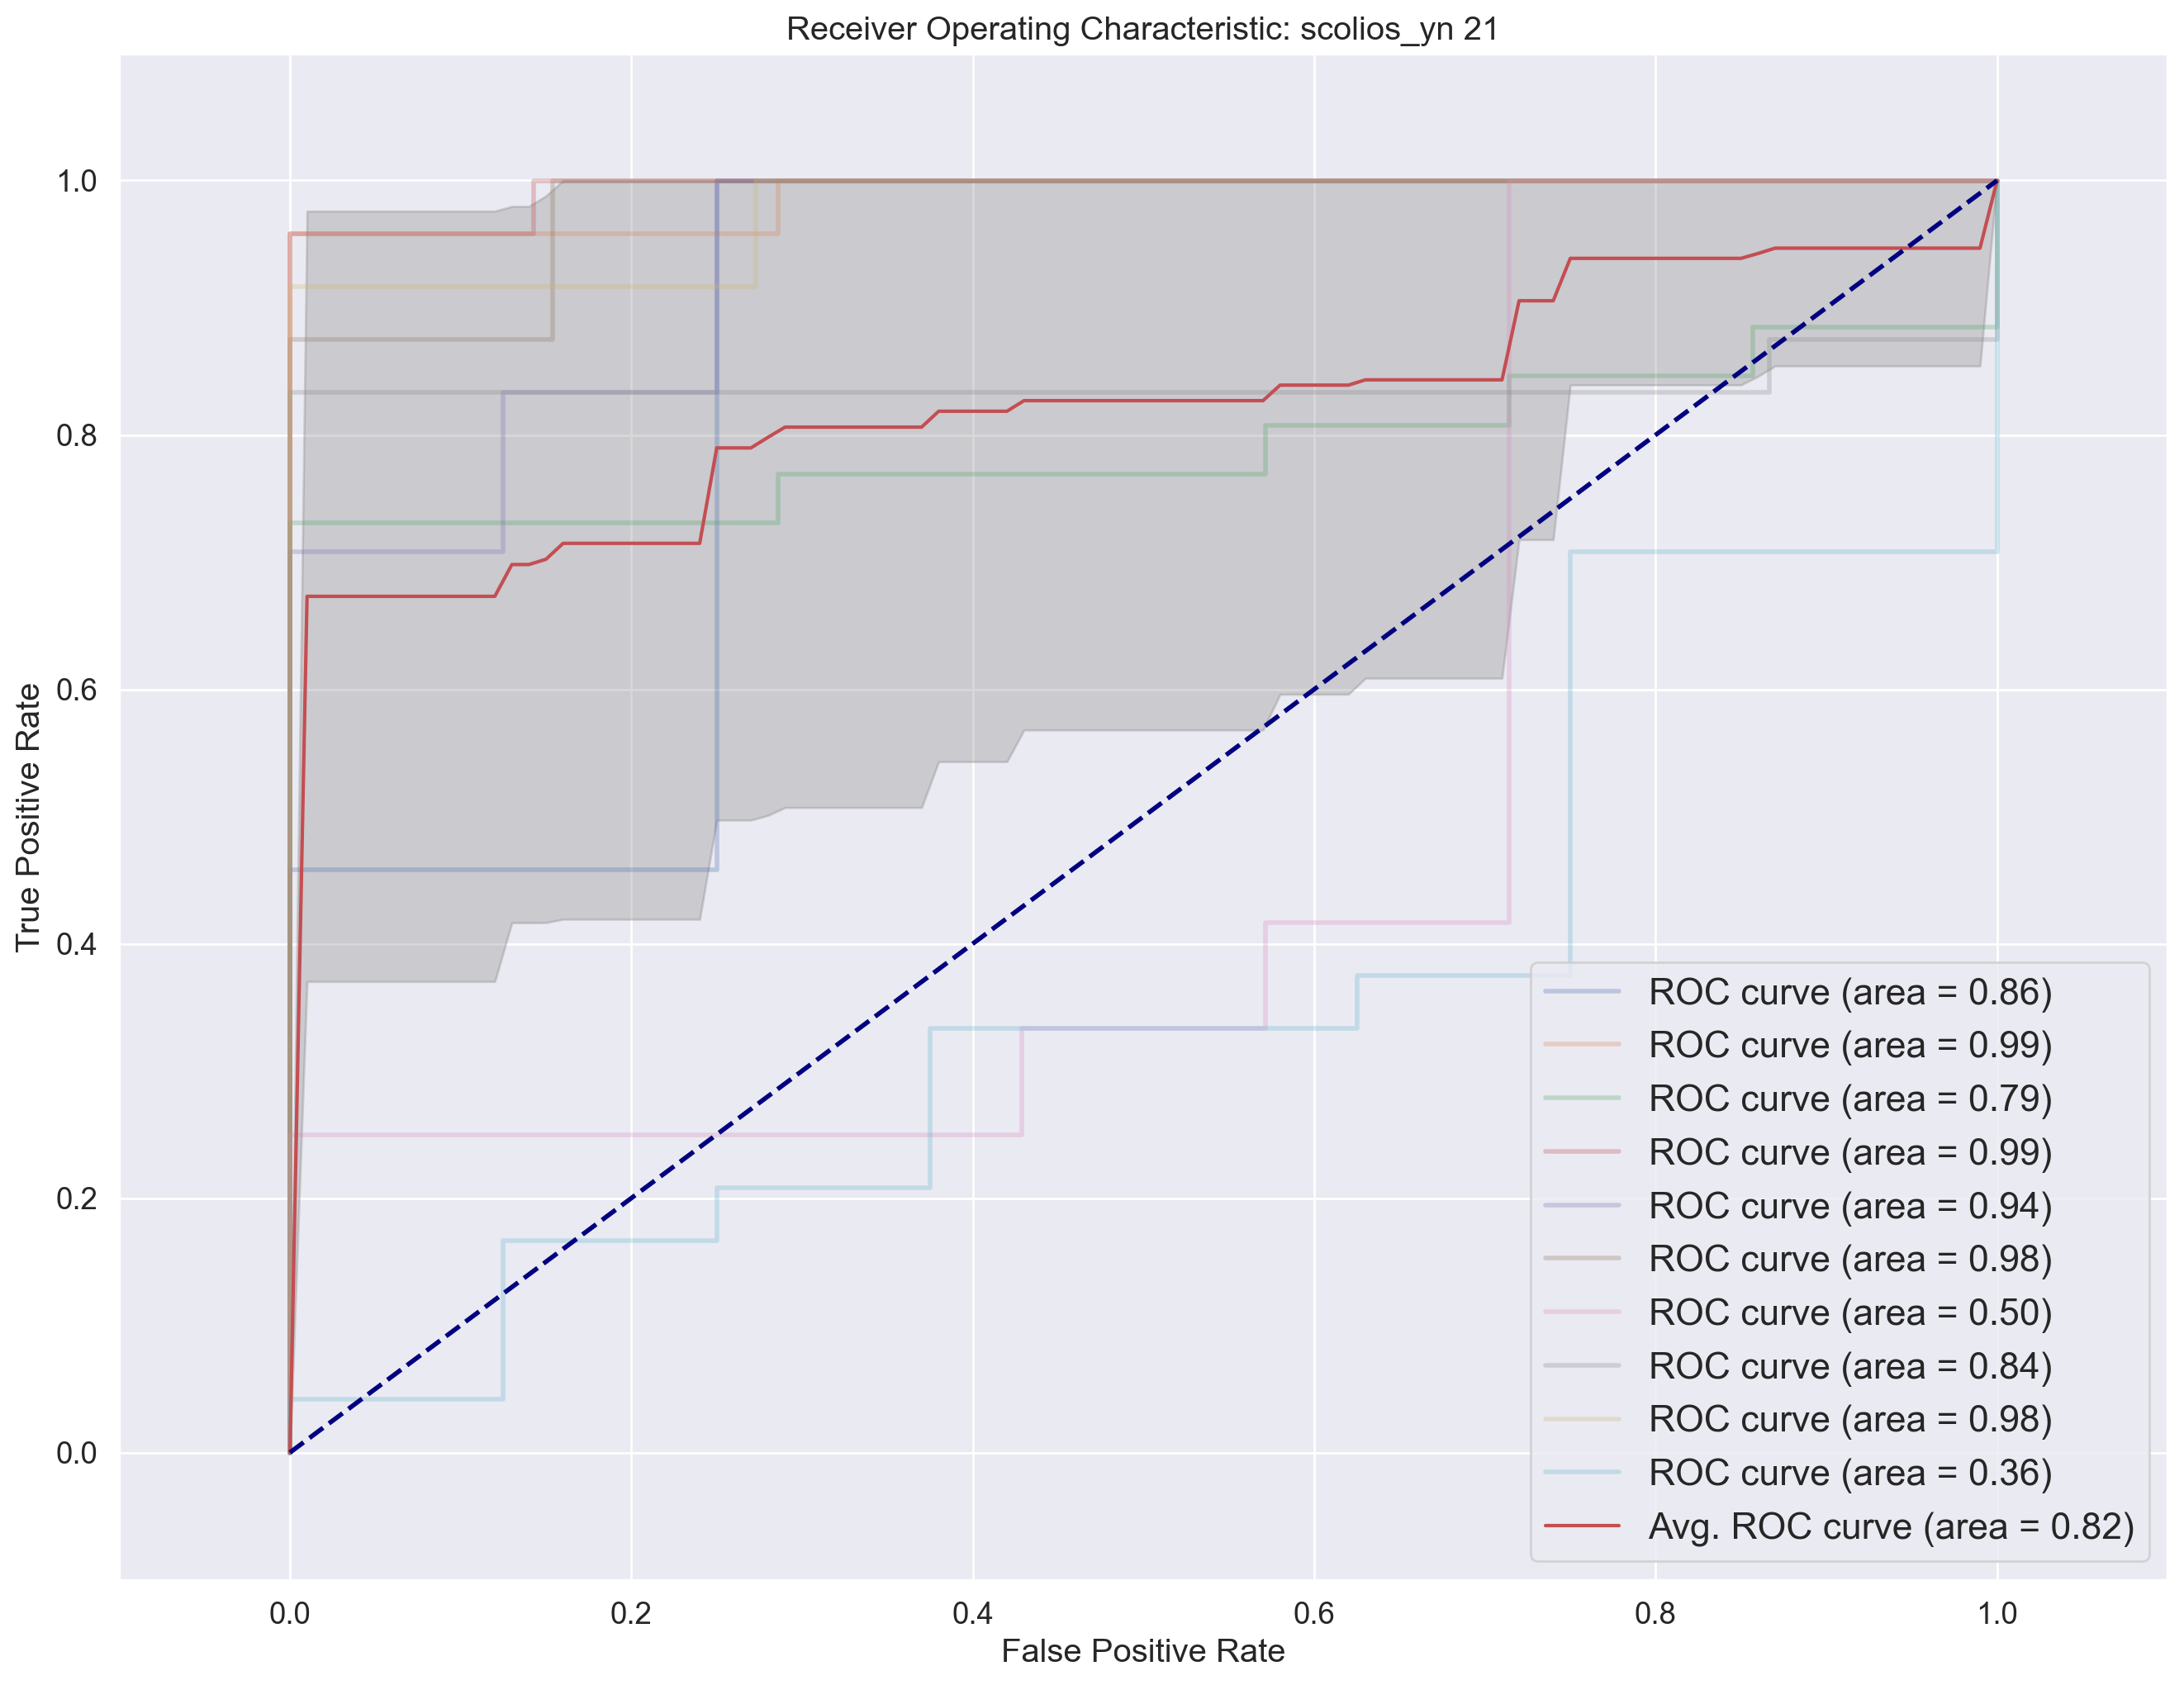

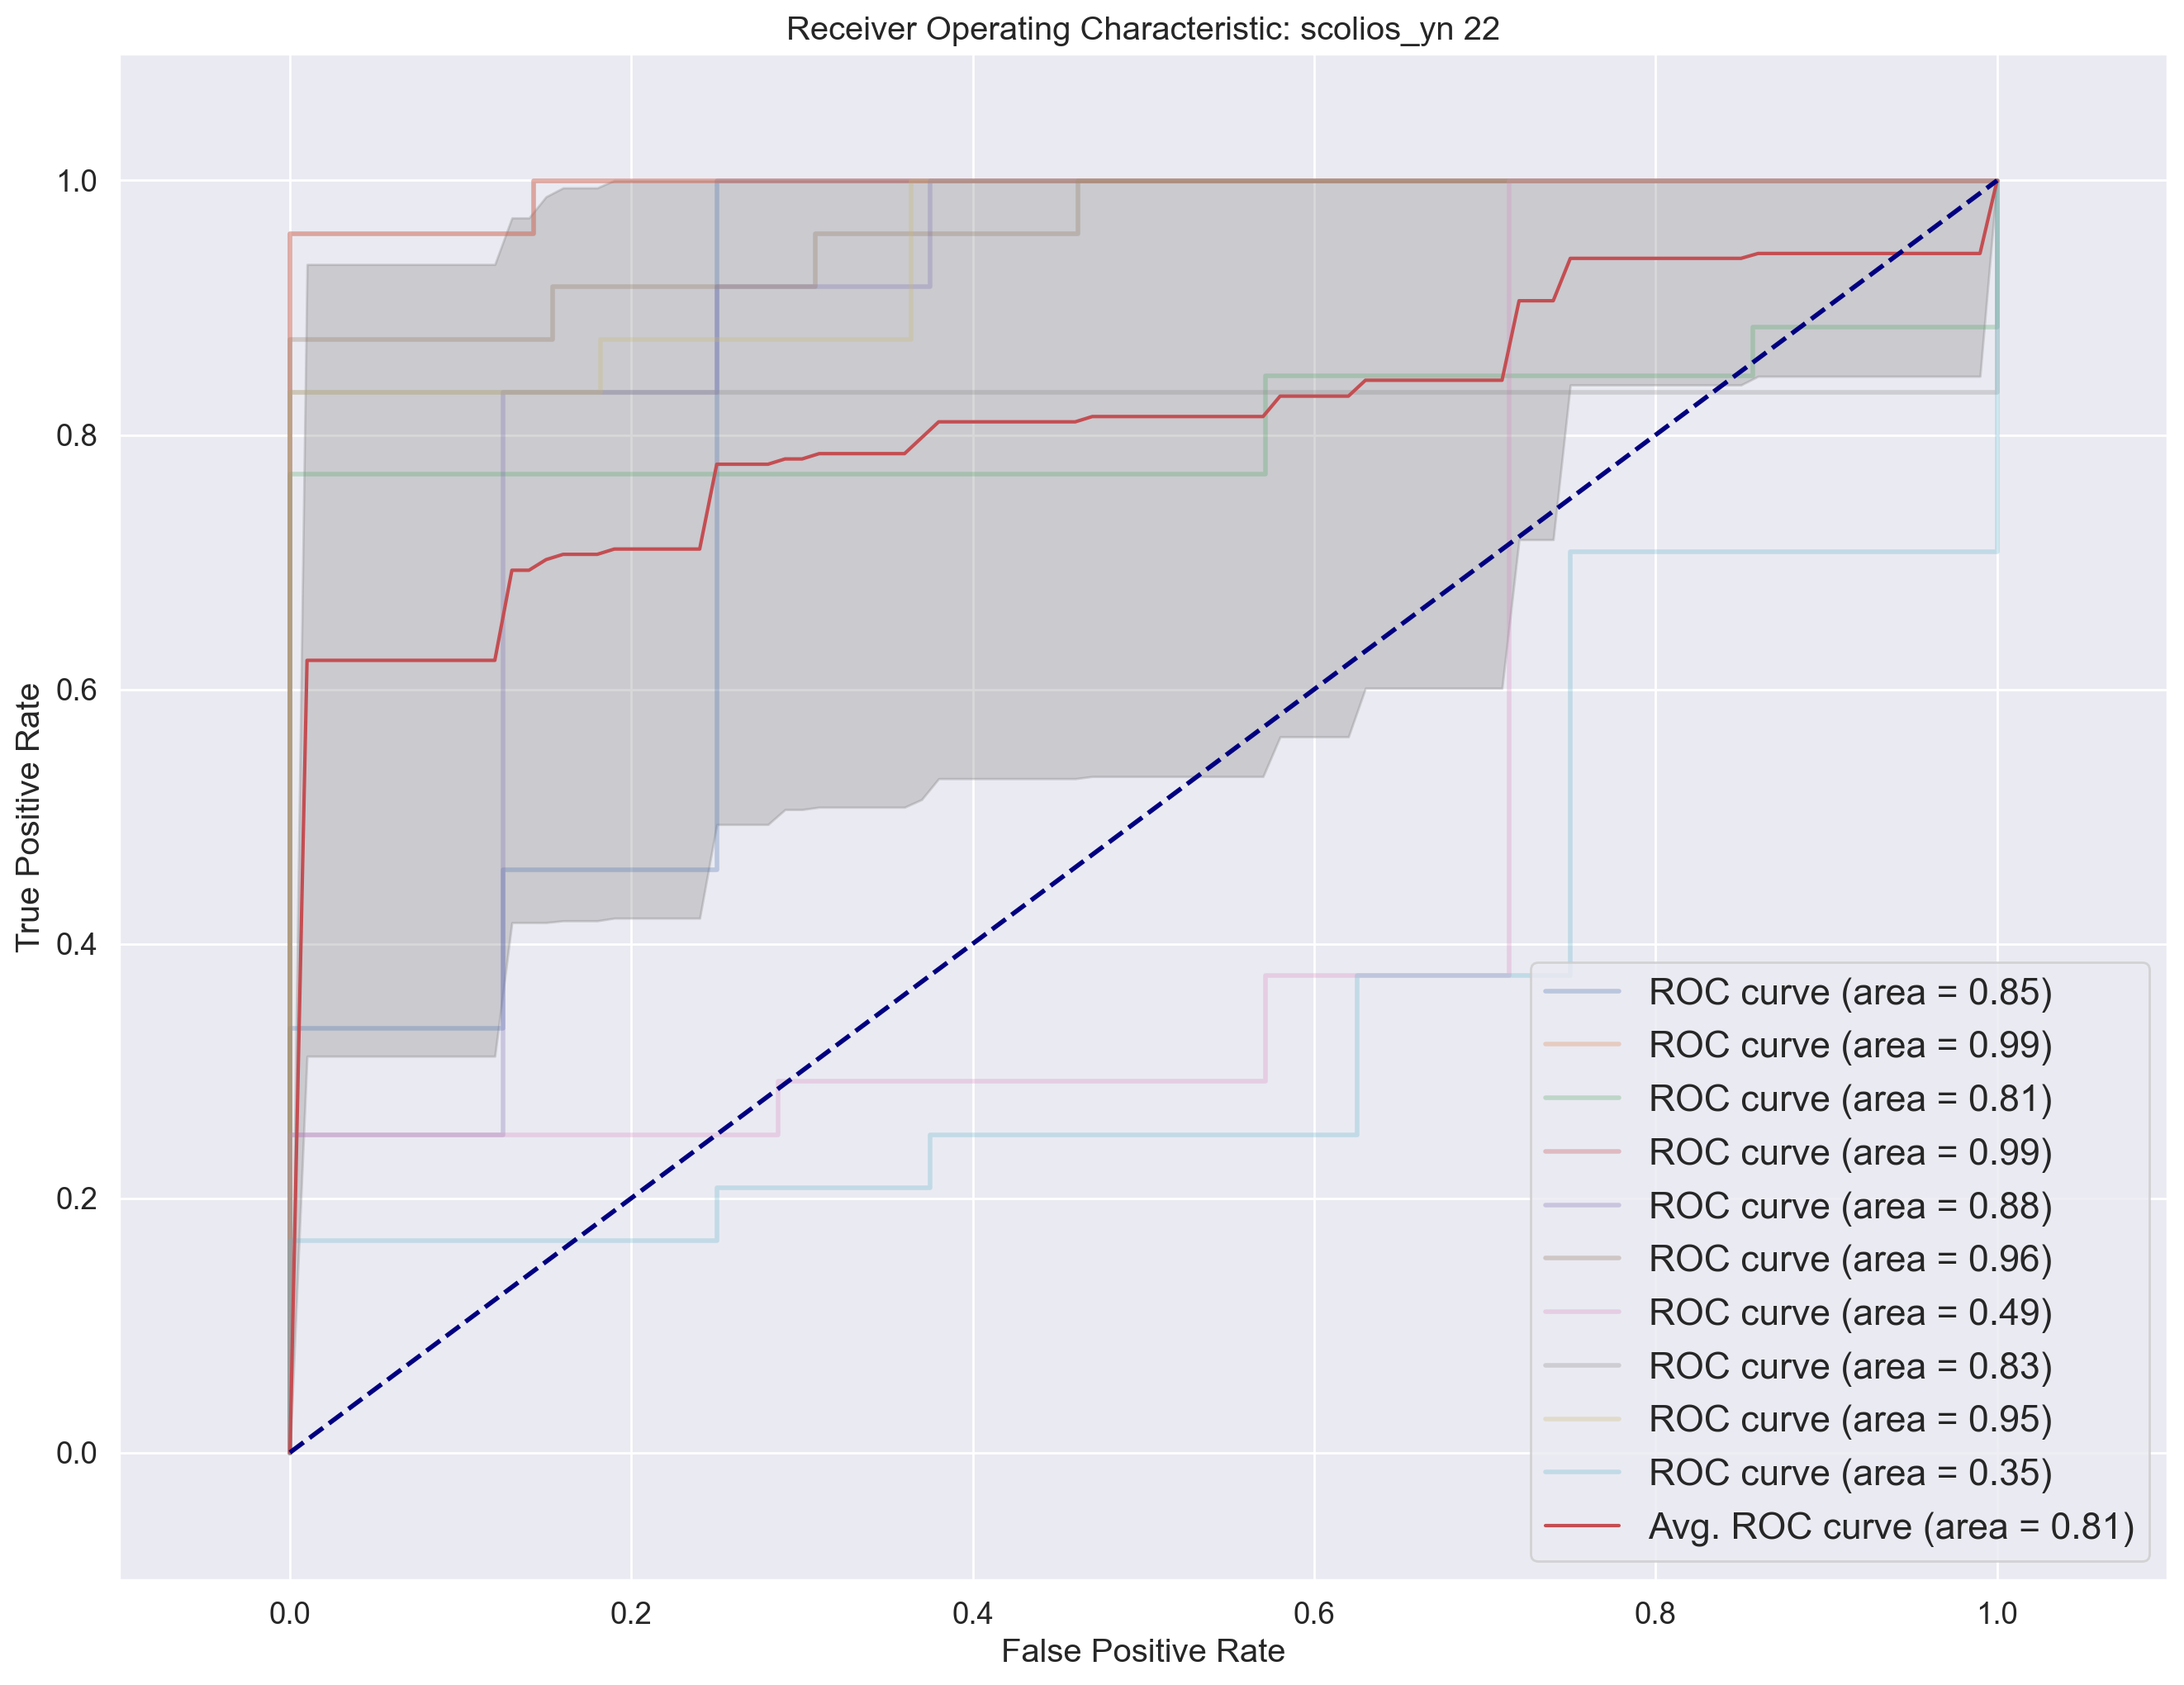

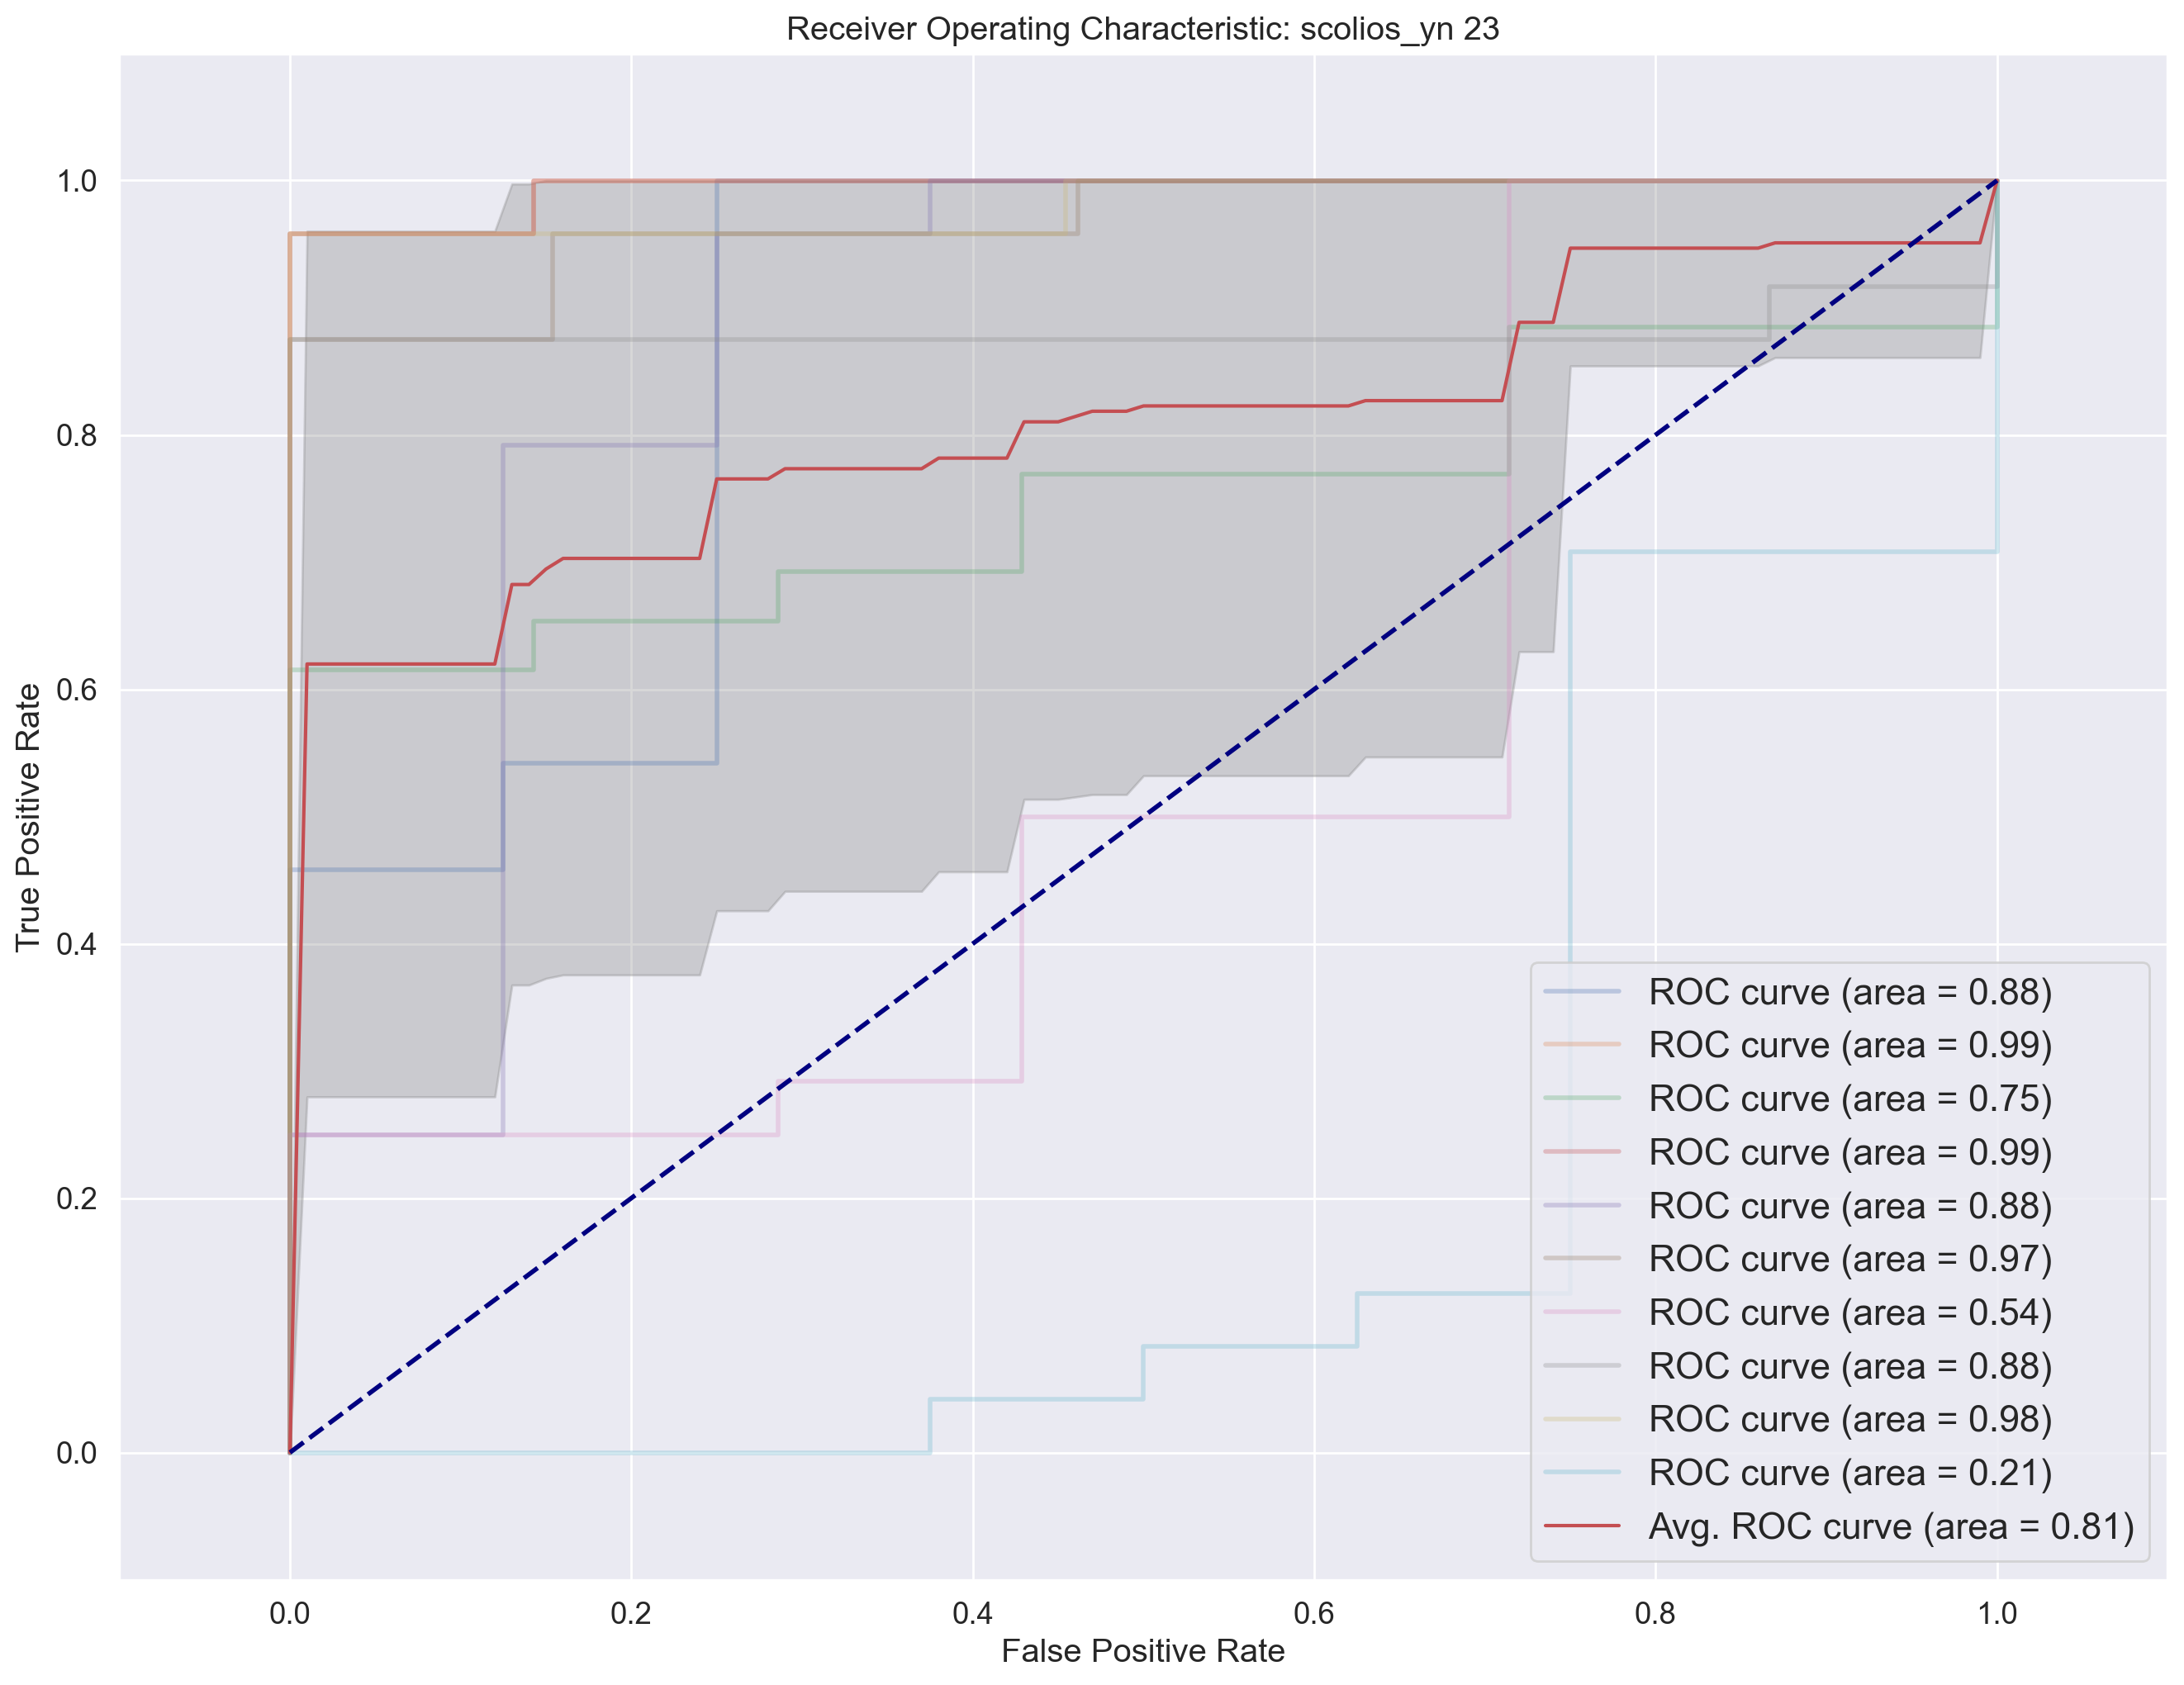

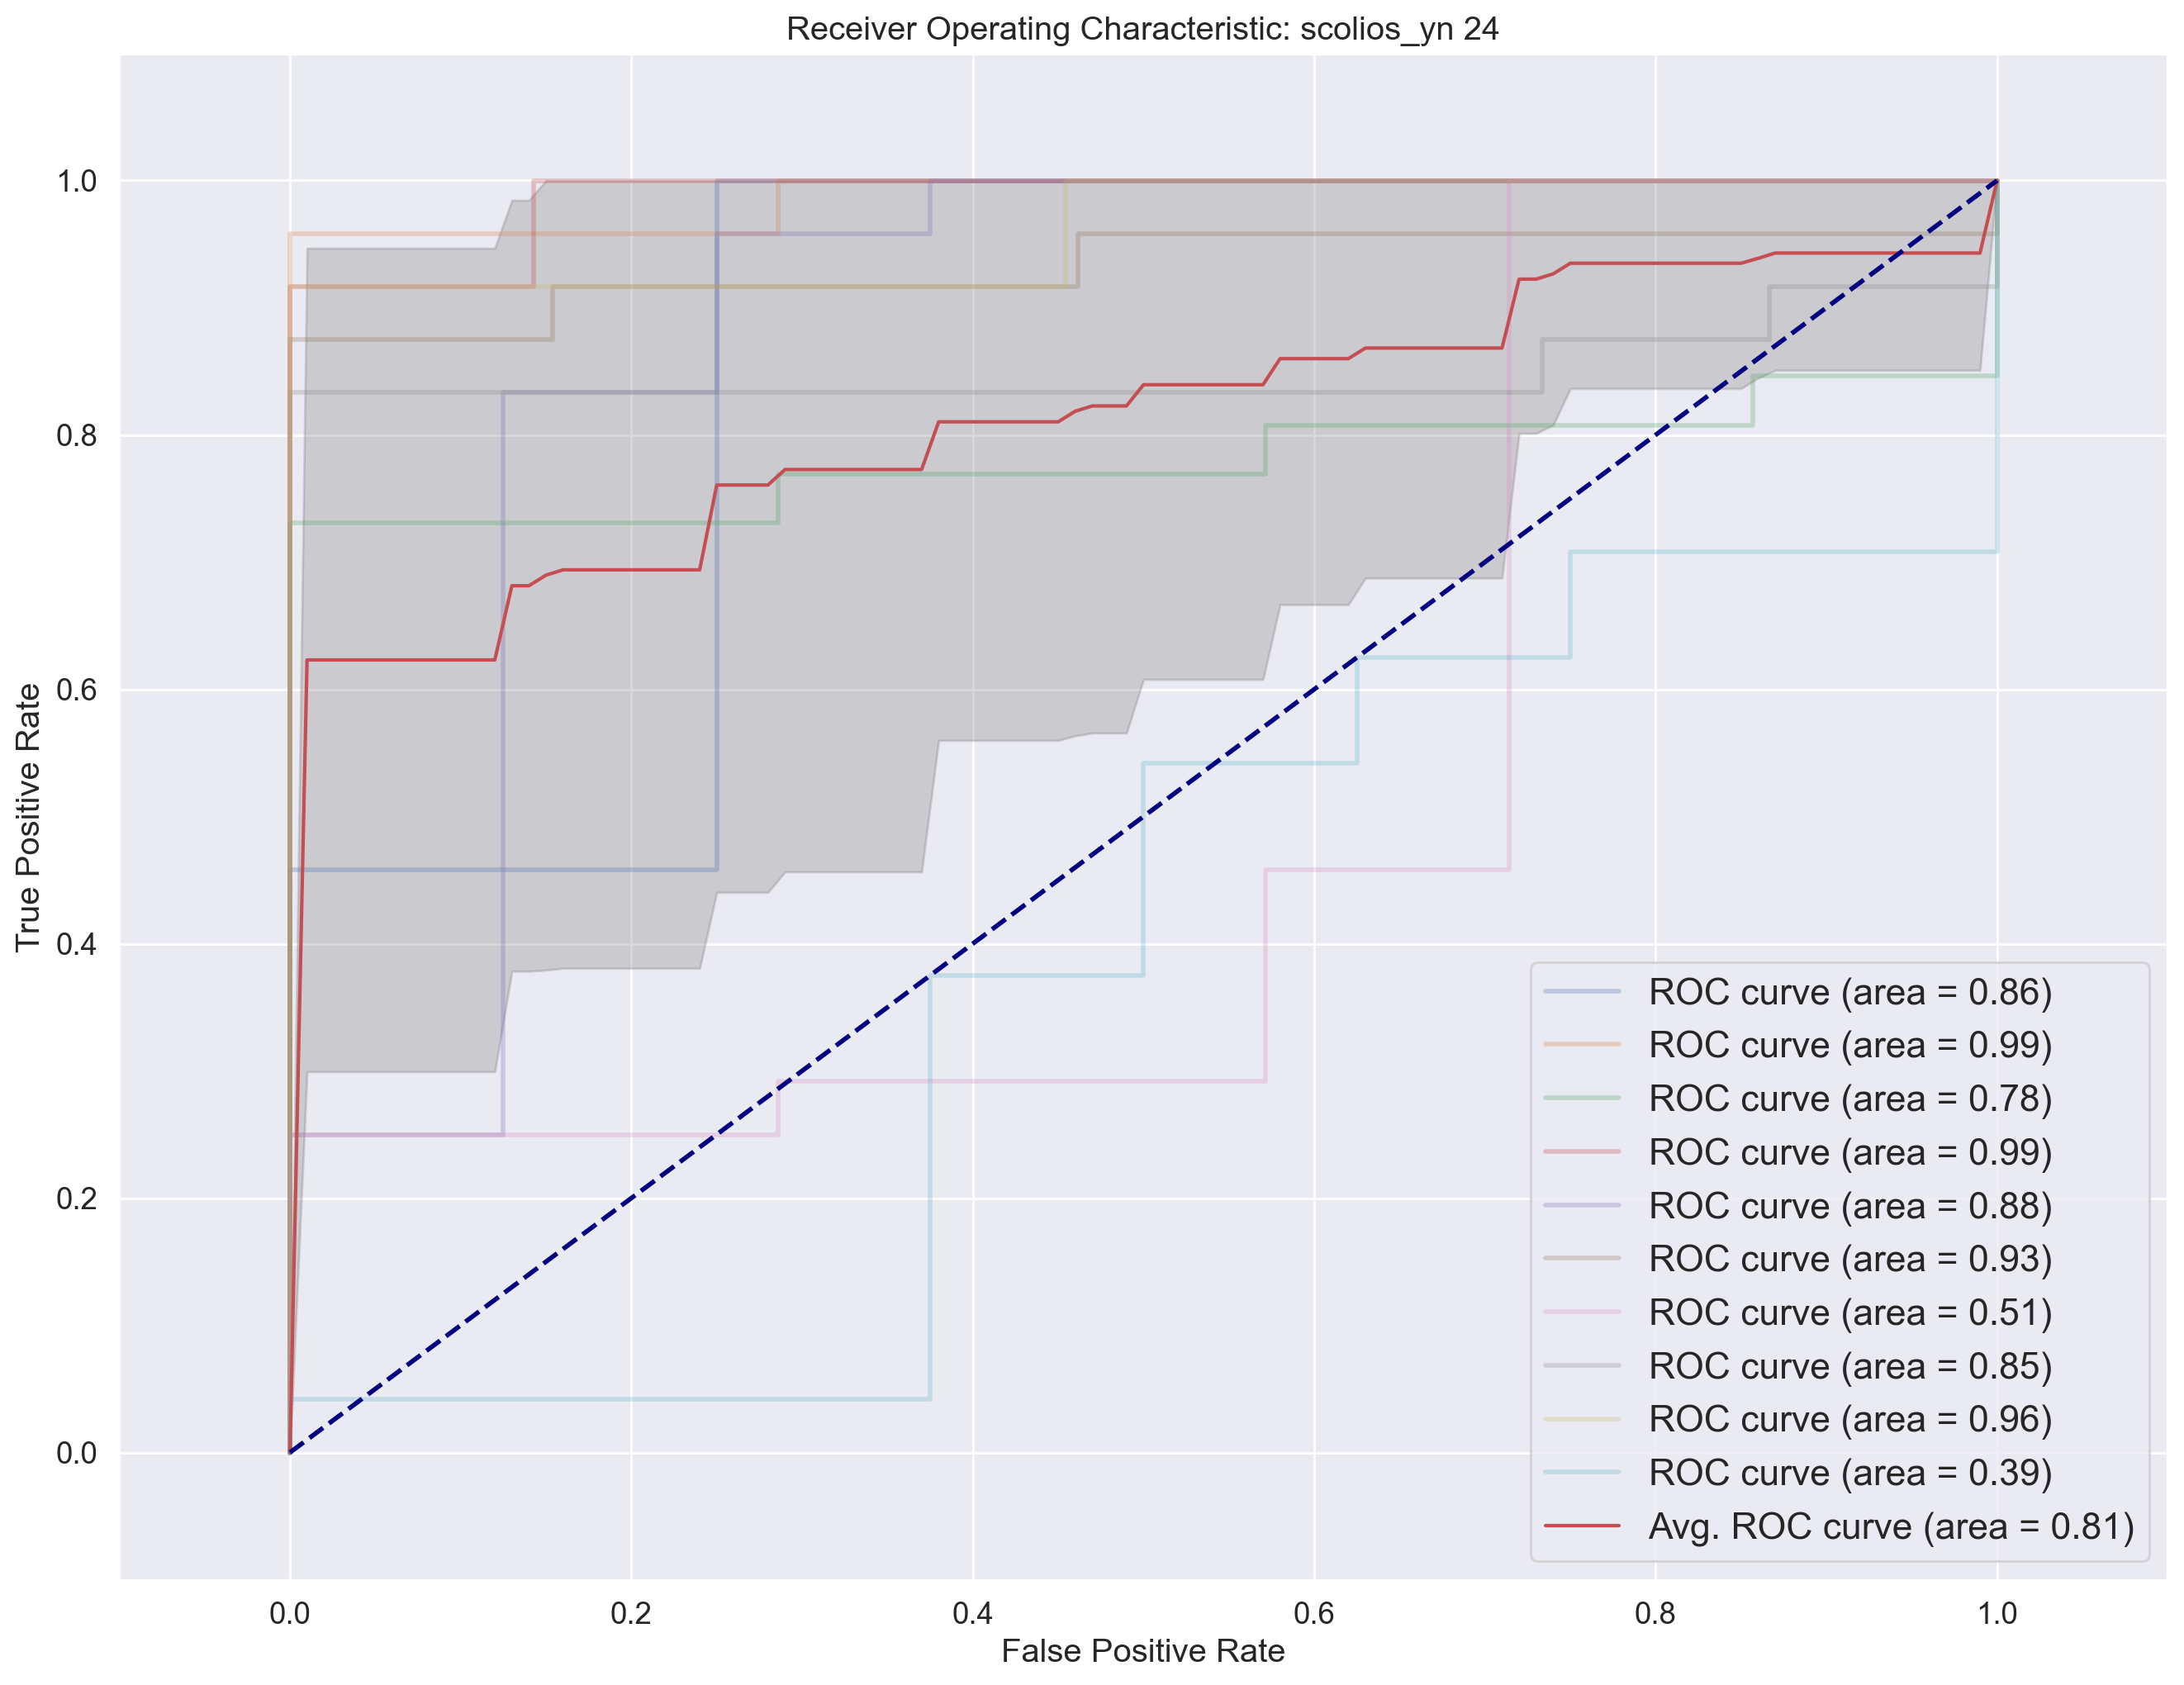

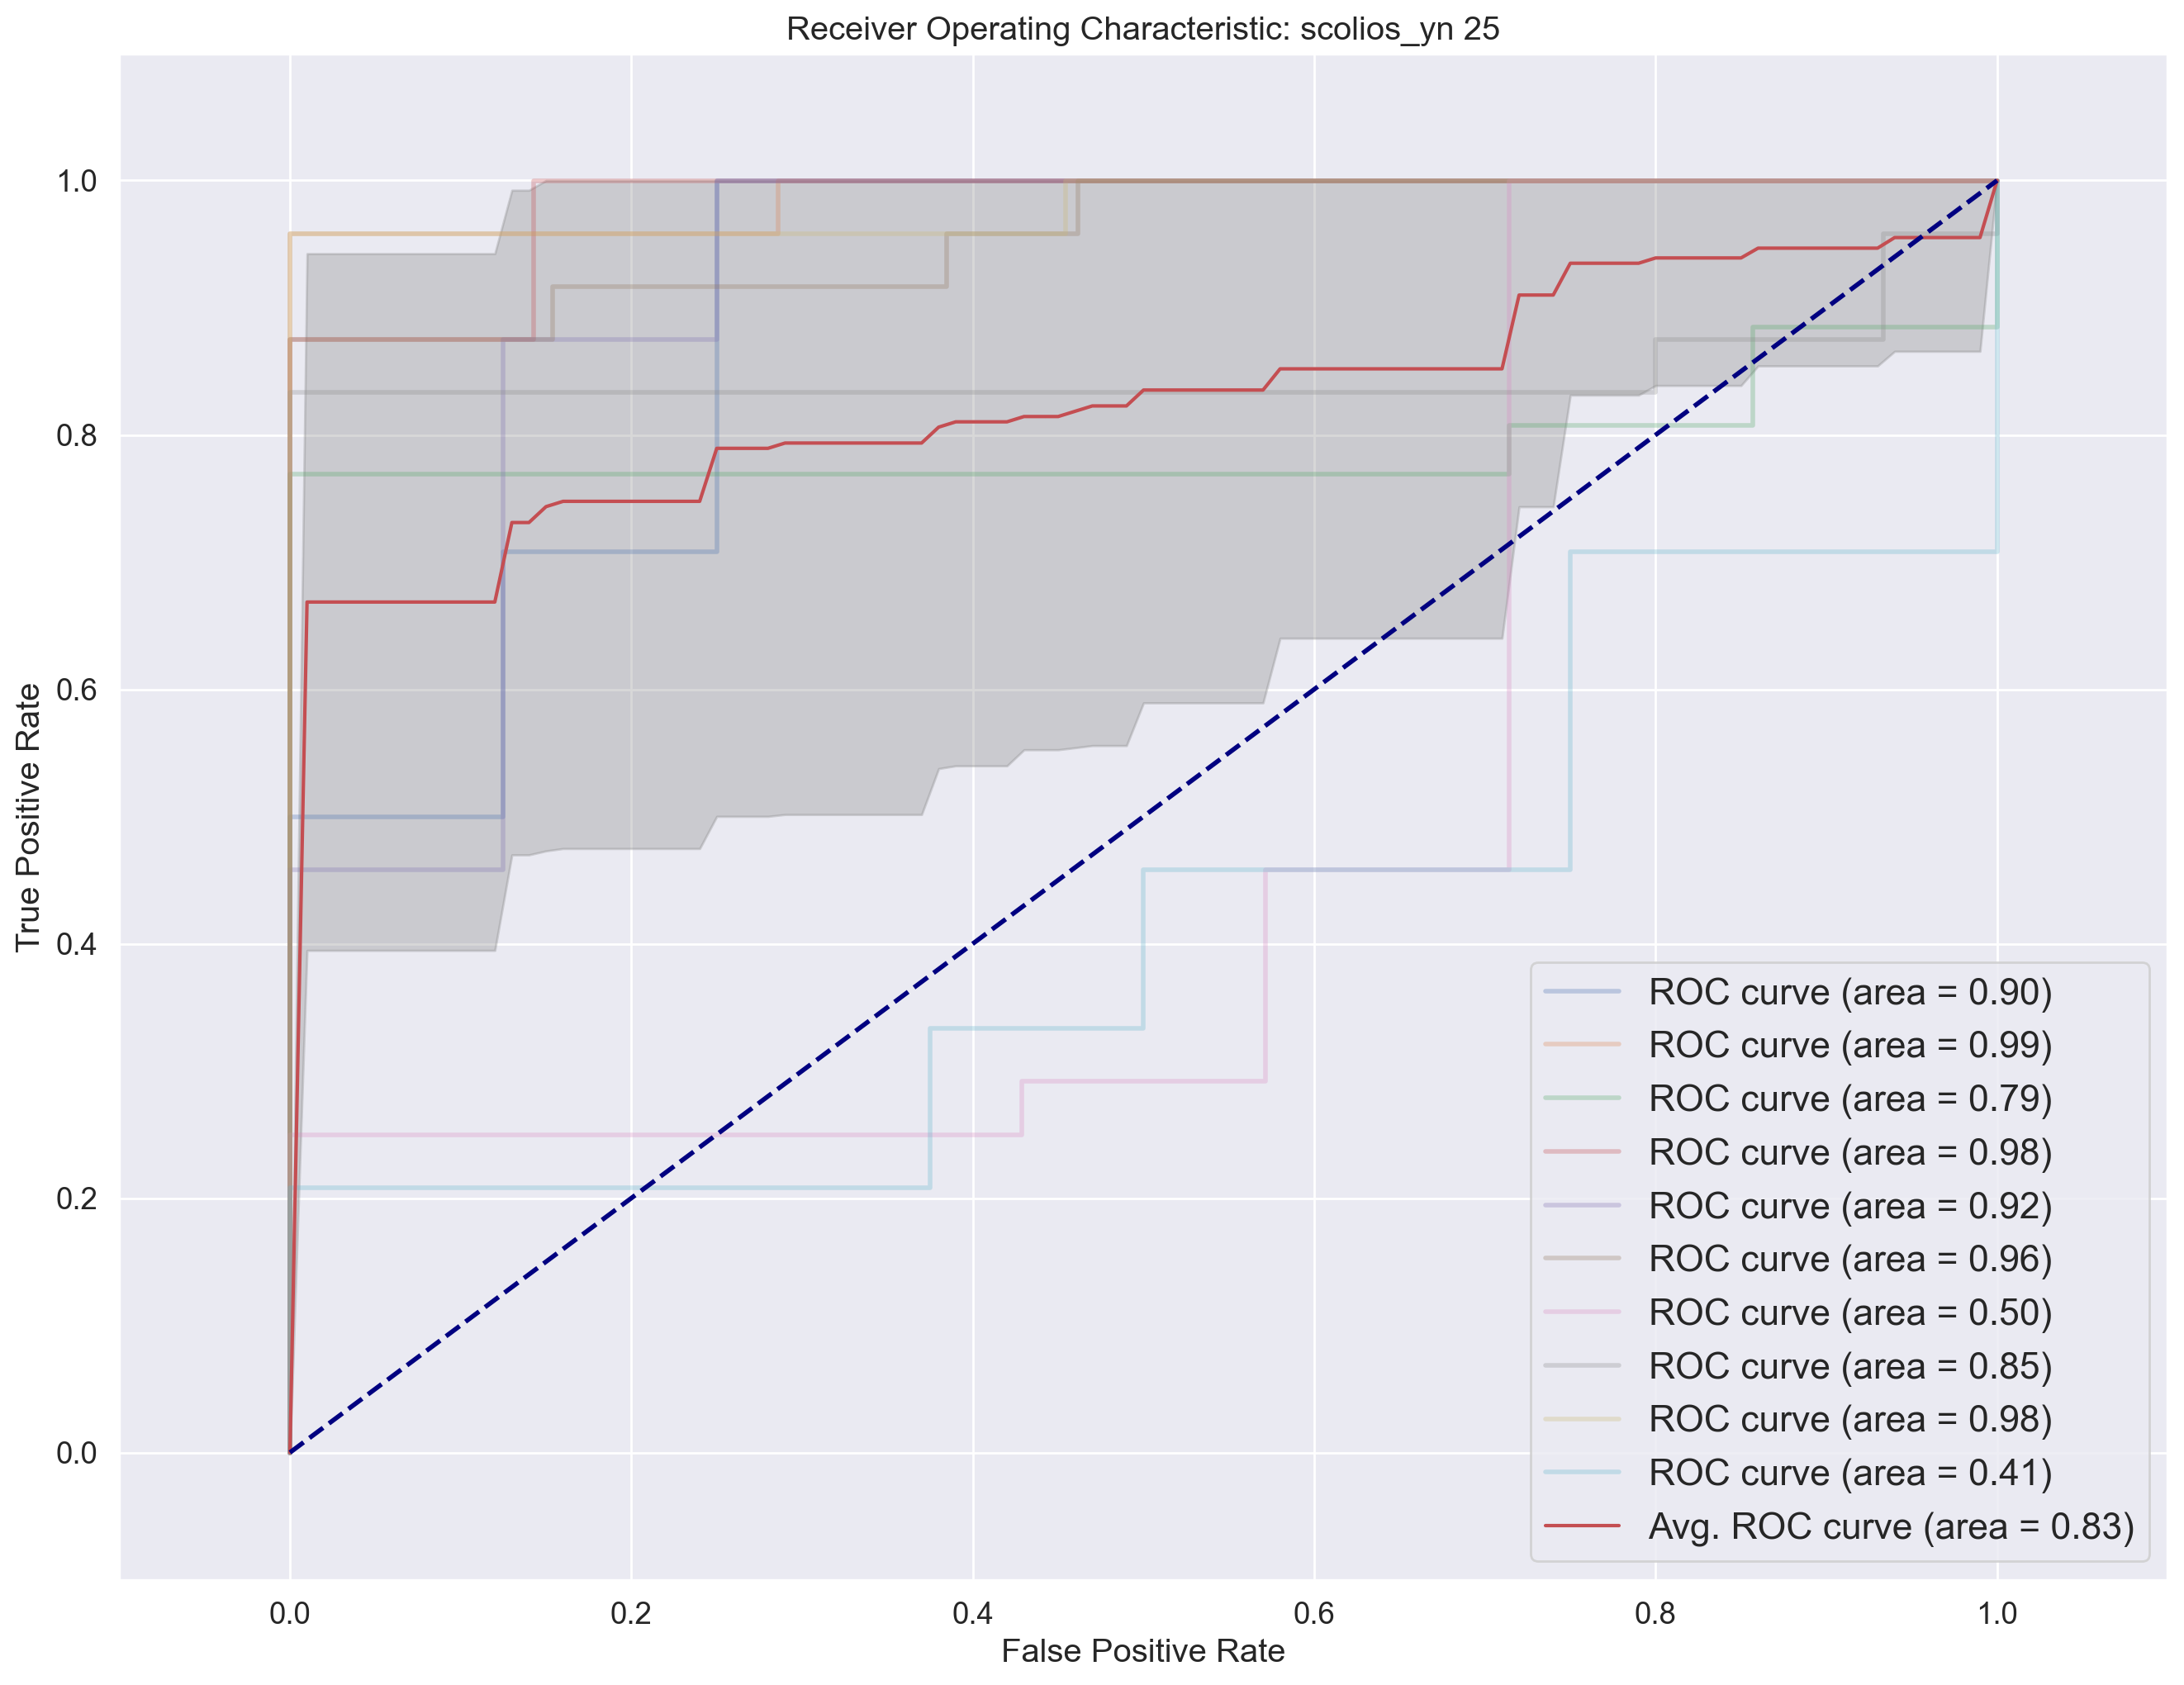

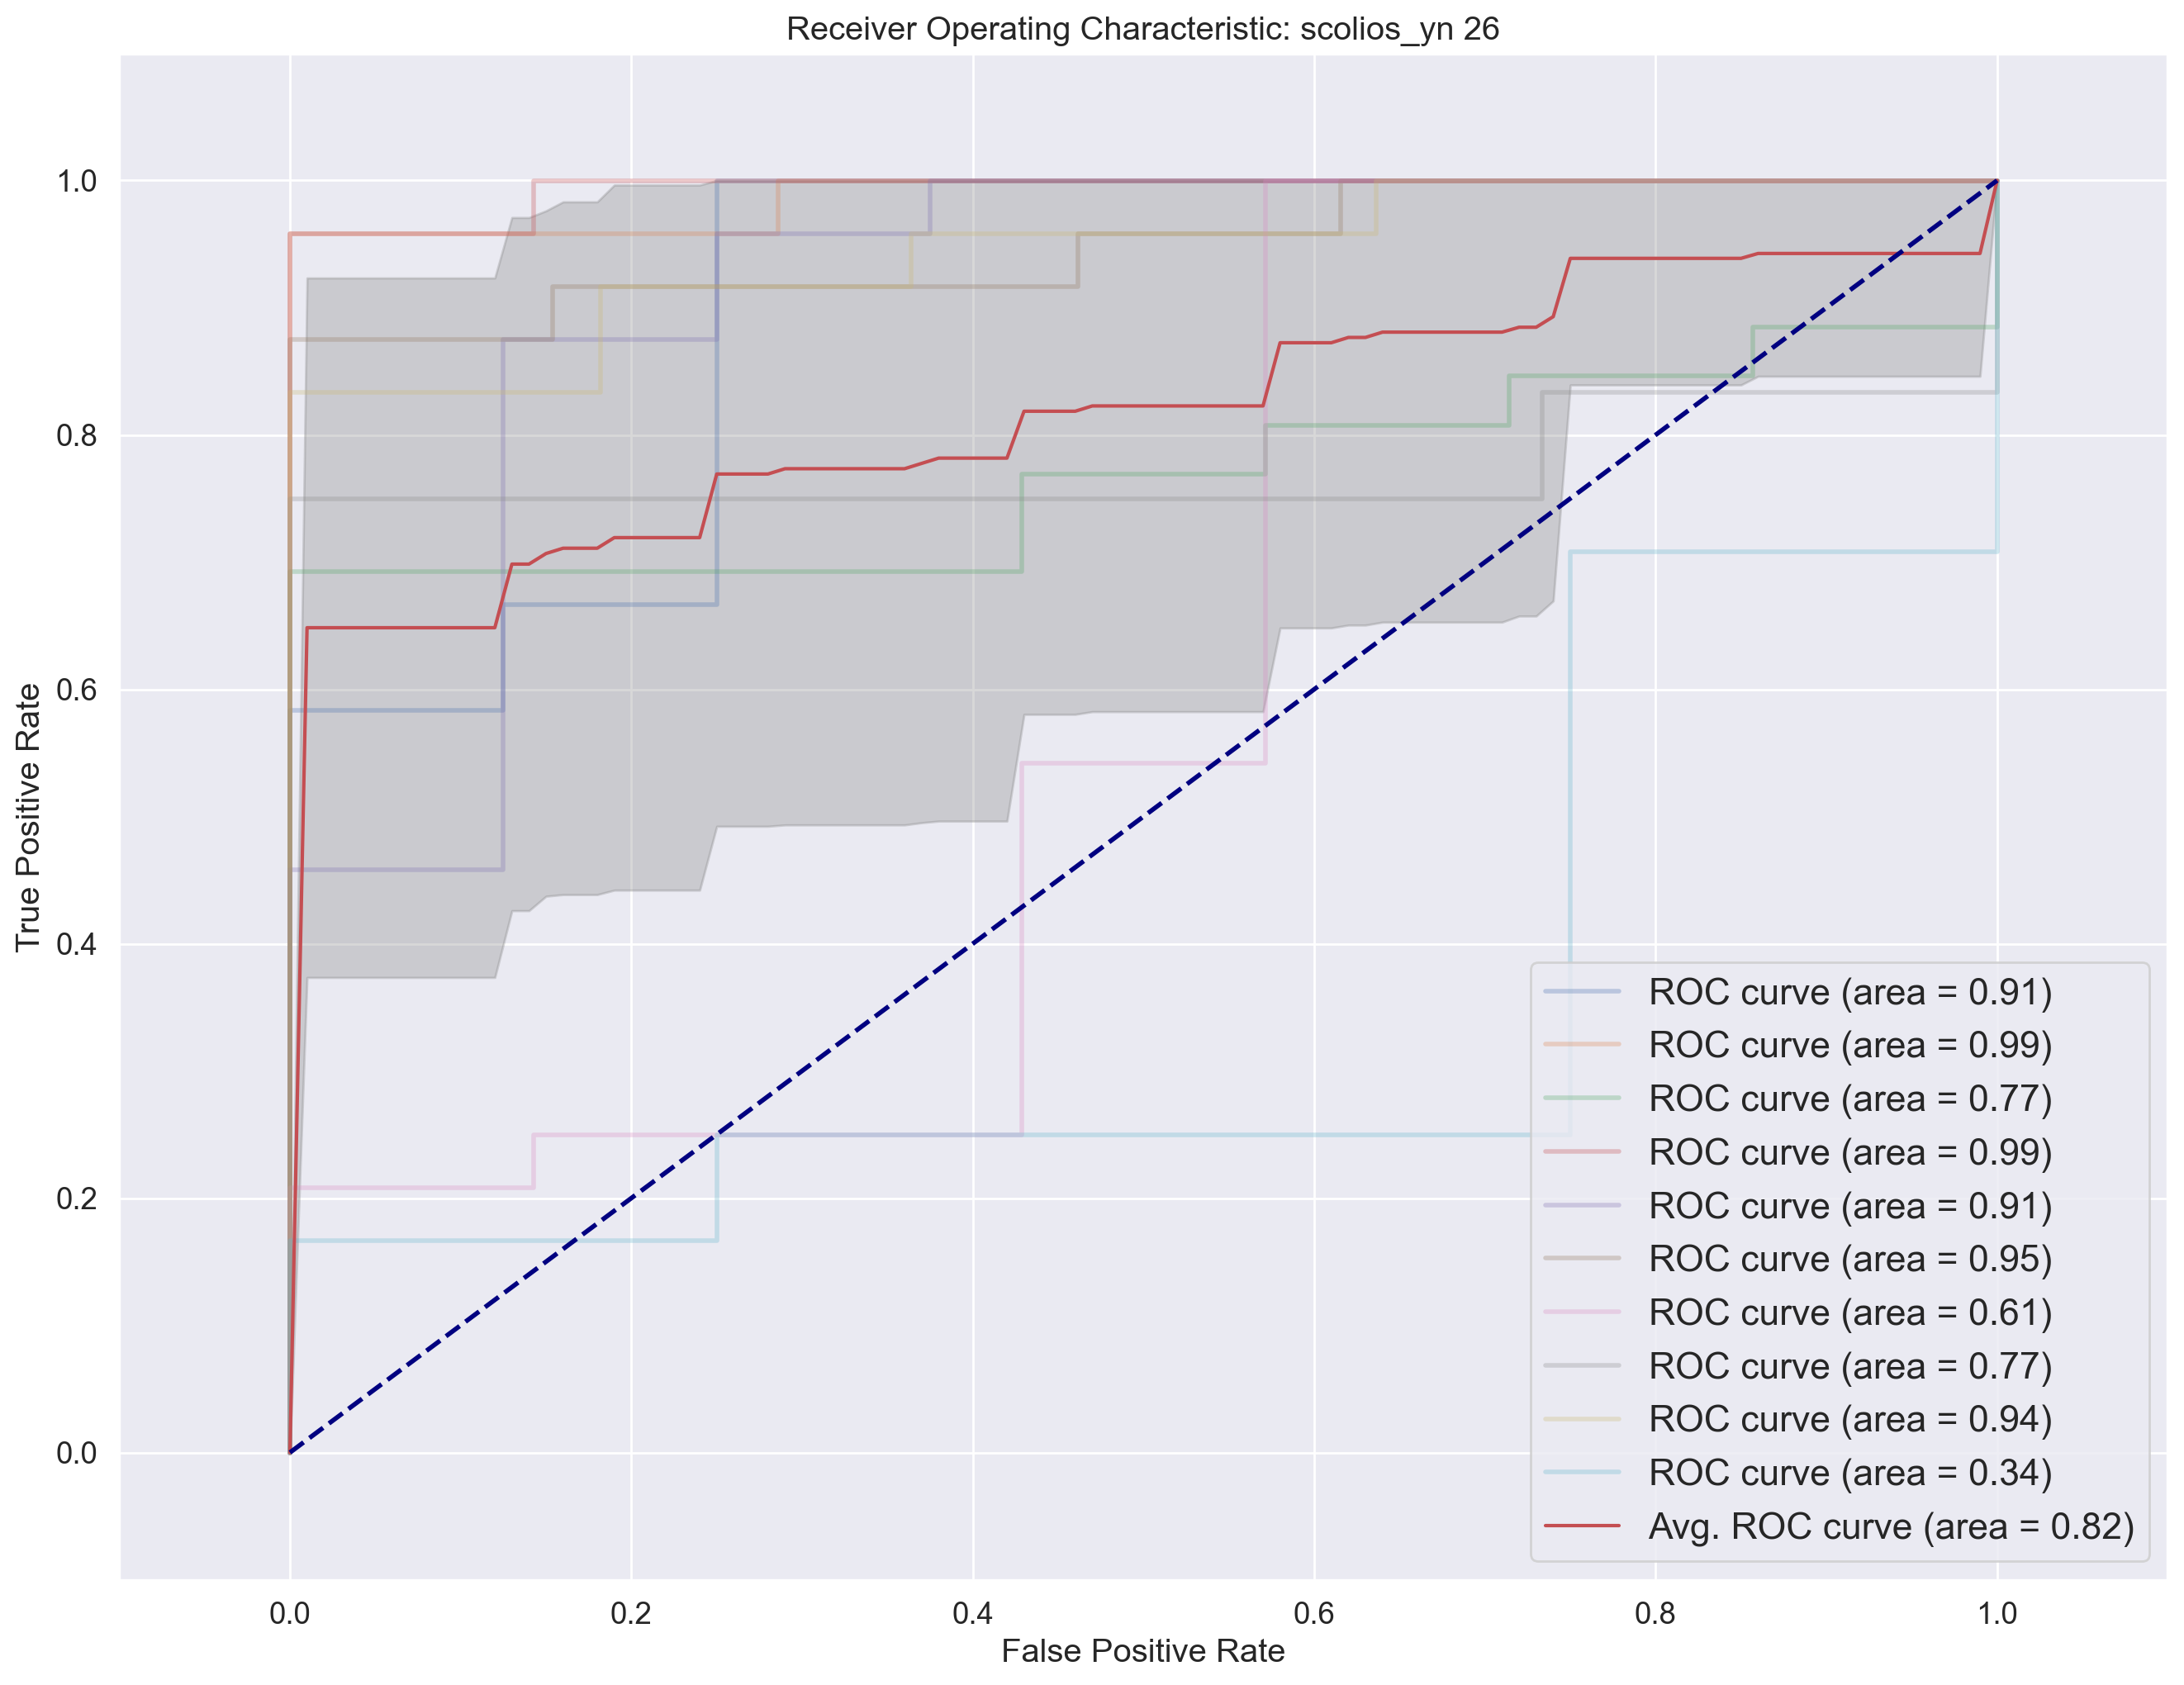

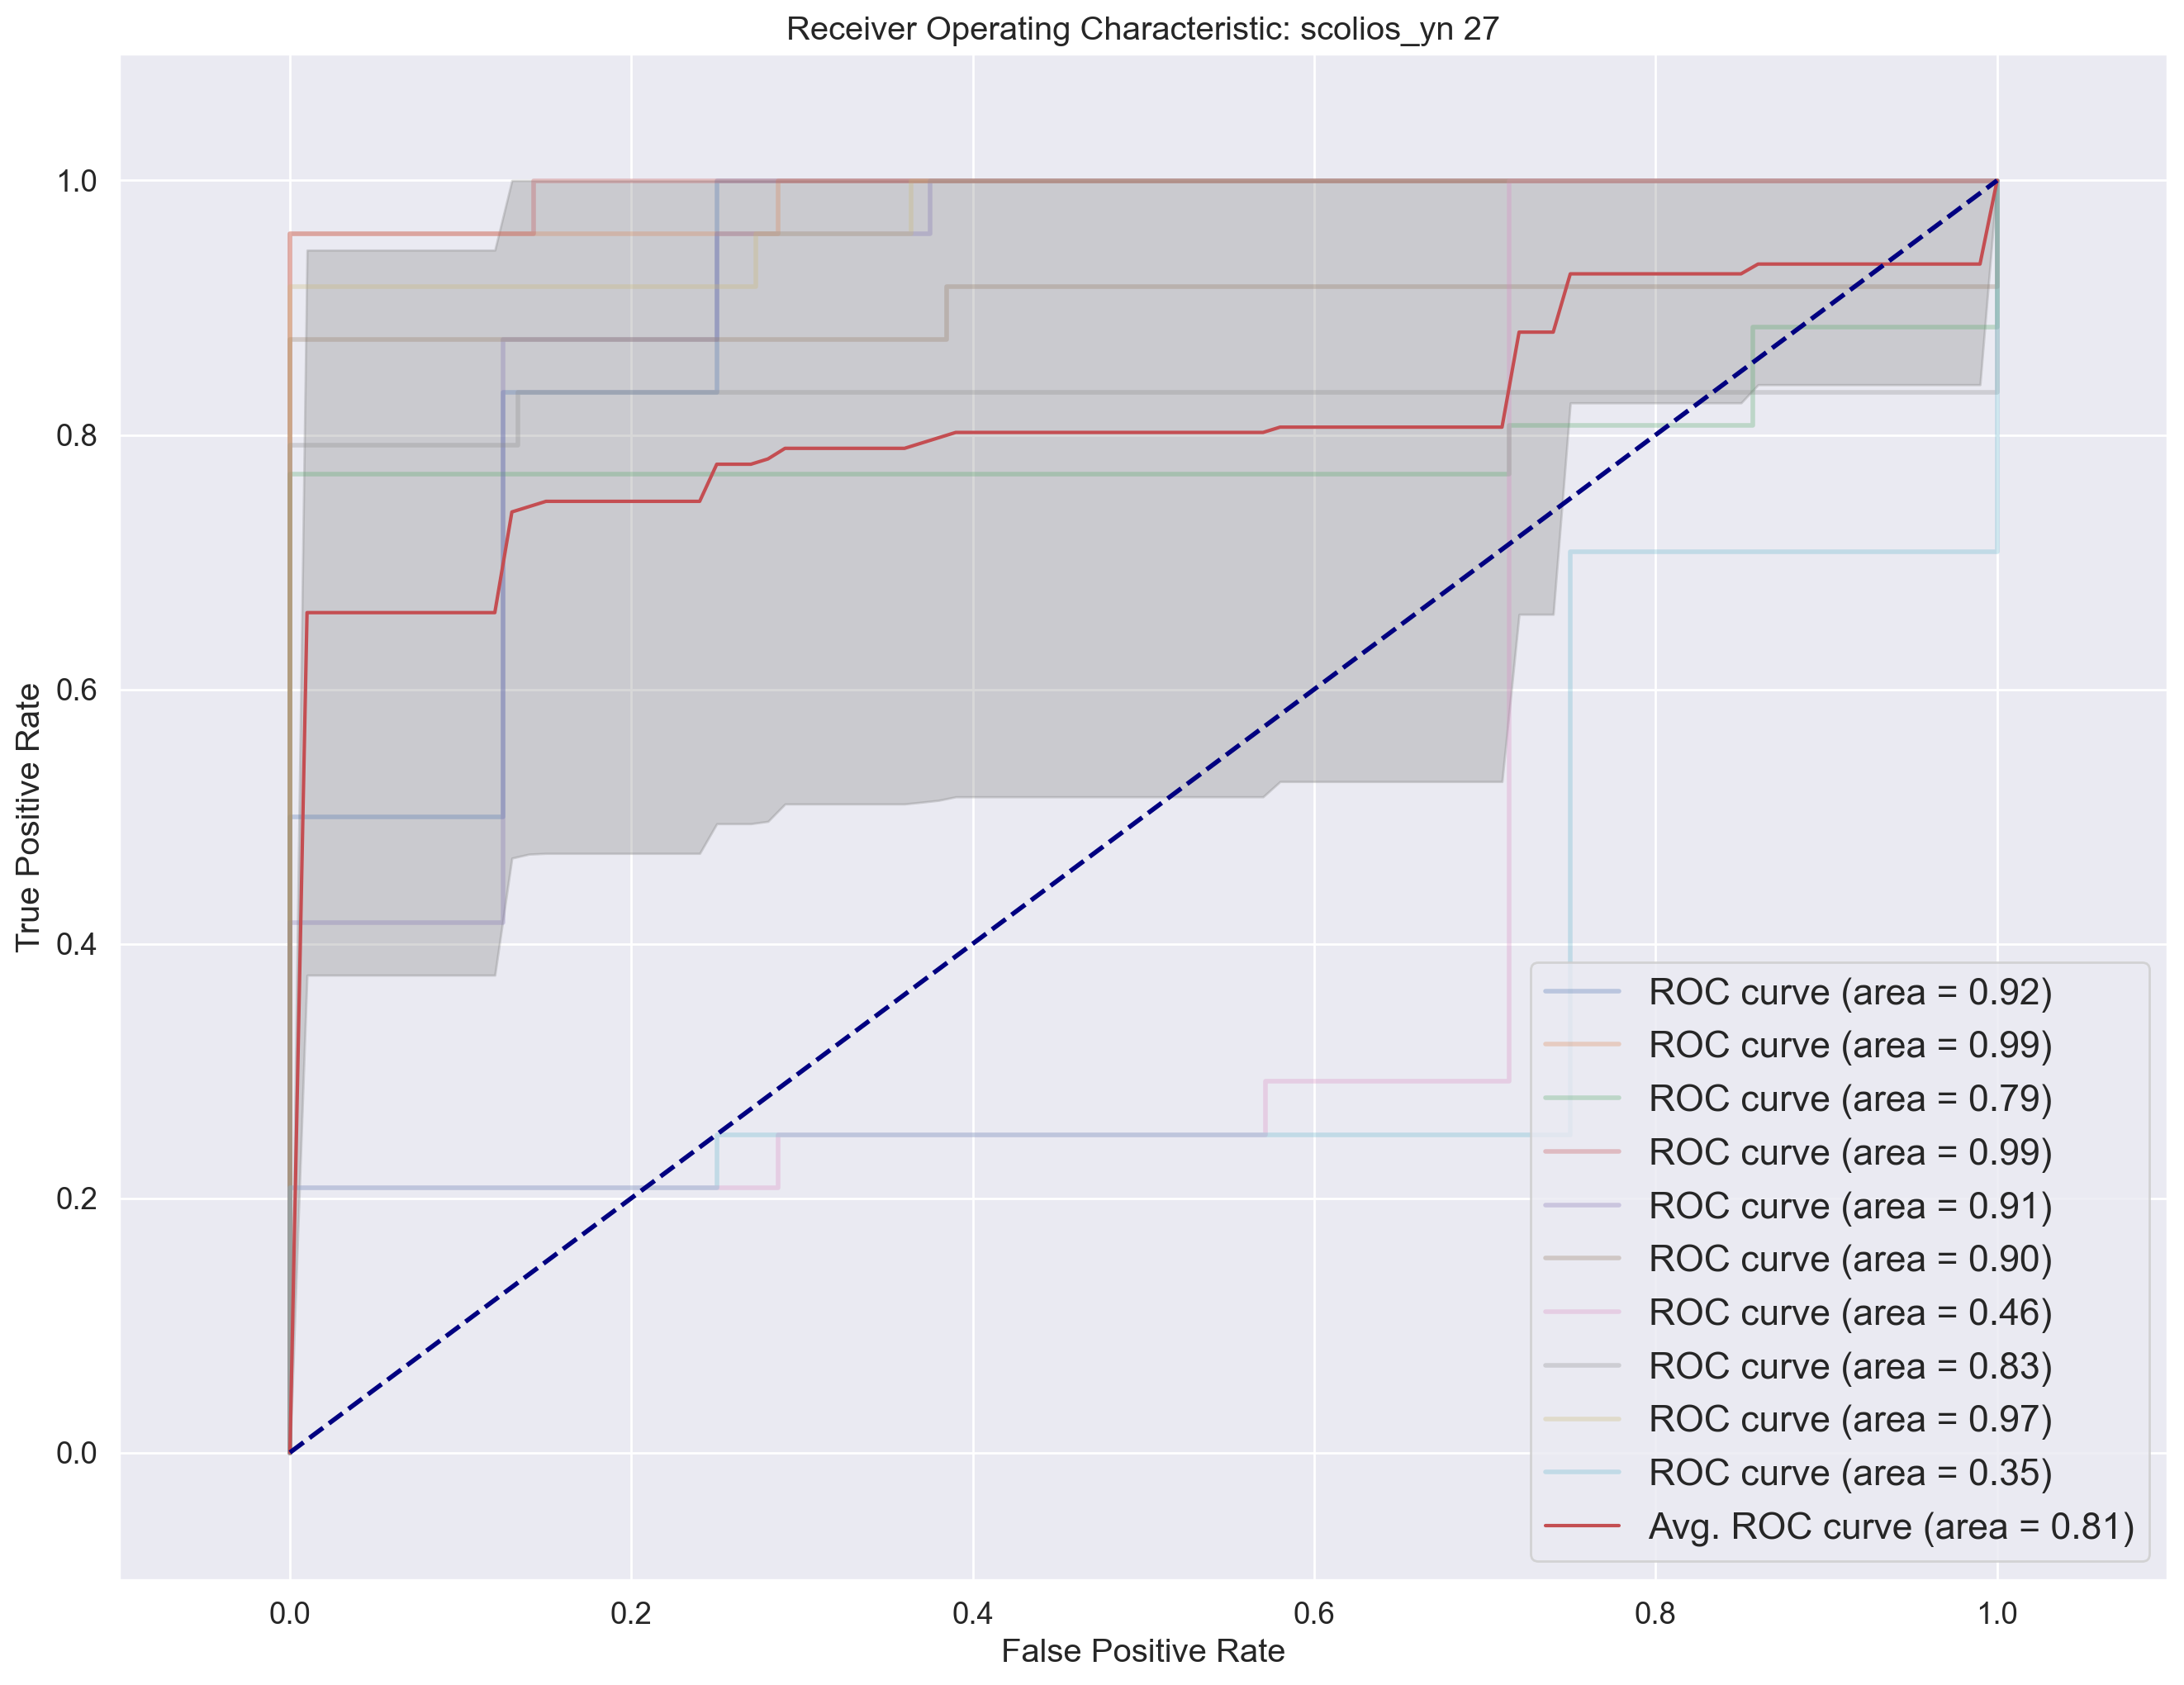

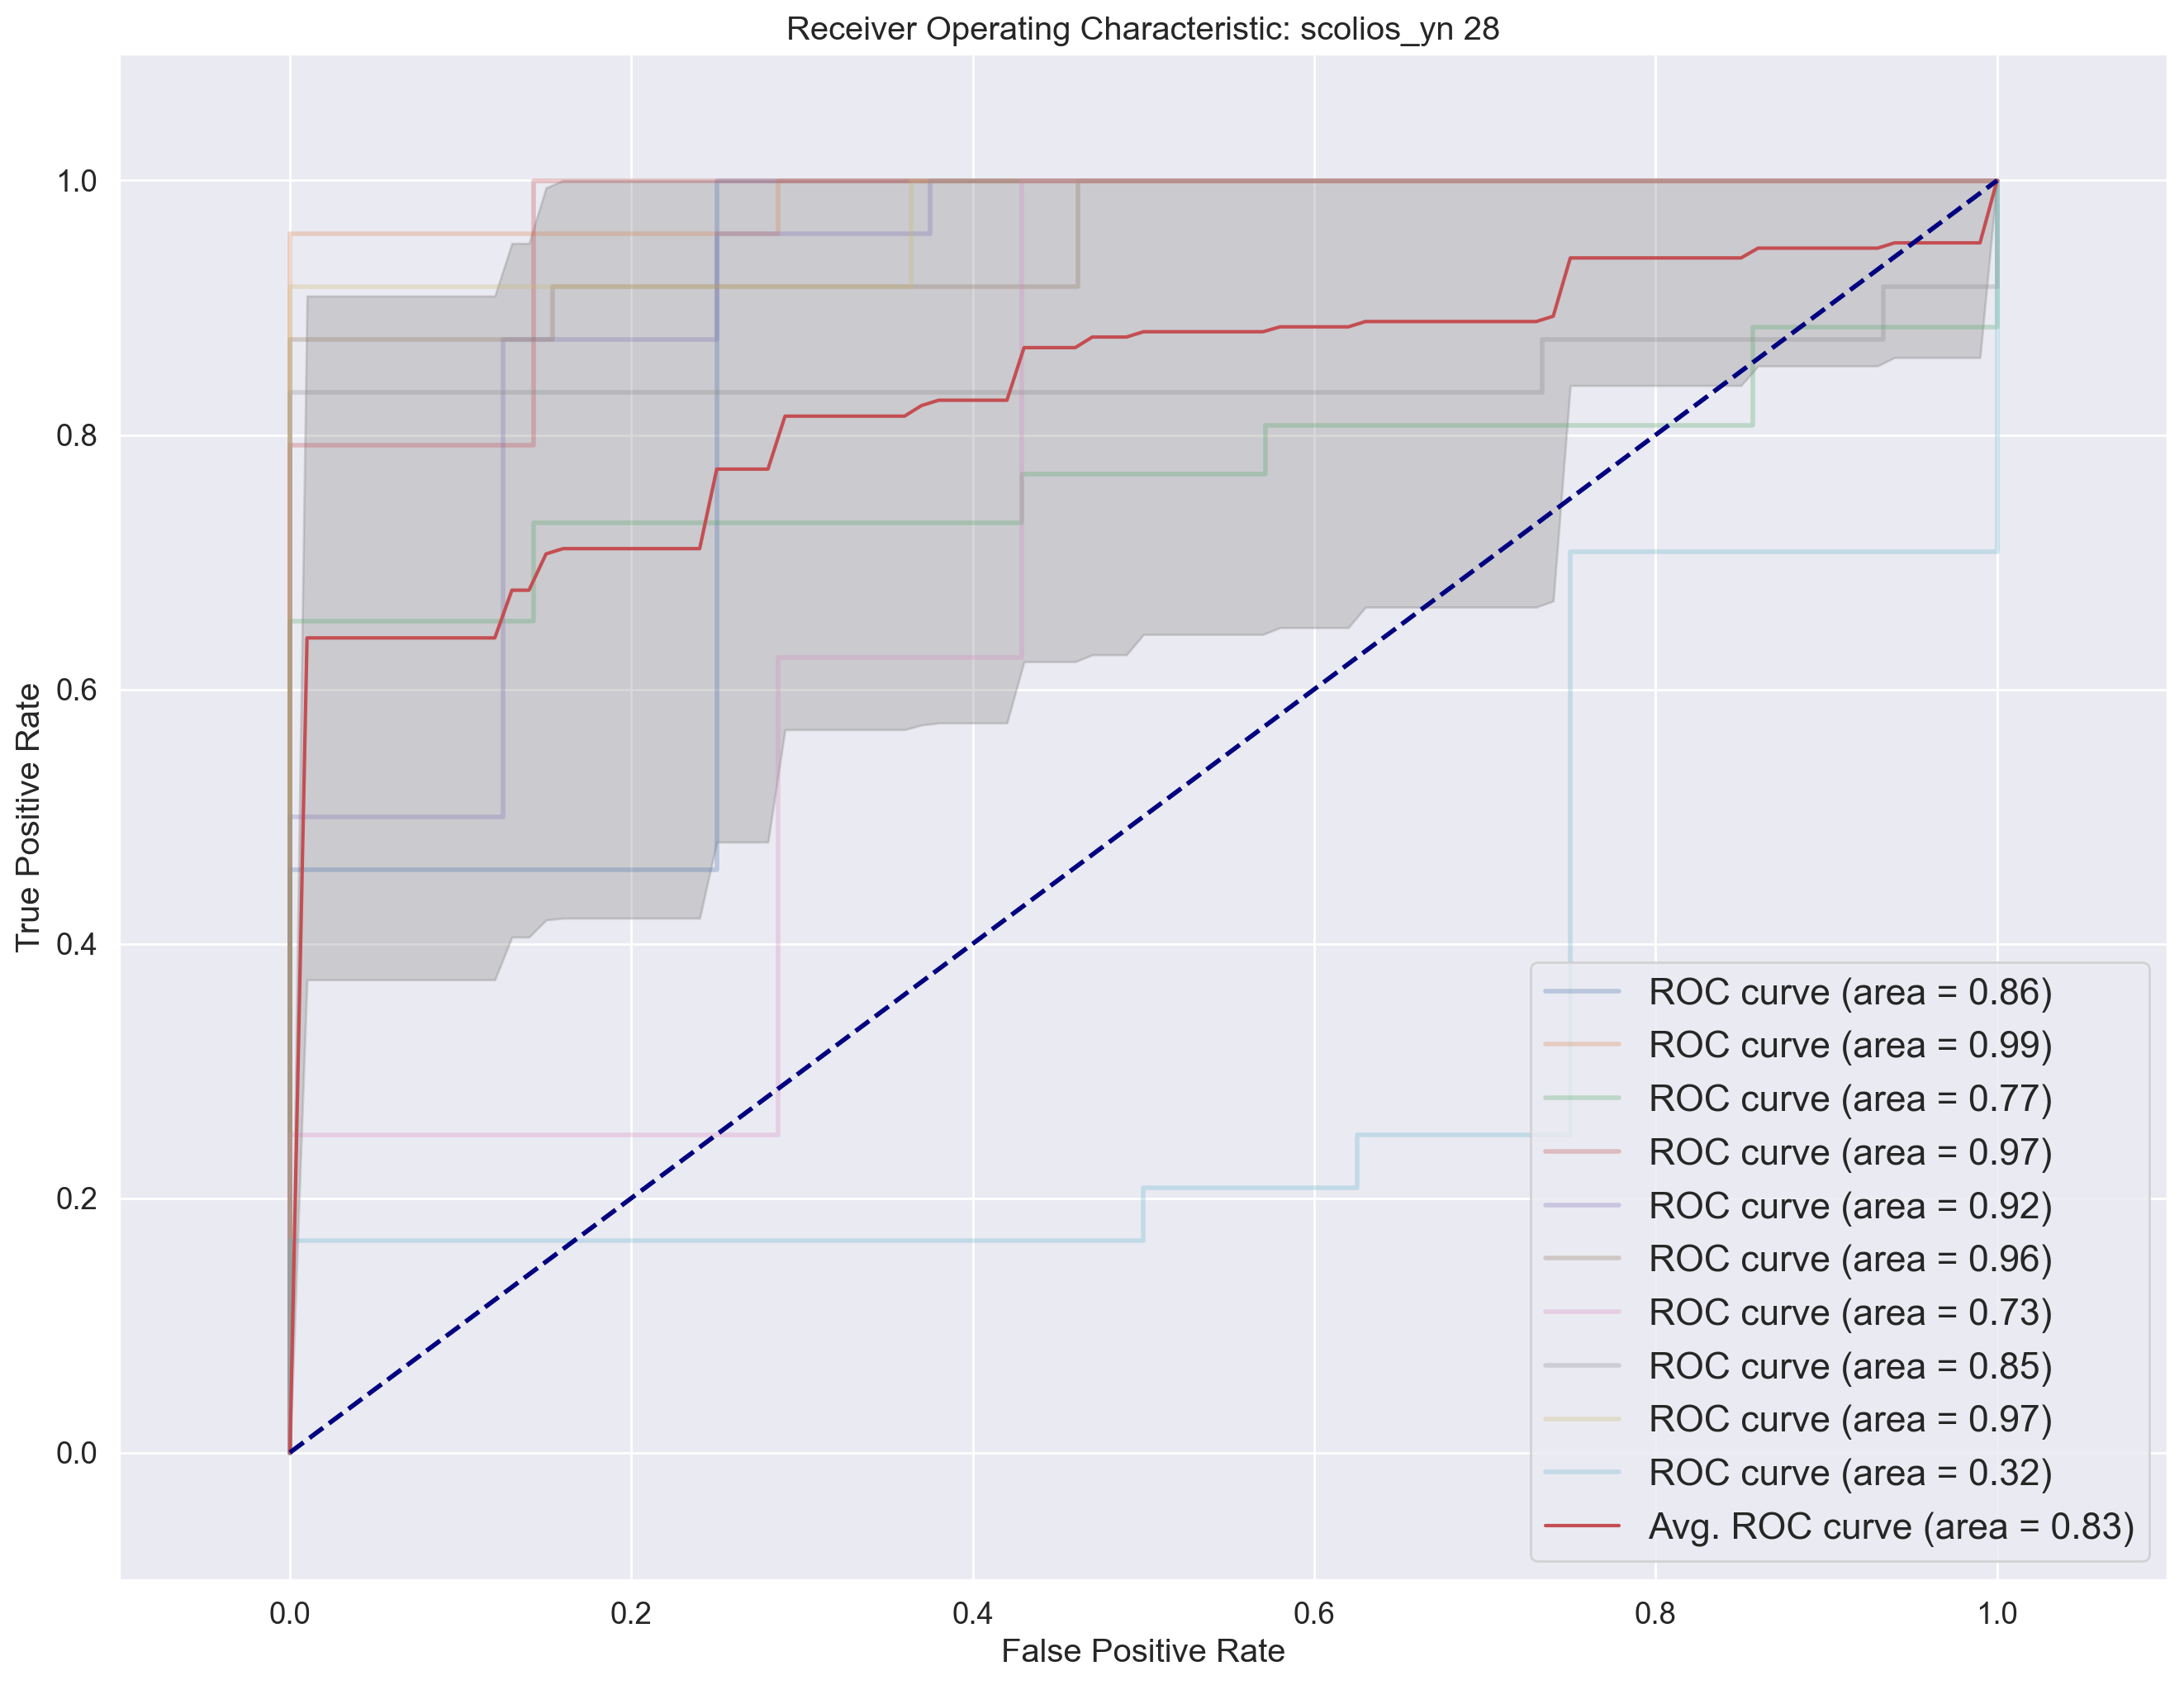

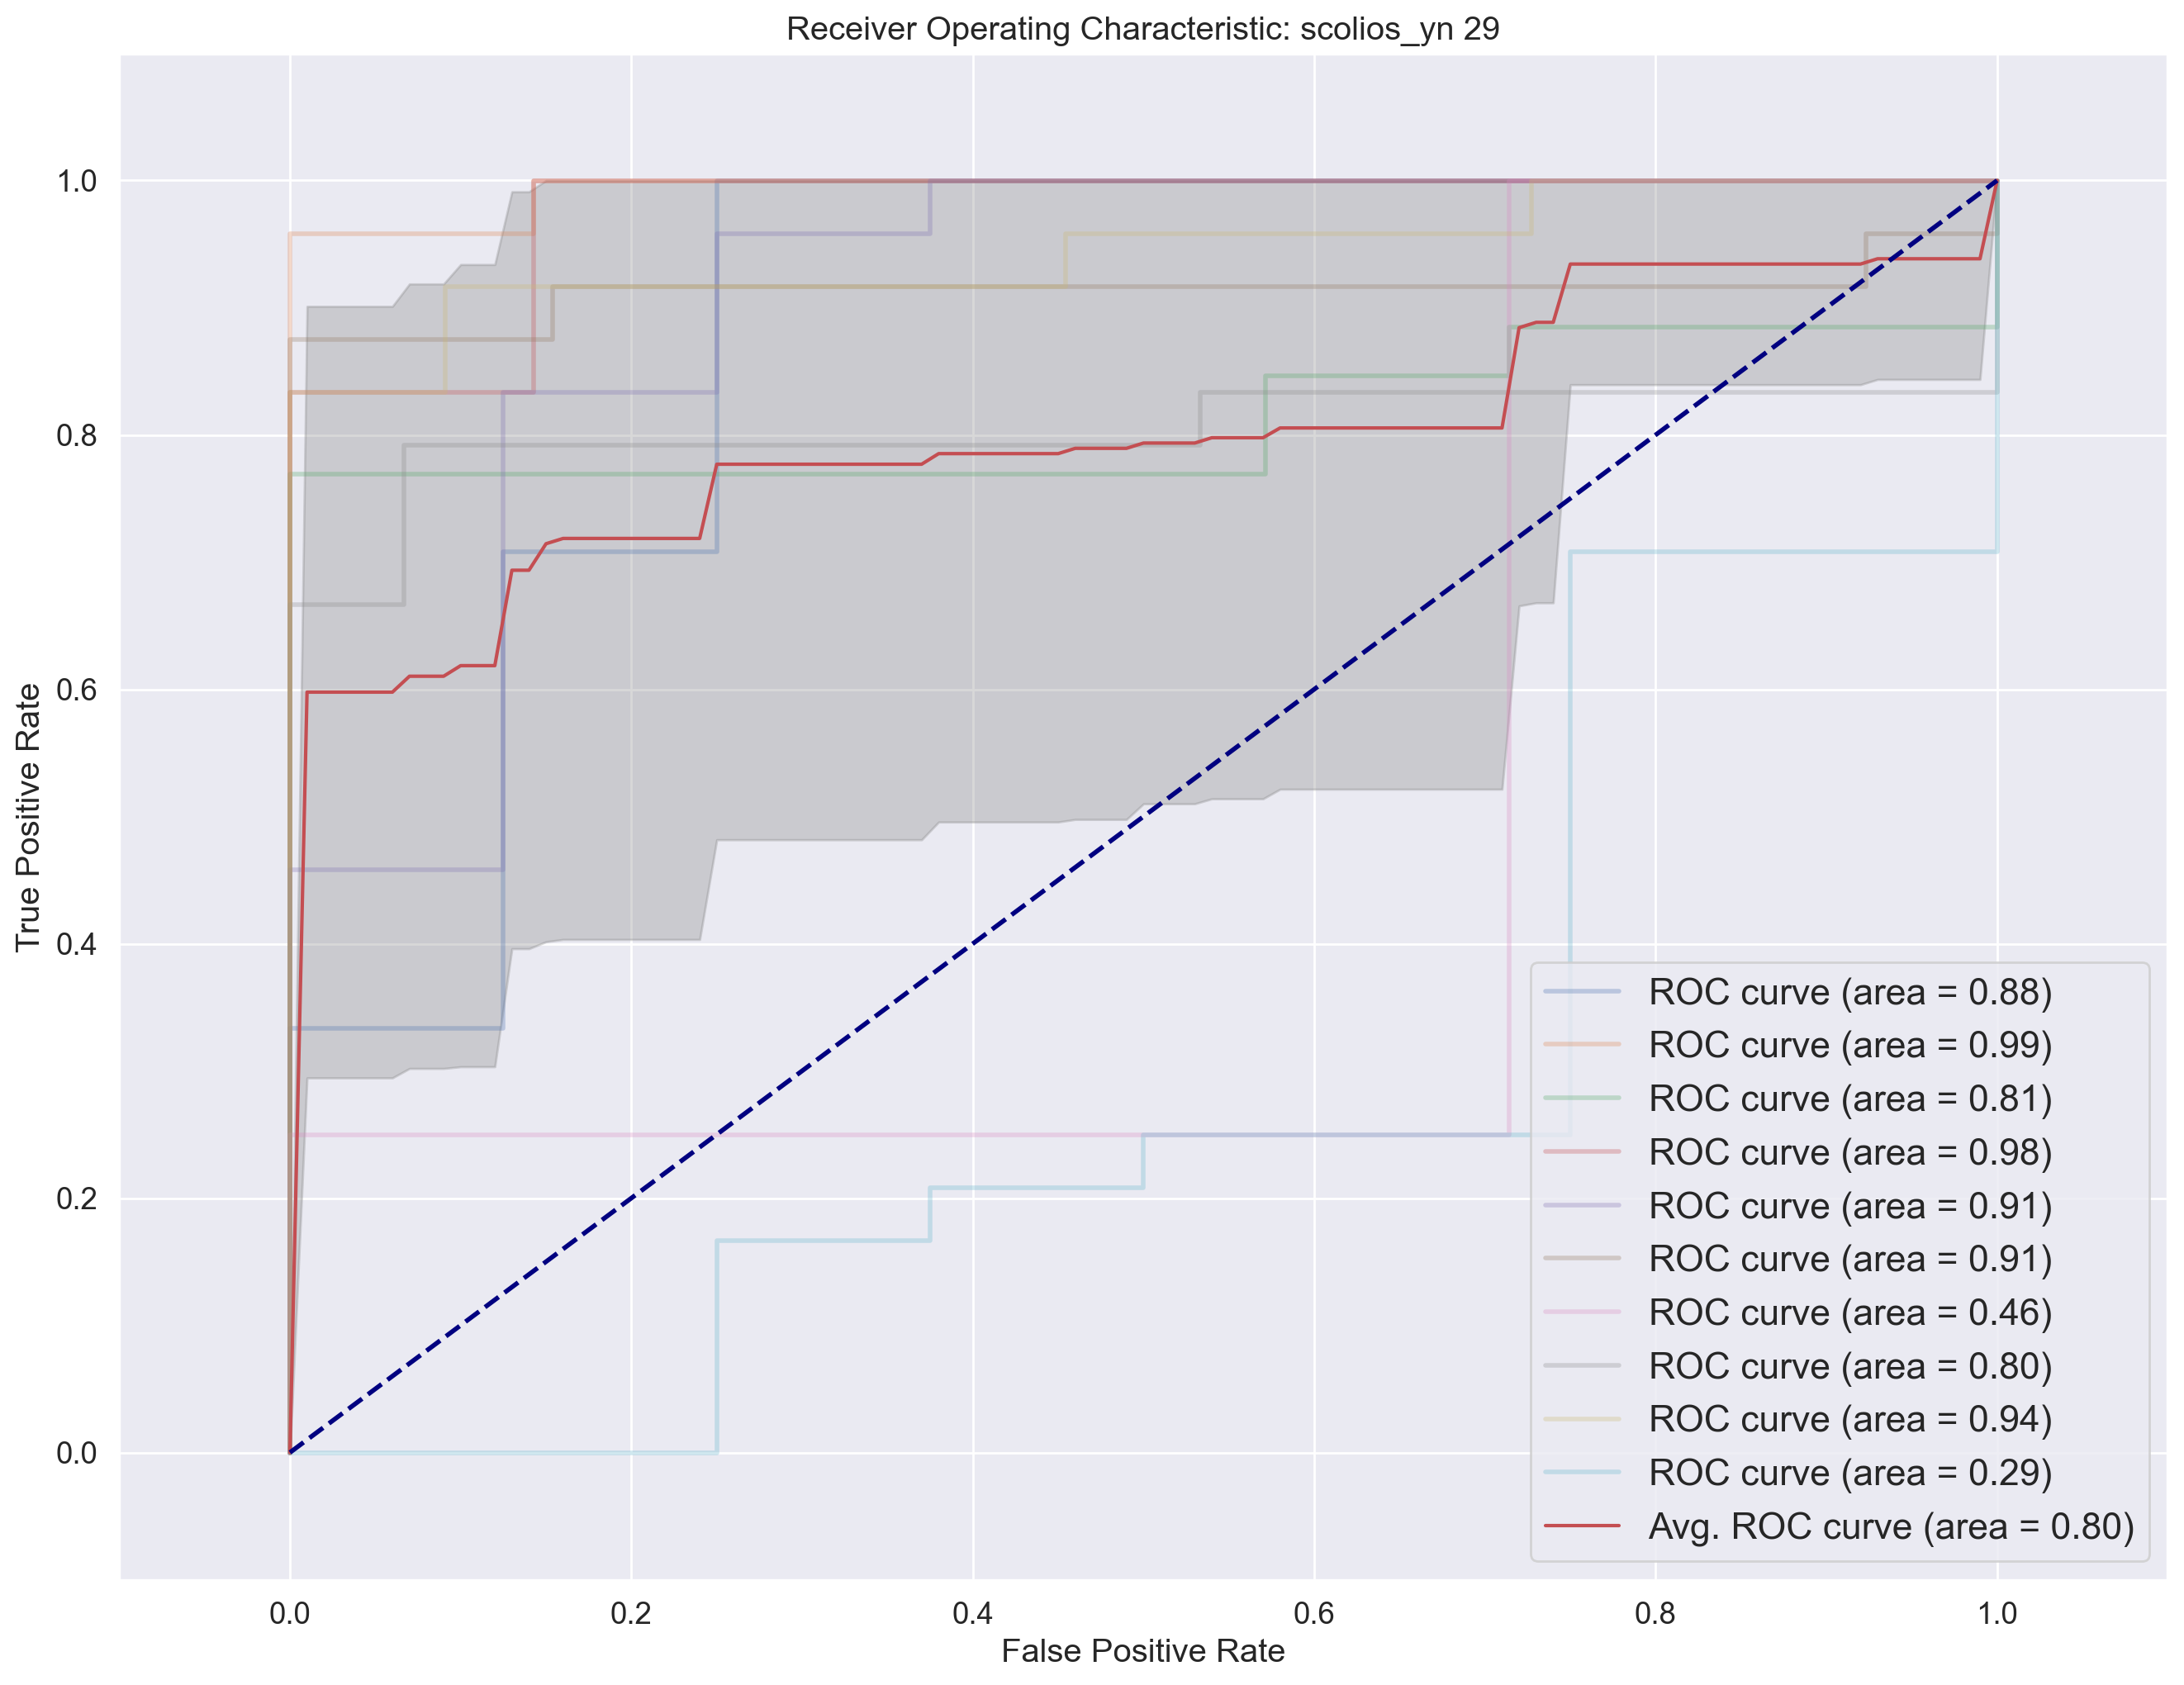

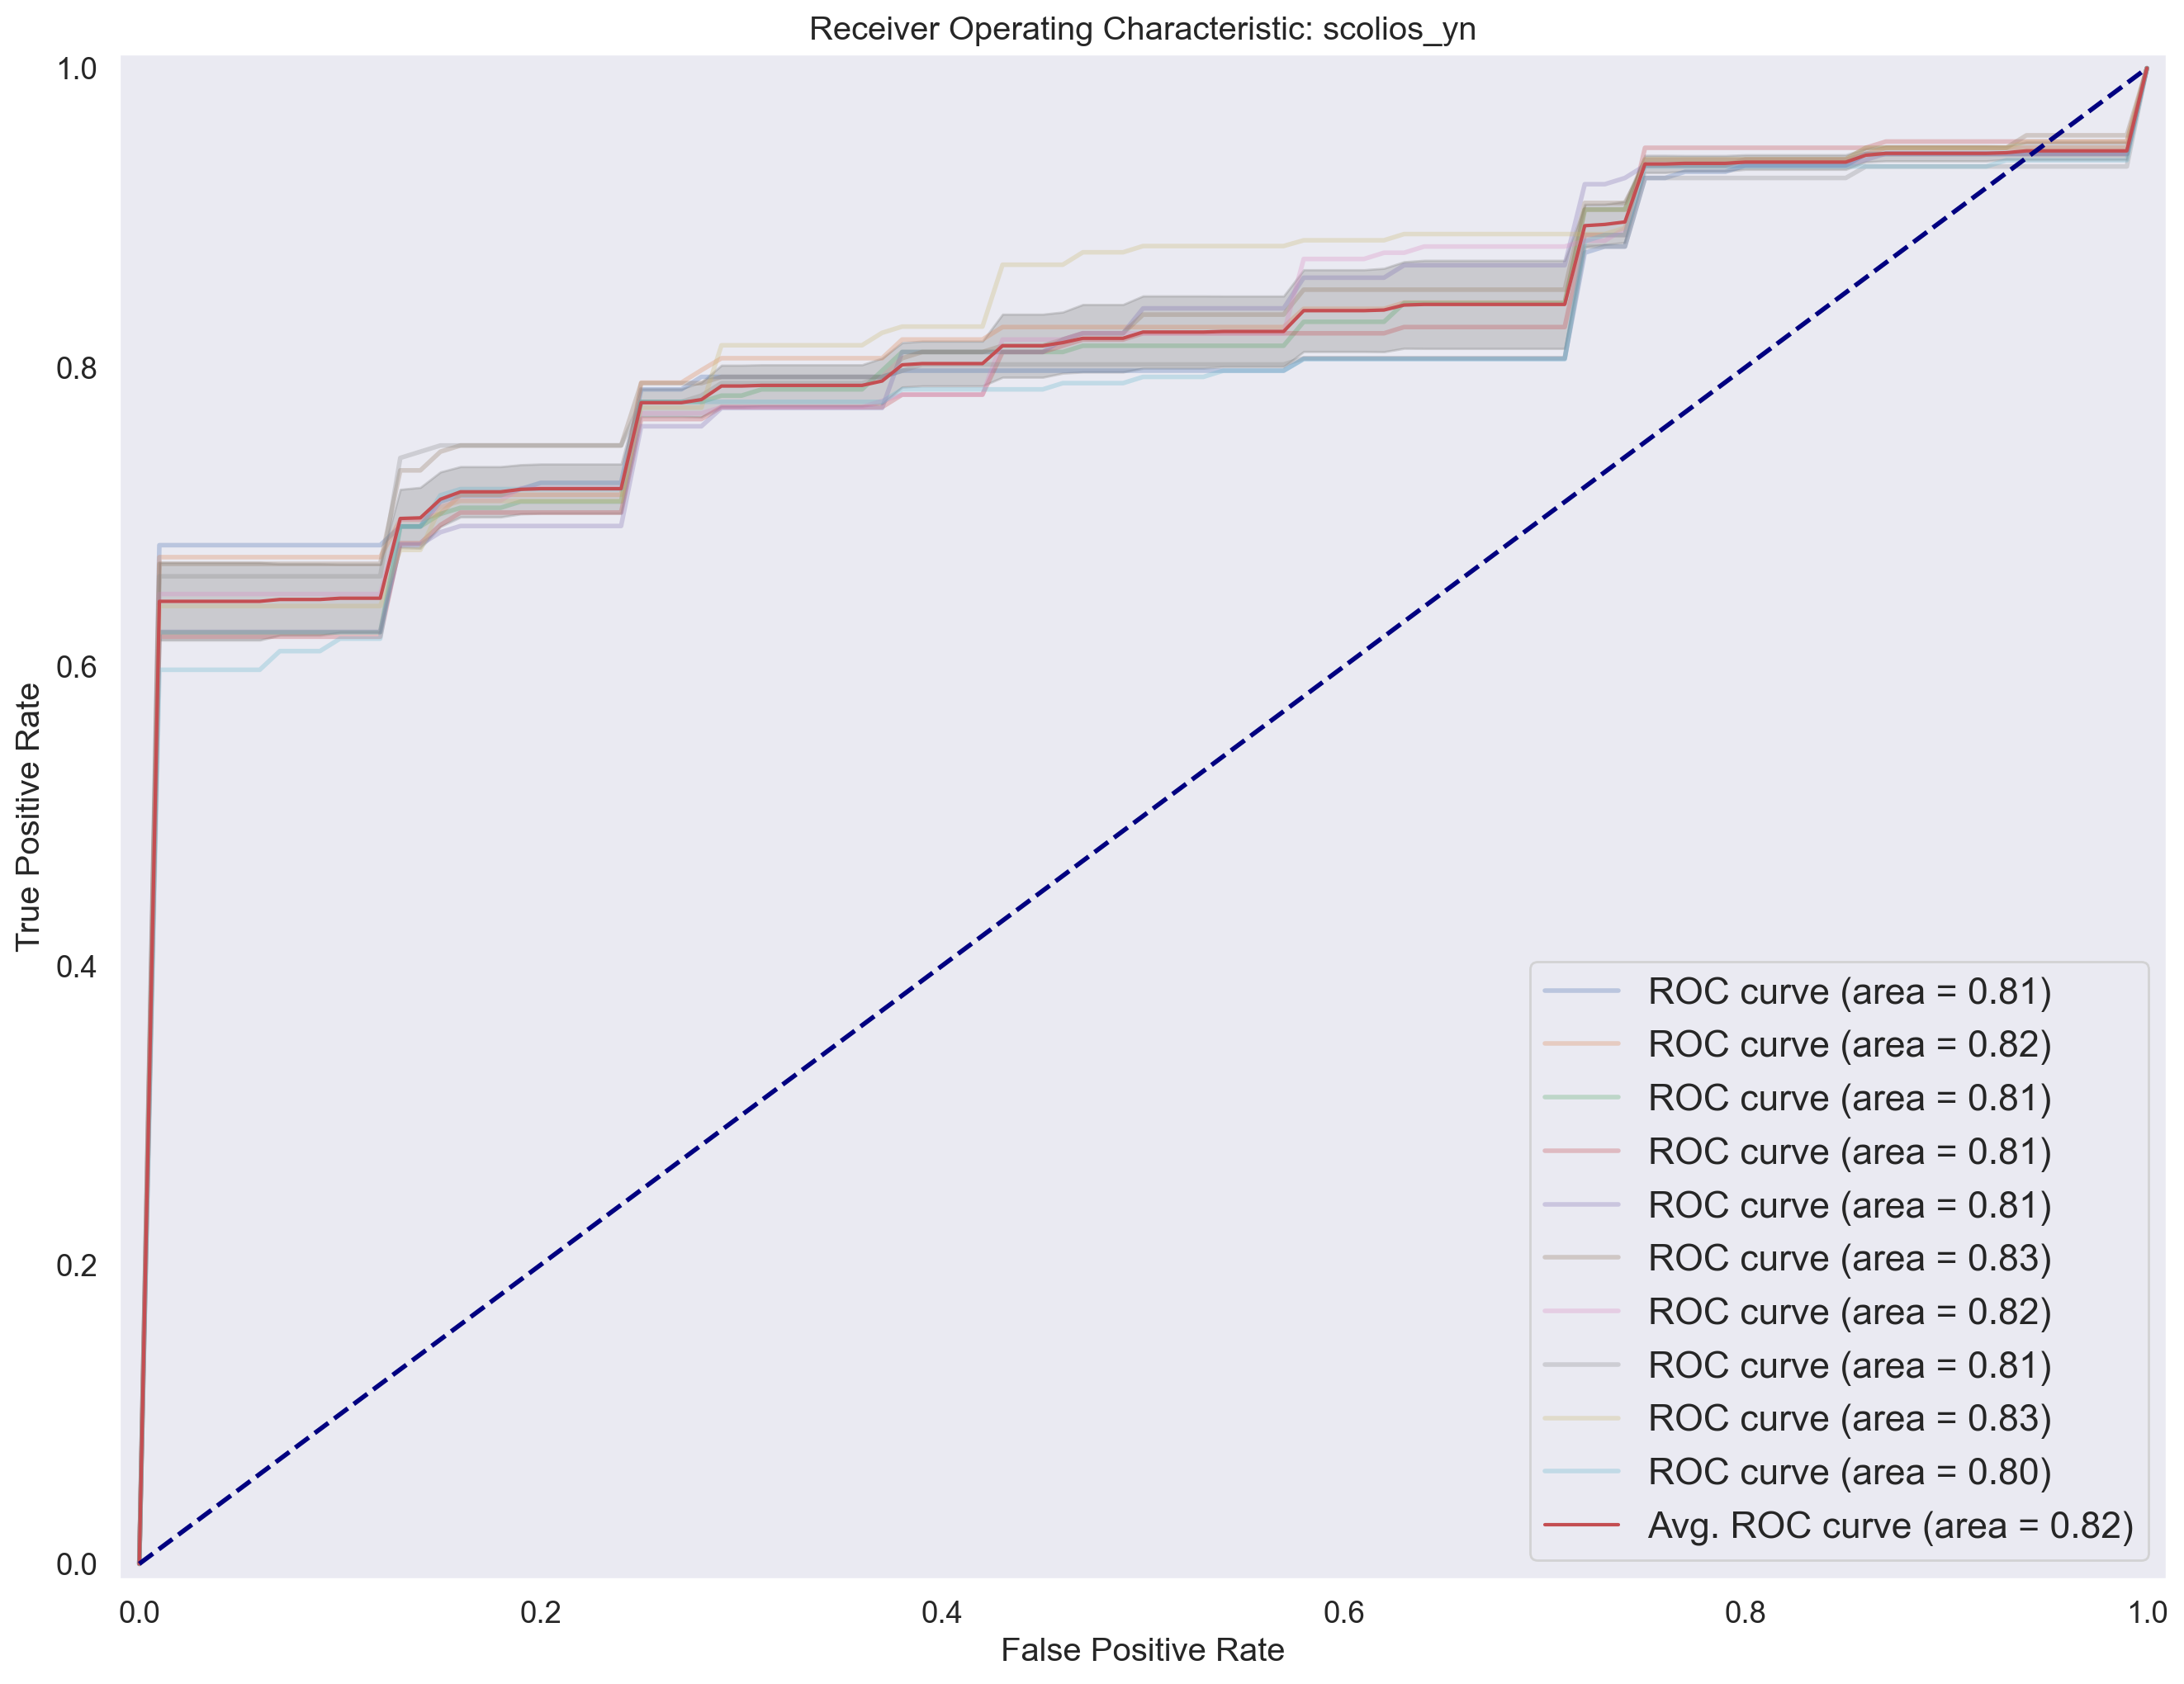

(0.7980048423798423, 0.0)

In [24]:
n_loops_over_groupKfold_models(np.arange(20,30), df_train, traincols, label, TARGET_DIR, DPI)

# Validation: save model and test on unknown IDs


In [25]:
# Checkpoint: make sure that all record_ids are separate in train and validation sets 
# define list of patient IDs that have no labels to perform true validation on 

# define all record_ids and train_ids
all_numbers = df_main['record_id']
train_ids = df_train['record_id']

# subtract all record_ids with train_ids to get the true validation ids 
all_numbers = set(np.arange(1, all_numbers.max()+1)) # set makes sure that it only looks at unique numbers 
train_ids = set(train_ids)

true_valid_ids = list(sorted(all_numbers - train_ids))


print("Missing numbers: These record_ids do not have a scoliosis label", true_valid_ids, "Number of missing IDs", len(true_valid_ids))


"""
save the true_valid ids using pickle 
"""
with open(PICKLES_DIR+'true_valid_ids.pickle', 'wb') as f: 
    pickle.dump(true_valid_ids, f)

Missing numbers: These record_ids do not have a scoliosis label [1, 3, 6, 16, 19, 24, 29, 31, 33, 34, 35, 42, 43, 48, 64, 66, 67, 68, 72, 73, 75, 76, 77, 81, 82, 84, 85] Number of missing IDs 27


In [26]:
"""
Note: 
df_train_all contains all record_ids with and without labels (must be kept separate from the other record_ids that have absolutely no labels)
df_train is the training set with labeled data 
df_train_
"""

# mask to select certain rows 
mask = df_main['record_id'].isin(train_ids)
df_train_all = df_main[mask]
print(df_train_all.shape)

# calculate the number of missing labels in the df_train_all 
df_train_unlabeled_mask = df_train_all['scoliosis_yn'].isna()
df_train_unlabeled = df_train_all[df_train_unlabeled_mask]
print(df_train_unlabeled.shape)
# the sum of df_train and df_train 

(545, 325)
(212, 325)


In [27]:
"""
Note: 
get the true validation set from the df_main dataset 
"""
# mask to select certain rows 
mask = df_main['record_id'].isin(true_valid_ids)
df_validation = df_main[mask]
df_validation.shape

(150, 325)

## Training data set statistics


In [28]:
# SciRep Revisions: Get the train data set demographics

# select columns that contain relevant demographic data 
demographic_cols = ['record_id', 'sma_type', 'gender', 'smn2_copies',
                    'age_assess',
                    'ventilation_term',
                    'orthoses_score',
                    'contractures_score',
                    'hfmse_motor_score',
                    'chop_motor_score', 
                    'scoliosis_yn', 'xspine_cobb', 
                    'age_onset_months', 'therapy_score', 'therapy_age']

train_demographics = df_train.copy()

train_demographics = train_demographics[demographic_cols]   # select only relevant columns

print(train_demographics['scoliosis_yn'].value_counts())
print(train_demographics['sma_type'].value_counts())

# therapy = {"1" : "NUS", "2" : "RIS", "3": "NUS + RIS", "4" : "ONA", "5" : "NUS + ONA", "6" : "ONA + RIS", "-1" : "Unknown"}

print(train_demographics['therapy_score'].value_counts(sort=False))

dtale.show(train_demographics.describe().round(2))

scoliosis_yn
1.0    242
0.0     91
Name: count, dtype: int64
sma_type
2.0    147
1.0    104
3.0     82
Name: count, dtype: int64
therapy_score
0     11
1    202
3     37
4     27
5     42
6      9
2      5
Name: count, dtype: int64


In [29]:
# SciRep Revisions: Get the test data set demographics

true_valid_demographics = df_validation.copy()

true_valid_demographics = true_valid_demographics[demographic_cols]   # select only relevant columns

# dfs_true_valid_demographics = DataFrameSummary(true_valid_demographics[selected_features])

print(true_valid_demographics['scoliosis_yn'].value_counts())
print(true_valid_demographics['sma_type'].value_counts())

print(true_valid_demographics['therapy_score'].value_counts())

dtale.show(true_valid_demographics.describe().round(2))

Series([], Name: count, dtype: int64)
sma_type
1.0    66
2.0    42
3.0    29
Name: count, dtype: int64
therapy_score
1    58
5    42
4    21
0    20
2     5
6     2
3     2
Name: count, dtype: int64


In [30]:
for i, traincol in enumerate(traincols):
    print(i, traincol)

0 age_assess
1 ventilation_term
2 orthoses_score
3 contractures_score
4 hfmse_motor_score
5 chop_motor_score


In [31]:
# Using place holders 
print("Feature '%s' is part of %i features "%(traincols[0], len(traincols)))

print(f"Feature '{traincols[0]}' is part of {len(traincols)} features ")

Feature 'age_assess' is part of 6 features 
Feature 'age_assess' is part of 6 features 


For Random State 20.000000 | avg ROC score 0.811281
For Random State 21.000000 | avg ROC score 0.823695
For Random State 22.000000 | avg ROC score 0.810980
For Random State 23.000000 | avg ROC score 0.807041
For Random State 24.000000 | avg ROC score 0.813738
For Random State 25.000000 | avg ROC score 0.827723
For Random State 26.000000 | avg ROC score 0.818410
For Random State 27.000000 | avg ROC score 0.811067
For Random State 28.000000 | avg ROC score 0.833071
For Random State 29.000000 | avg ROC score 0.798005
Single: For Random State 29.000000 | avg ROC score 0.524288
Single: For Random State 29.000000 | avg ROC score 0.564848
Single: For Random State 29.000000 | avg ROC score 0.575928
Single: For Random State 29.000000 | avg ROC score 0.583948
Single: For Random State 29.000000 | avg ROC score 0.724504
Single: For Random State 29.000000 | avg ROC score 0.750113
Average AUC score: 0.815501


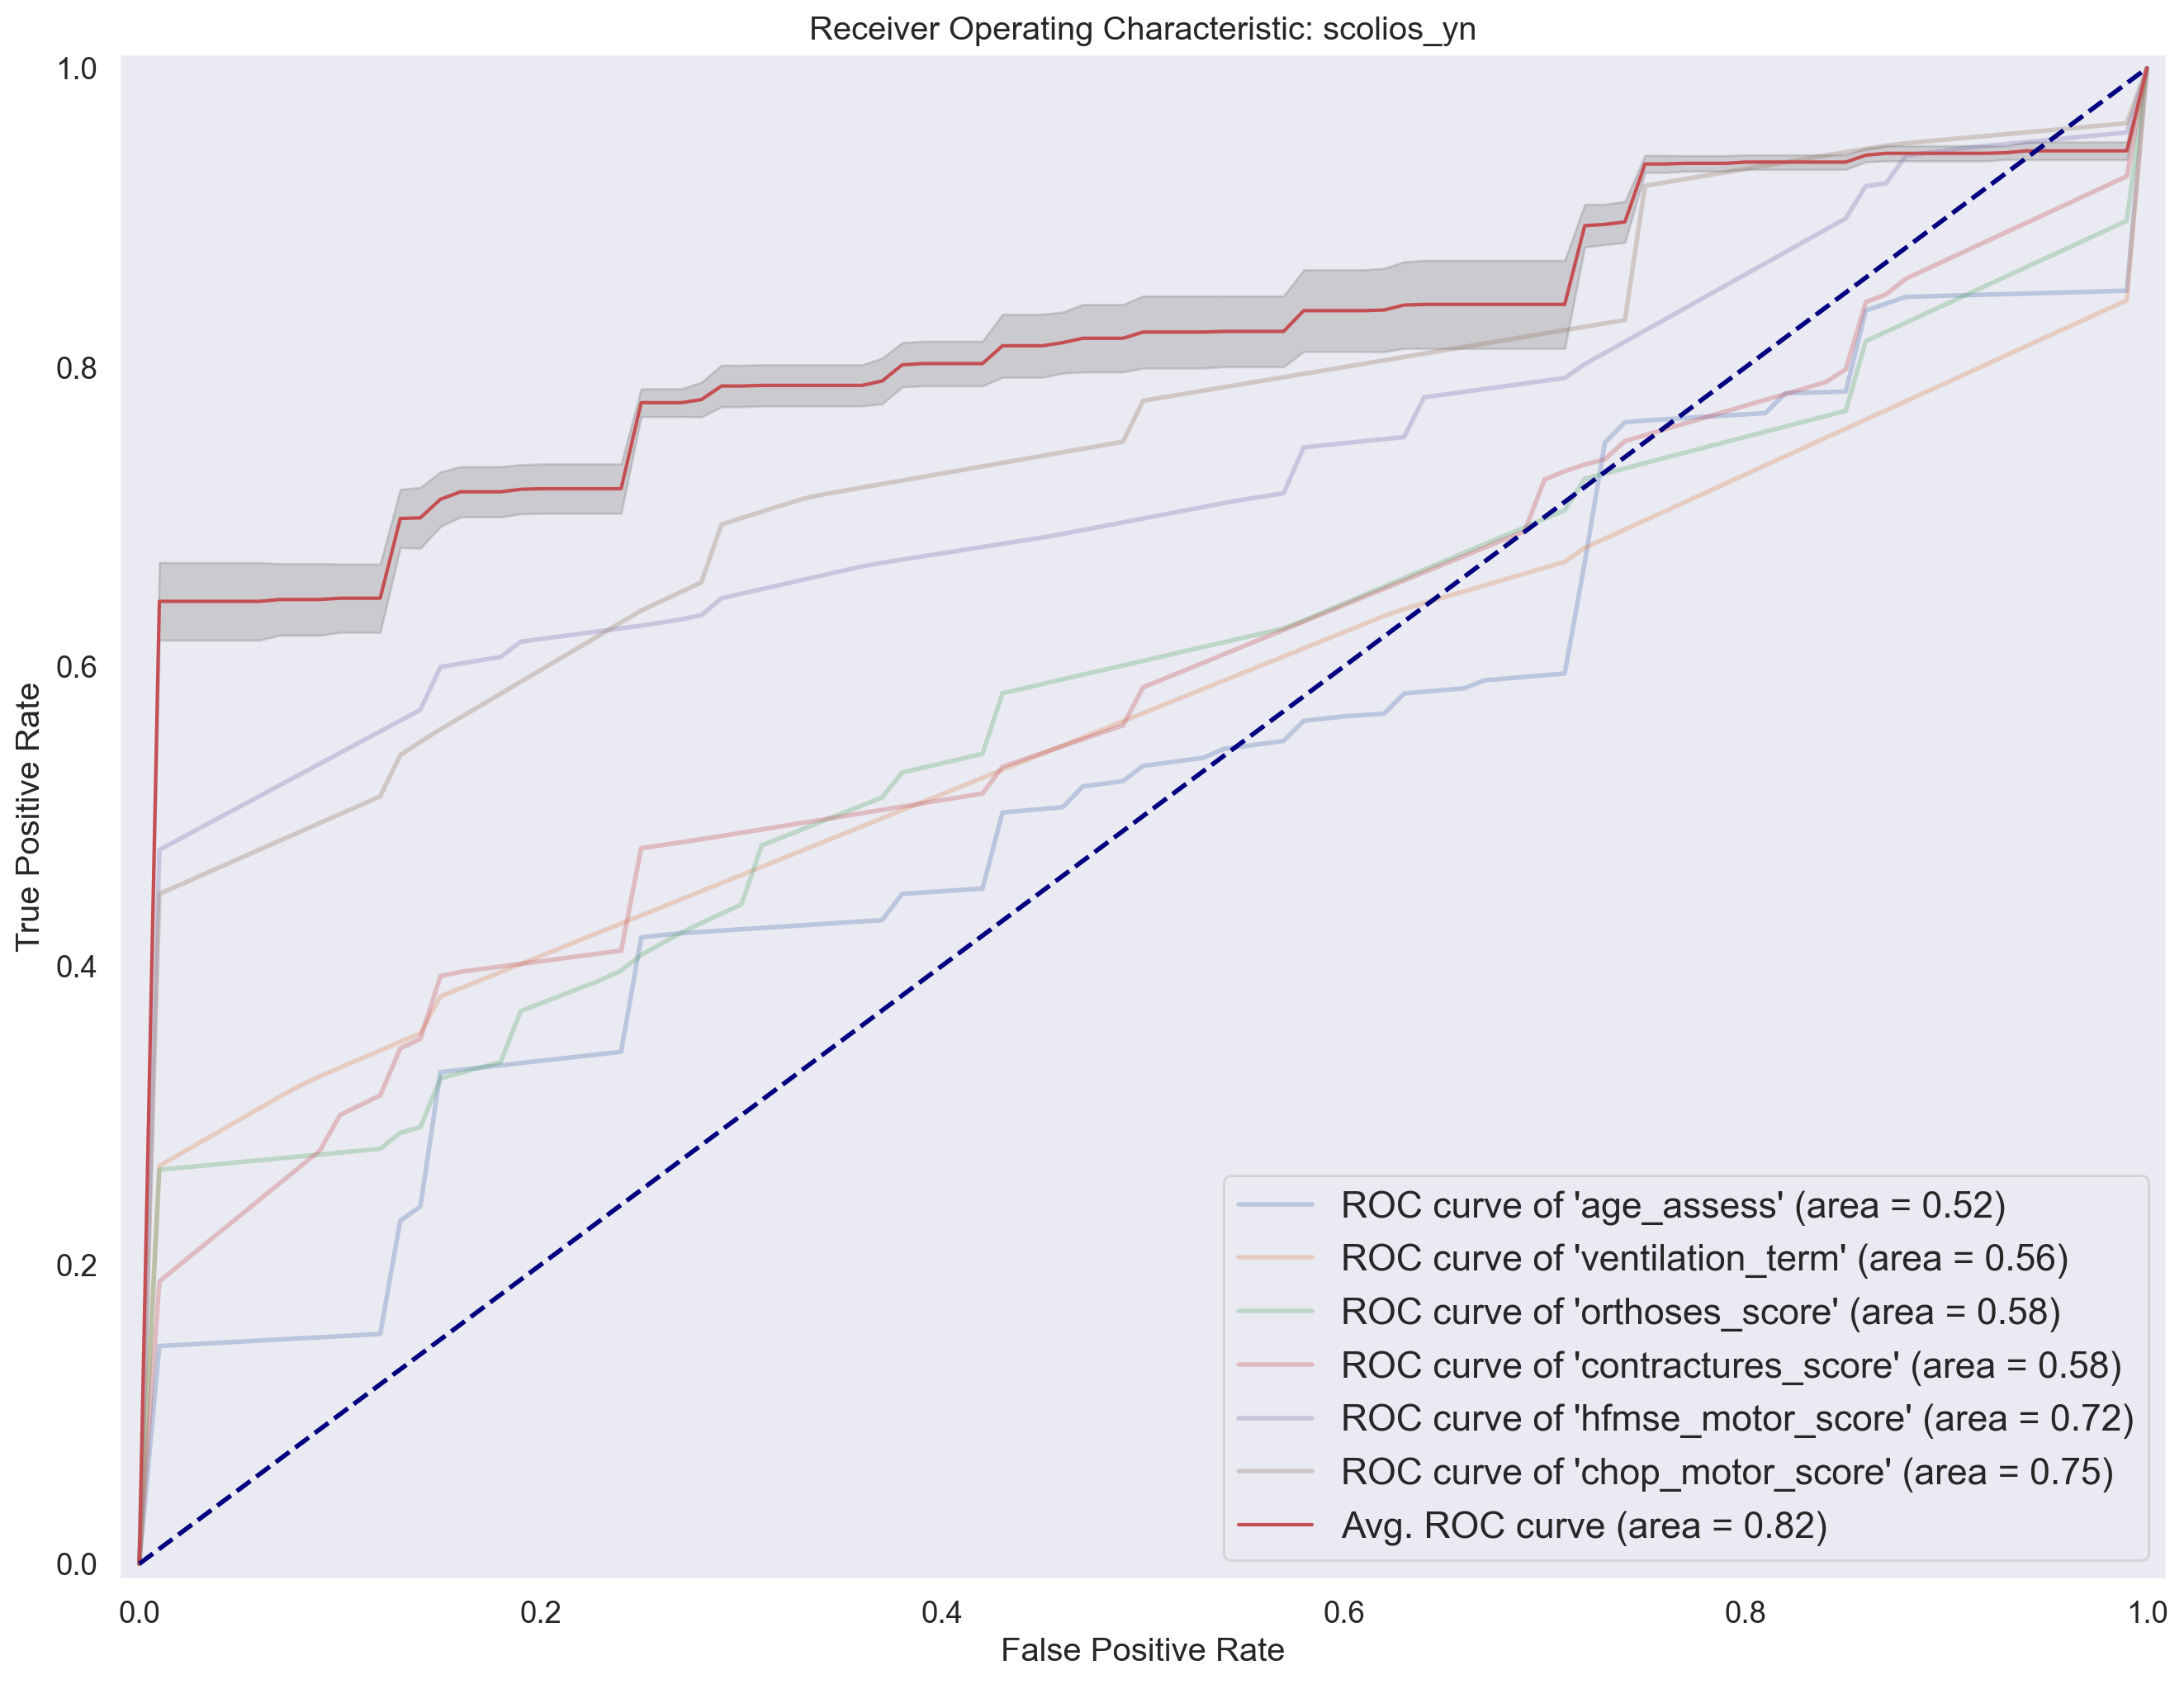

(0.7501127518315018, 0.0)

In [32]:
n_loops_over_groupKfold_models_revisions(np.arange(20,30), df_train, traincols, label, TARGET_DIR)

# Save Model and export


In [33]:
# save model of fold i-1 using joblib
i = 3
joblib.dump(models[i], filename=TARGET_DIR + f'smascoliosis_rfc_model_{i}.joblib')

['figures/smascoliosis_rfc_model_3.joblib']

In [34]:
# save all ten-fold models using joblib
joblib.dump(models, filename=TARGET_DIR + 'smascoliosis_rfc_models.joblib')

['figures/smascoliosis_rfc_models.joblib']

# Evaluate the model: patient predictions


In [35]:
pdf = PdfPages(TARGET_DIR +'patient_predictions_Main.pdf')

#with DF_main
for patient_id in df_train['record_id'].unique():
    
    # get the x_ray date
    xrayed_age = df_main['age_xspine'][df_main['record_id']==patient_id].unique()
    therapy_age = df_main['therapy_age'][df_main['record_id']==patient_id].unique()
    
    # Extract patient input data and ground truth
    df_patient = df_main[df_main['record_id']==patient_id]
    df_patient_GT = df_patient['scoliosis_yn']
    df_age_assess = df_patient['age_assess']

    df_patient_input = df_patient[traincols].fillna(value=-1)
    df_patient_input= sc.transform(df_patient_input)

    # Evaluate the learnt model on the patient trajectory
    df_patient_predict = []
    for fold_num in range(len(models)):
        df_patient_predict.append(models[fold_num].predict_proba(df_patient_input)[:,1])
        
    df_patient_predict = np.array(df_patient_predict) # convert to array
    df_patient_predict_std = np.divide(np.std(df_patient_predict,axis=0),np.sqrt(len(models)))
    df_patient_predict_mean = np.mean(df_patient_predict,axis=0)
    
    # Forward loop for each fold
    df_patient_predict_binary = []
    for fold_num in range(len(models)):
         df_patient_predict_binary.append(models[fold_num].predict(df_patient_input))
            
    df_patient_predict_binary = np.array(df_patient_predict_binary) # convert to array
    df_patient_predict_binary_std = np.std(df_patient_predict_binary,axis=0)
    df_patient_predict_binary_mean = np.mean(df_patient_predict_binary,axis=0)
    
    x_axis = df_age_assess.values
    
    # Plot patient GT vs Model_Predicted
    plt.title('Patient Id %d'%(patient_id))
    plt.plot(x_axis, df_patient_GT.values,'ro',label='scoliosis label')
    plt.errorbar(x_axis, df_patient_predict_mean, yerr =df_patient_predict_std, c='green', fmt='--', capsize=0.1, label='mean_pred_prob')
    
    print(df_patient_GT.values,patient_id)
    
    for at_age in xrayed_age:
        if at_age is not np.nan:
            plt.axvline(x=at_age, linestyle='dashed', c='grey')
            
    for at_age in therapy_age:
        if at_age is not np.nan:
            plt.axvline(x=at_age, linestyle='dashed', c='lightblue')
    
    plt.xlabel('Age in Months')
    plt.ylabel('Prediction Probability')
    plt.ylim(-0.1, 1.1)
    plt.legend(bbox_to_anchor=(-1.05, 1.05), loc='lower right')
    pdf.savefig()
    plt.close()
    
pdf.close()

[nan  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.] 2
[0. 0. 0.] 4
[nan nan  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.] 5
[nan nan nan nan  1.  1.  1.] 7
[nan nan nan nan nan nan nan nan nan  1.  1.  1.  1.] 8
[nan nan nan nan nan nan  1.] 9
[1. 1. 1. 1. 1.] 10
[nan nan nan  1.  1.  1.  1.] 11
[nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan  1.  1.  1.
  1.] 12
[nan nan nan nan nan nan nan  1.] 13
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.] 14
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] 15
[1. 1. 1. 1. 1. 1. 1. 1. 1.] 17
[nan nan nan nan nan nan nan  0.  0.  0.] 18
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.] 20
[nan nan nan nan nan nan nan nan  1.] 21
[nan nan nan nan nan nan nan  1.  1.  1.] 22
[nan nan nan nan  0.] 23
[nan nan nan nan nan nan nan nan nan nan nan  0.  0.  0.  0.  0.] 25
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.] 26
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1.] 27
[nan nan nan  1.  1.  1.  1.  1.] 28
[1. 1. 1.

In [36]:
pdf = PdfPages(TARGET_DIR +'patient_predictions.pdf')

fold_num = 1
for patient_id in df_train['record_id'].unique():
    
    # get the x_ray date
    xrayed_age = df_main['age_xspine'][df_main['record_id']==patient_id].unique()
    
    # Extract patient input data and ground truth
    df_patient = df_train[df_train['record_id']==patient_id] 
    df_patient_GT = df_patient['scoliosis_yn']

    df_patient_input = df_patient[traincols].fillna(value=-1)
    df_patient_input= sc.transform(df_patient_input)

    # Evaluate the learnt model on the patient trajectory
    df_patient_predict = []
    for fold_num in range(len(models)):
        df_patient_predict.append(models[fold_num].predict_proba(df_patient_input)[:,1])
        
    df_patient_predict = np.array(df_patient_predict) # convert to array
    df_patient_predict_std = np.divide(np.std(df_patient_predict,axis=0),np.sqrt(len(models)))
    df_patient_predict_mean = np.mean(df_patient_predict,axis=0)
    
    # Forward loop for each fold
    df_patient_predict_binary = []
    for fold_num in range(len(models)):
         df_patient_predict_binary.append(models[fold_num].predict(df_patient_input))
            
    df_patient_predict_binary = np.array(df_patient_predict_binary) # convert to array
    df_patient_predict_binary_std = np.std(df_patient_predict_binary,axis=0)
    df_patient_predict_binary_mean = np.mean(df_patient_predict_binary,axis=0)
    
    x_axis = df_patient['age_assess']
    
    # Plot patient GT vs Model_Predicted
    plt.title('Patient Id %d'%(patient_id))
    plt.plot(x_axis, df_patient_GT.values,'ro',label='scoliosis label')
    plt.errorbar(x_axis, df_patient_predict_mean, yerr =df_patient_predict_std, c='green', fmt='--', capsize=0.1, label='mean_pred_prob')
    
    for at_age in xrayed_age:
        if at_age is not np.nan:
            plt.axvline(x=at_age,linestyle='dashed',c='grey')
    
    plt.xlabel('Age in Months')
    plt.ylabel('Prediction Probability')
    plt.ylim(-0.1, 1.1)
    plt.legend()
    pdf.savefig()
    plt.close()
    
pdf.close()

In [37]:
pdf = PdfPages(TARGET_DIR + 'patient_features.pdf')

for patient_id in df_train['record_id'].unique():

    # Extract patient input data and ground truth
    df_patient = df_train[df_train['record_id']==patient_id] 
    df_patient_GT = df_patient['scoliosis_yn']

    df_patient_input = df_patient[traincols].fillna(value=-1)
    df_patient_input= sc.transform(df_patient_input)
    x_axis = df_patient['age_assess']
    
    plt.plot(x_axis, df_patient_input,'x-',label=feature_names)
    plt.title('Patient Id %d'%(patient_id))
    plt.legend()
    plt.xlabel('Age in Months')
    plt.ylabel('Scaled Features')
    pdf.savefig()
    plt.close()
    
pdf.close()

In [38]:
pdf = PdfPages(TARGET_DIR + 'patient_features_original_vals.pdf')

for patient_id in df_train['record_id'].unique():

    # Extract patient input data and ground truth
    df_patient = df_main[df_main['record_id']==patient_id] 
    df_patient_GT = df_patient['scoliosis_yn']

    df_patient_input = df_patient[traincols].fillna(value=-1)
    x_axis = df_patient['age_assess']
    
    plt.plot(x_axis, df_patient_input,'x-',label=feature_names)
    plt.title('Patient Id %d'%(patient_id))
    plt.legend()
    plt.xlabel('Age in Months')
    plt.ylabel('Scaled Features')
    pdf.savefig()
    plt.close()
    
pdf.close()

# GroupKFold Visualization


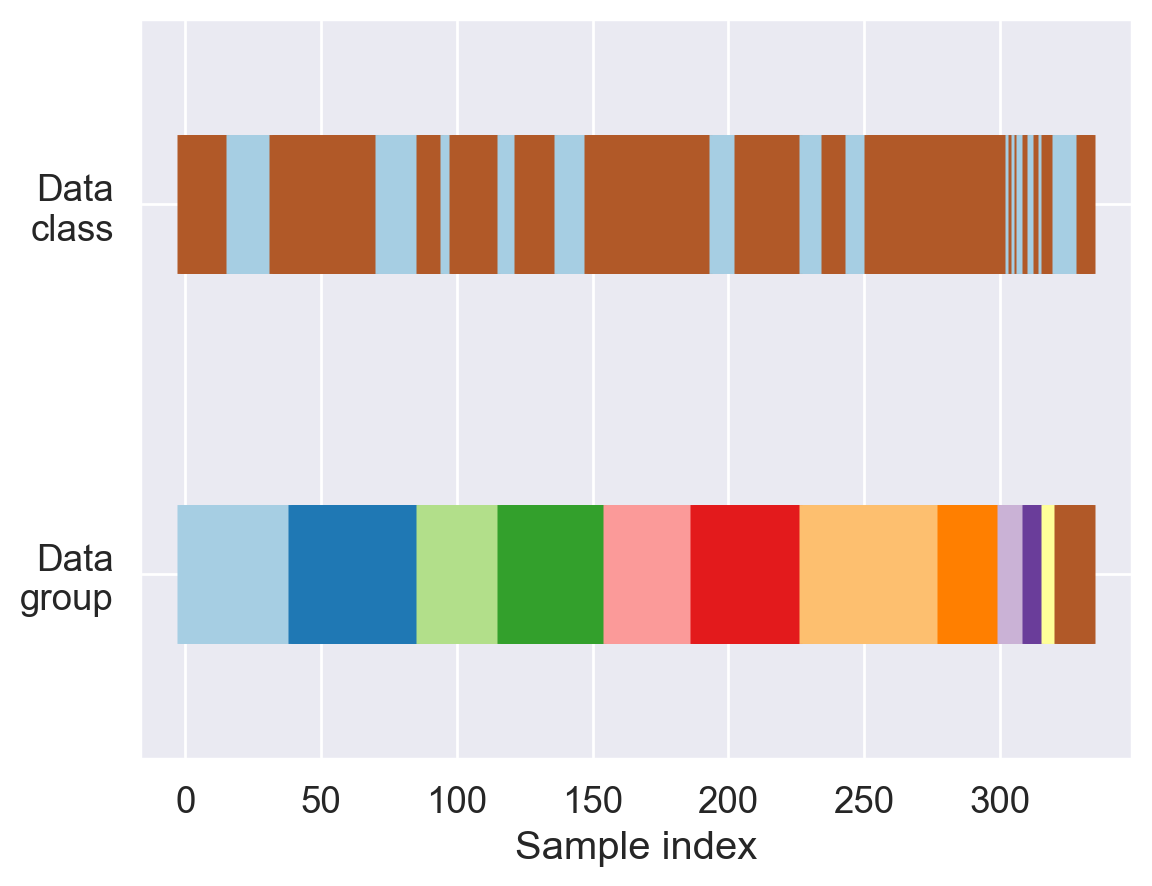

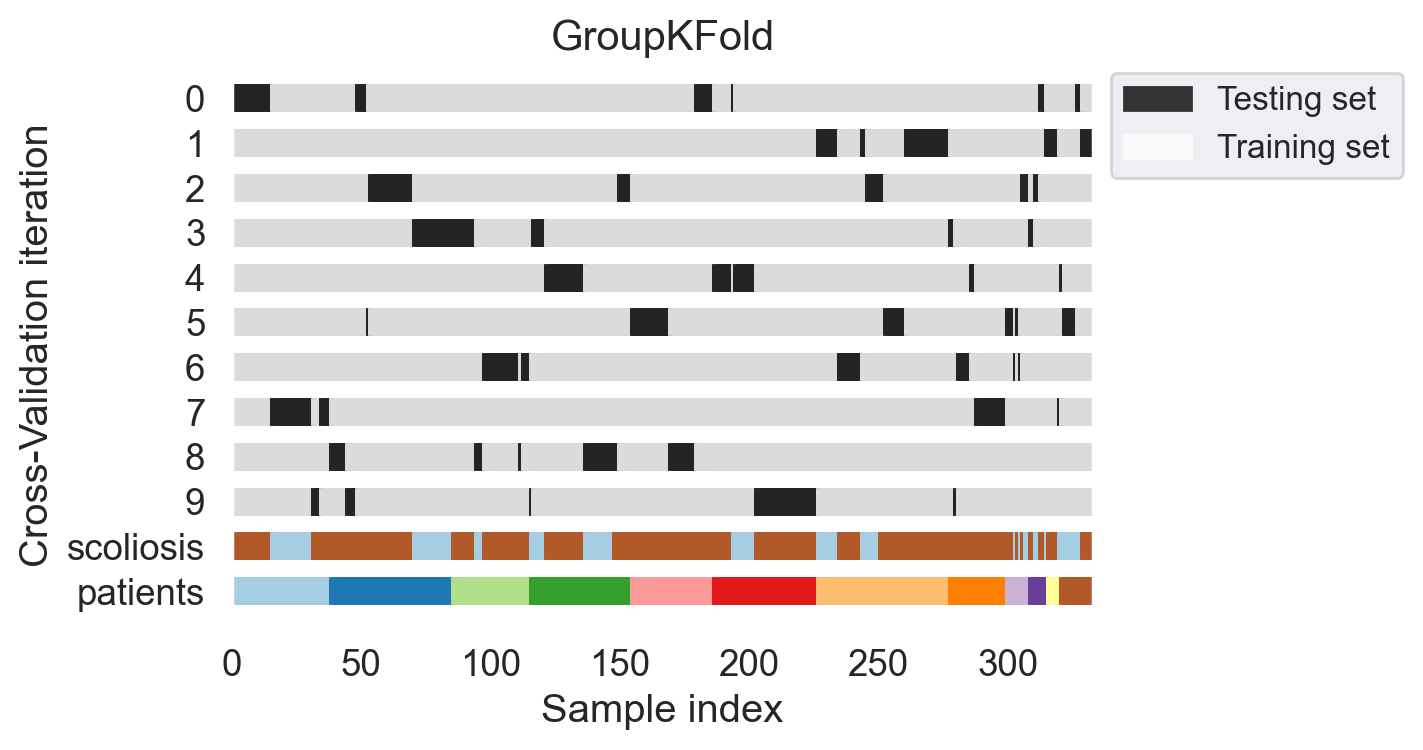

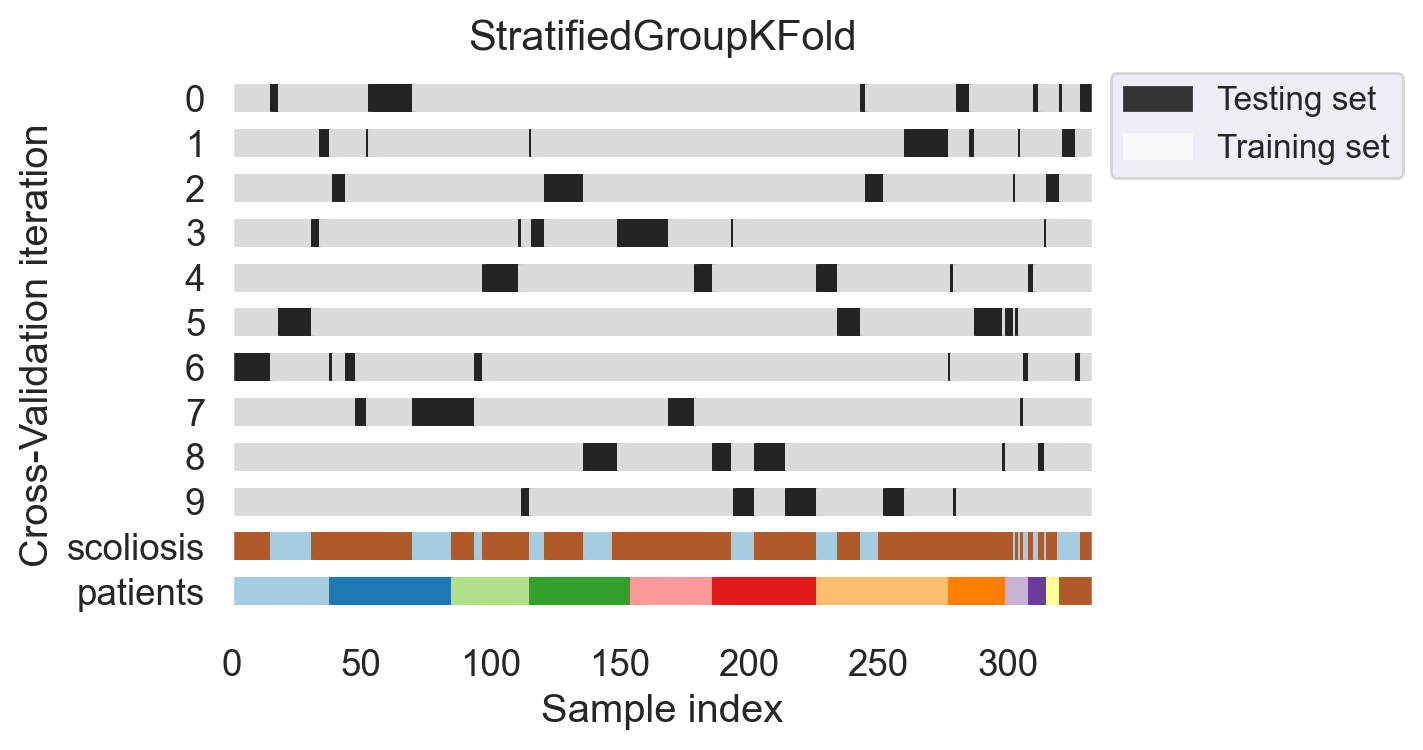

In [39]:
# Visualize GroupKFold Splitting 
# https://scikit-learn.org/stable/auto_examples/model_selection/plot_cv_indices.html#sphx-glr-auto-examples-model-selection-plot-cv-indices-py
cm.colors.cnames.keys()

colors = [[0.0, "midnightblue"],[1.0, "yellow"]]
orange_blue = mcl.LinearSegmentedColormap.from_list("", colors)

cmap_data = plt.cm.Paired
cmap_cv = plt.cm.binary

visualize_groups(y, groups, "no groups")


cvs = [GroupKFold, StratifiedGroupKFold]

for cv in cvs: 
    fig, ax = plt.subplots(figsize=(8, 4))
    plot_cv_indices(cv(n_splits), X, y, groups, ax, n_splits) 
    ax.legend(
        [Patch(color=cmap_cv(0.8)), Patch(color=cmap_cv(0.02))],
        ["Testing set", "Training set"],
        loc=(1.02, 0.8), fontsize=12
    )
    
    plt.tight_layout()
    fig.subplots_adjust(right=0.7)
    plt.savefig(TARGET_DIR +'KFolds.pdf', dpi=DPI)

plt.show()

# Feature Importance Evaluations


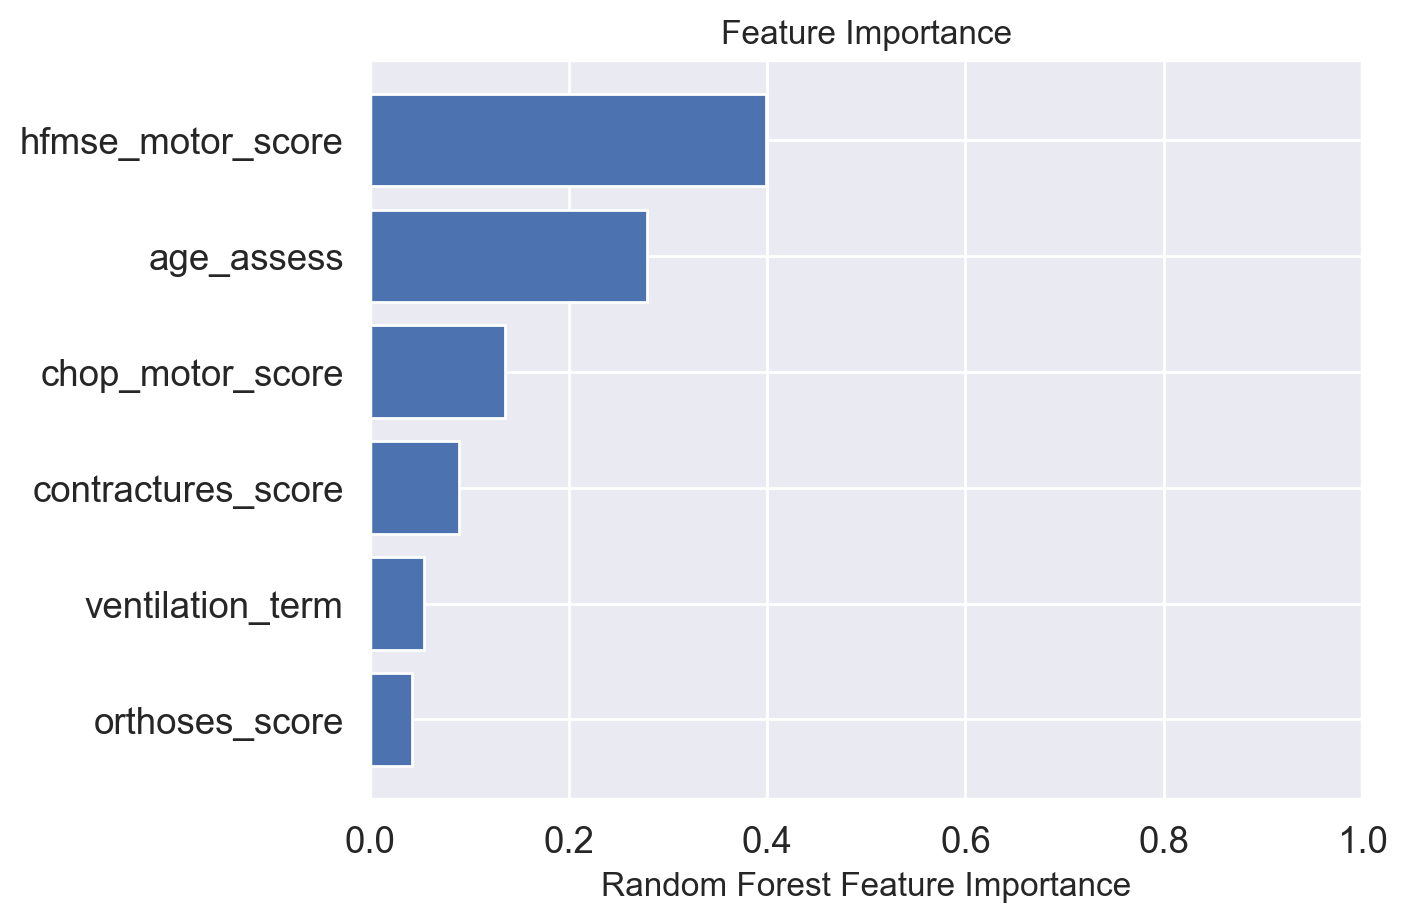

In [40]:
model = models[7]
get_gini_importance(model, traincols, df_train, TARGET_DIR, DPI, fn='Feature Importance')

In [41]:
"""
Display the decision trees of a model(i)
"""
ml_models.generate_decision_tree(models, feature_names, fn='Decision Tree', model_i=3, estimator_idx=np.arange(0,1))